# Assignment 2: The Winter is here
##### This works best with epic battle music. No spoilers present.
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tywin Lannister was right when he said: "The great war is between death and life, ice and fire. If we loose, the night will never end"<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It has been six months since the white walkers' army marched into the north, led by the night king himself on a dead dragon. It has been a battle like never before: never before have men faced such an enemy in battle, never before have men fought so bravely against a united threat, and never before have they been so gravely defeated.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While Cersei is in King's landing, brave men have died fighting the great war. Among others, Tyrion is dead, Arya is dead and Jon Snow is dead, again. In a desperate battle, Daenerys leads all her forces in a final stand-off with the dead just south of Winterfell. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Her army defeated, she is now on the run on her dragon in an air battle, being chased by two of her own dragons, the Night king and a dead Jon Snow. Suddenly, the Night king's spear hits Danny's dragon, who, raining blood and fire, falls into ice, taking the lost queen, with him. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Daenerys opens her eyes in a strange place, a place which does not follow the rules of space and time, where the dead souls killed by the dead men are trapped, forever. But who woke her up? There stands near her, Tyrion, with Jorah, Davos, Jon Snow, and everybody else. They all indulge in a heartfelt reunion when someone yells- "But how do we get out?<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Varys sees a talking crystal close by, who asks them of completing a task, which on completion would allow them to go back to the land of the living, with the ultimate tool to defeat the white-walkers and kills the night king, the Dragon-axe. They have summoned you for help, as the task is out of their expertise, to apply a modified CNN to solve the object detection problem on the PASCAL VOC dataset. Varys, the master of whisperers, has used his talents to import the following for you:

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# You can ask Varys to get you more if you desire
import xml.etree.ElementTree as ET
import glob
import PIL.Image
import PIL.ImageChops
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import skimage.measure
import skimage.morphology
from random import randint

resnet_input = 224#size of resnet18 input images

In [2]:
# Cersei chose violence, you choose your hyper-parameters wisely using validation data!
batch_size = 2
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9

## Build the data
The hound who was in charge for getting the data, brought you the following links:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>He also told you that the dataset(datascrolls :P) consists of images from of 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can ask Varys to import xml.etree.ElementTree for you. <br/>
<br/> You can then ask Bronn and Jamie to organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [3]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
# Taken form pyimagesearch for calculating intersection over union
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea + np.finfo(float).eps)
 
    # return the intersection over union value
    return iou

In [5]:
# Taken from stackoverflow for drawing random bounding boxes
def random_bbox(bbox):
    v = [randint(0, v) for v in bbox]
    left = min(v[0], v[2])
    upper = min(v[1], v[3])
    right = max(v[0], v[2])
    lower = max(v[1], v[3])
    return [left, upper, right, lower]

In [6]:
def jamie_bronn_build_dataset(dir,img_path):            
    image = PIL.Image.open(img_path)
    img_name = img_path.split("/")[-1].split(".")[-2]
    print(img_name)
    xml_path = dir+'/Annotations/'+img_name+'.xml'
    xml_tree = ET.parse(xml_path)
    xml_root = xml_tree.getroot()

    temp_img = PIL.Image.new('RGB',image.size,0)
#     image.show()
    
    location = []
    labels = []
    object_img = []
    for object in xml_root.findall('object'):
        name = object.find('name').text
        position = [int(object.find('bndbox').find('xmin').text), int(object.find('bndbox').find('ymin').text),
                    int(object.find('bndbox').find('xmax').text), int(object.find('bndbox').find('ymax').text)]
        location.append(position)
        crop_img = image.crop(position).convert('RGB')
        object_img.append(crop_img)
        labels.append(classes.index(name))
        
#         temp_img.paste(crop_img,position)

#     temp_img = PIL.ImageChops.subtract(image,temp_img)
#     l = skimage.morphology.label(np.array(image.convert('L')))
#     regions = skimage.measure.regionprops(l)
#     max_area = 0
#     for region in regions:
#         if region.area >= max_area:
#             position = region.bbox
#             max_area = region.area
            
#     location.append(position)        
#     crop_img = image.crop(position).convert('RGB')
# #     crop_img.show()
#     object_img.append(crop_img)
#     labels.append(classes.index('__background__'))

    iou_threshold = 0.3
    num = 0
    while(num < 1):
        bbox = image.getbbox()
        boxA = random_bbox(bbox)
        mscore = 0
        for boxB in location:
              score = (bb_intersection_over_union(boxA, boxB))
              if (score > mscore):
                  mscore = score
        if (mscore < iou_threshold):
            object_img.append(image.crop(boxA).convert('RGB'))
            labels.append(classes.index('__background__'))
            num = num + 1
        
    return object_img, labels

In [7]:
class hound_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        print(train)
        if(train):
            dir = root_dir + '/train/VOCdevkit/VOC2007'
        else :
            dir = root_dir + '/test/VOCdevkit/VOC2007'
        self.transform = transform
        self.img = [];
        self.label = [];
        i = 0
        for img_path in glob.glob(dir+'/JPEGImages/*.jpg'):
            object_img, name = jamie_bronn_build_dataset(dir,img_path)
            self.img.extend(object_img)
            self.label.extend(name)
#             i = i+1
#             if i == 7:
#                 break
                       
                
    def __len__(self):
        return len(self.img)
        
    def __getitem__(self, idx):
        if self.transform is None:
            return (self.img[idx],self.label[idx])
        else:
            img_transformed = self.transform(self.img[idx])
            return (img_transformed,self.label[idx])

In [8]:
# train_dataset = hound_dataset(root_dir='.', train=False, transform=None) # Supply proper root_dir

## Train the netwok
<br/>You can ask Arya to train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [9]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])
train_dataset = hound_dataset(root_dir='.', train=True, transform=composed_transform) # Supply proper root_dir
# test_dataset = hound_dataset(root_dir='.', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

True
007451
000270
008144
006174
008438
005669
007876
002677
001214
001045
005599
008051
002417
001164
007021
002293
001083
006190
007388
008391
006617
006421
009469
001768
007133
000850
006129
004075
007527
006947
006806
004145
004686
009845
007575
006300
005159
008645
000020
000220
008468
009954
006972
007857
006841
001899
008372
003946
009686
003477
002689
003913
001784
002767
007189
006355
004091
001460
009816
003327
007439
003830
001911
003082
009772
006455
003589
009839
002267
007723
007390
009308
005138
009524
000772
008326
006139
000048
005755
009000
009584
006172
008738
004351
008338
005209
003433
006222
002039
005222
007325
003259
000163
007732
007185
009316
003685
002772
001073
001828
004352
001084
006572
002249
005016
000828
001678
002027
006916
009860
007389
003705
006645
005430
000498
000797
006714
002480
007330
008550
000892
009499
000476
006968
006463
006391
009282
008220
008970
001541
006206
003788
007838
004974
005791
006892
008727
005600
005566
002471
008772
000929
0

003671
007048
003453
009747
009490
001036
003954
007729
002308
009424
009480
009195
003890
001397
005940
005840
003708
004992
005176
009197
006611
005487
004013
008723
007149
004215
007065
008485
001230
008374
003874
000619
006848
009148
006847
003525
001515
008926
004735
002659
008049
004105
008341
000146
008873
009655
007883
005648
001176
001191
001892
000021
000857
005992
003593
008576
007224
003137
005824
001739
004273
003691
001225
008442
001071
007578
008936
000041
003865
007314
004982
002741
002938
005664
005307
004828
007624
008564
009886
002935
005579
008023
006117
009738
001209
005244
004625
002030
004117
007408
003509
005519
006520
006781
009904
003847
004649
006814
001402
007078
003763
003885
003285
006769
002670
000782
009117
004868
001341
005378
007585
008909
004527
005483
004009
006301
008983
009789
003496
001684
000531
002376
003429
007130
004255
000153
003105
000099
006747
007363
009438
007372
002848
001977
001780
006773
004439
004514
005988
004519
001289
007230
000171

005998
007511
009005
006678
001729
009123
008989
003320
005889
009042
002593
007664
007187
001200
008698
000823
003272
000500
006417
006648
009719
006900
009456
005843
004468
003185
007204
005805
002738
004067
005631
008209
003760
004517
008115
002691
003430
006337
006702
008384
005061
005874
000052
008953
006338
009180
000122
003642
007919
003556
007872
006219
002439
005614
000661
001061
004946
007432
007735
003450
007856
006444
009224
006400
008633
009617
005220
006708
003956
001806
008410
003879
005018
001212
002022
006842
003834
003118
009239
005351
006627
004553
003961
005318
007841
008064
006578
002571
000582
008843
008306
005370
008975
000266
002090
002763
002533
005421
008529
002757
009193
002683
006917
001821
002088
009214
004626
007097
009881
000443
009326
005246
001365
002490
006352
002967
006803
002425
004508
008690
006028
004220
006488
005349
002208
004303
009834
001436
006038
008044
009099
002182
001107
005863
004204
005850
007059
007682
008430
004928
008453
009269
000089

000810
002259
001334
003748
006772
005134
001982
008346
000565
008695
003510
001732
004518
003684
002696
003465
007092
004298
009500
006250
009327
005297
007089
000117
005951
009259
008533
007809
004689
000770
005395
007984
006912
004170
009100
006850
000720
004990
001556
003255
001766
001797
000424
005268
003491
002064
008381
003260
003072
006270
008923
007697
001750
009443
005654
007667
002867
002870
002496
002986
003258
005389
007035
008880
001439
000477
001603
004907
006348
007751
000878
006989
008692
008871
007411
008628
008856
008794
004205
006565
001765
008636
003899
001842
007779
002099
000189
003690
006009
001204
001170
009049
007007
008773
000577
001887
004326
002953
000142
001862
007727
001464
000246
002441
003045
003181
003949
005507
002816
000036
000588
006635
005679
005952
009306
007071
008710
008670
007279
004481
004701
009068
006449
006251
003735
004239
003806
006593
004095
004178
001136
002664
005657
004878
005756
009448
008978
009944
000948
008137
000804
000492
003421

009698
009460
003791
006279
000187
006499
009255
004152
009841
000320
001129
000633
000347
000282
006668
002919
007590
003814
002155
008225
008858
007191
002273
003379
004265
000520
003895
009543
009676
006084
006230
006396
000180
004623
004903
002281
001493
003973
002021
008284
004958
000318
000845
007810
000834
004230
000680
001673
006697
007503
005454
000218
002190
002896
000806
007234
002697
006664
005624
001277
001148
008979
007422
003028
002605
002348
009174
005644
003162
005730
007482
005223
001936
003417
002782
009685
000209
009020
006450
008822
005799
001759
008125
007762
004825
004973
008836
003511
005885
009687
001444
001778
005441
004722
008037
002377
000625
000830
007946
008316
003108
009150
004960
006150
007108
004753
004270
001240
002268
003083
006296
003004
004325
004540
001152
002572
007926
006276
005348
007653
002369
003039
005315
003100
000242
009063
005457
004846
007474
002524
003658
002901
007140
005806
003860
004293
006151
000352
004706
002917
000009
009587
008223

### Fine-tuning
Litlefinger has brought you a pre-trained network. Fine-tune the network in the following section:

In [10]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    resnet18.cuda()

In [11]:
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [12]:
def arya_train():
    # Begin
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

Epoch [1/5], Step [2/10336], Loss: 3.2987
Epoch [1/5], Step [4/10336], Loss: 2.7368
Epoch [1/5], Step [6/10336], Loss: 2.4968
Epoch [1/5], Step [8/10336], Loss: 2.5038
Epoch [1/5], Step [10/10336], Loss: 1.4645
Epoch [1/5], Step [12/10336], Loss: 0.7685
Epoch [1/5], Step [14/10336], Loss: 0.8538
Epoch [1/5], Step [16/10336], Loss: 2.7035
Epoch [1/5], Step [18/10336], Loss: 4.9910
Epoch [1/5], Step [20/10336], Loss: 0.3253
Epoch [1/5], Step [22/10336], Loss: 1.1724
Epoch [1/5], Step [24/10336], Loss: 5.2462
Epoch [1/5], Step [26/10336], Loss: 3.7815
Epoch [1/5], Step [28/10336], Loss: 5.9995
Epoch [1/5], Step [30/10336], Loss: 3.2110
Epoch [1/5], Step [32/10336], Loss: 4.5494
Epoch [1/5], Step [34/10336], Loss: 3.1467
Epoch [1/5], Step [36/10336], Loss: 4.9604
Epoch [1/5], Step [38/10336], Loss: 3.0776
Epoch [1/5], Step [40/10336], Loss: 2.2289
Epoch [1/5], Step [42/10336], Loss: 1.9813
Epoch [1/5], Step [44/10336], Loss: 3.1018
Epoch [1/5], Step [46/10336], Loss: 4.0856
Epoch [1/5], St

Epoch [1/5], Step [380/10336], Loss: 1.4662
Epoch [1/5], Step [382/10336], Loss: 2.8443
Epoch [1/5], Step [384/10336], Loss: 4.2801
Epoch [1/5], Step [386/10336], Loss: 1.3774
Epoch [1/5], Step [388/10336], Loss: 5.2698
Epoch [1/5], Step [390/10336], Loss: 5.5772
Epoch [1/5], Step [392/10336], Loss: 3.5044
Epoch [1/5], Step [394/10336], Loss: 1.7633
Epoch [1/5], Step [396/10336], Loss: 1.4021
Epoch [1/5], Step [398/10336], Loss: 5.0964
Epoch [1/5], Step [400/10336], Loss: 5.7908
Epoch [1/5], Step [402/10336], Loss: 4.5891
Epoch [1/5], Step [404/10336], Loss: 3.5112
Epoch [1/5], Step [406/10336], Loss: 2.1924
Epoch [1/5], Step [408/10336], Loss: 5.0596
Epoch [1/5], Step [410/10336], Loss: 5.3193
Epoch [1/5], Step [412/10336], Loss: 1.2918
Epoch [1/5], Step [414/10336], Loss: 5.4769
Epoch [1/5], Step [416/10336], Loss: 4.4012
Epoch [1/5], Step [418/10336], Loss: 2.8205
Epoch [1/5], Step [420/10336], Loss: 1.4667
Epoch [1/5], Step [422/10336], Loss: 4.4899
Epoch [1/5], Step [424/10336], L

Epoch [1/5], Step [758/10336], Loss: 2.0646
Epoch [1/5], Step [760/10336], Loss: 1.1979
Epoch [1/5], Step [762/10336], Loss: 0.3550
Epoch [1/5], Step [764/10336], Loss: 4.4631
Epoch [1/5], Step [766/10336], Loss: 0.2523
Epoch [1/5], Step [768/10336], Loss: 1.6880
Epoch [1/5], Step [770/10336], Loss: 5.3302
Epoch [1/5], Step [772/10336], Loss: 4.9637
Epoch [1/5], Step [774/10336], Loss: 1.7278
Epoch [1/5], Step [776/10336], Loss: 1.6262
Epoch [1/5], Step [778/10336], Loss: 2.4174
Epoch [1/5], Step [780/10336], Loss: 3.5063
Epoch [1/5], Step [782/10336], Loss: 3.3543
Epoch [1/5], Step [784/10336], Loss: 2.7870
Epoch [1/5], Step [786/10336], Loss: 3.1415
Epoch [1/5], Step [788/10336], Loss: 1.7970
Epoch [1/5], Step [790/10336], Loss: 2.4209
Epoch [1/5], Step [792/10336], Loss: 2.2618
Epoch [1/5], Step [794/10336], Loss: 0.4532
Epoch [1/5], Step [796/10336], Loss: 2.4343
Epoch [1/5], Step [798/10336], Loss: 2.2771
Epoch [1/5], Step [800/10336], Loss: 2.0967
Epoch [1/5], Step [802/10336], L

Epoch [1/5], Step [1130/10336], Loss: 1.7966
Epoch [1/5], Step [1132/10336], Loss: 1.7662
Epoch [1/5], Step [1134/10336], Loss: 2.2348
Epoch [1/5], Step [1136/10336], Loss: 2.9688
Epoch [1/5], Step [1138/10336], Loss: 2.8623
Epoch [1/5], Step [1140/10336], Loss: 0.8515
Epoch [1/5], Step [1142/10336], Loss: 0.6376
Epoch [1/5], Step [1144/10336], Loss: 2.0939
Epoch [1/5], Step [1146/10336], Loss: 5.6804
Epoch [1/5], Step [1148/10336], Loss: 0.4146
Epoch [1/5], Step [1150/10336], Loss: 1.5443
Epoch [1/5], Step [1152/10336], Loss: 0.2501
Epoch [1/5], Step [1154/10336], Loss: 5.7726
Epoch [1/5], Step [1156/10336], Loss: 2.6893
Epoch [1/5], Step [1158/10336], Loss: 1.1135
Epoch [1/5], Step [1160/10336], Loss: 4.3362
Epoch [1/5], Step [1162/10336], Loss: 3.4621
Epoch [1/5], Step [1164/10336], Loss: 1.6888
Epoch [1/5], Step [1166/10336], Loss: 1.8994
Epoch [1/5], Step [1168/10336], Loss: 3.2794
Epoch [1/5], Step [1170/10336], Loss: 2.4267
Epoch [1/5], Step [1172/10336], Loss: 1.6511
Epoch [1/5

Epoch [1/5], Step [1496/10336], Loss: 2.4838
Epoch [1/5], Step [1498/10336], Loss: 3.2022
Epoch [1/5], Step [1500/10336], Loss: 2.6433
Epoch [1/5], Step [1502/10336], Loss: 1.0678
Epoch [1/5], Step [1504/10336], Loss: 2.1443
Epoch [1/5], Step [1506/10336], Loss: 2.1382
Epoch [1/5], Step [1508/10336], Loss: 4.7892
Epoch [1/5], Step [1510/10336], Loss: 2.0143
Epoch [1/5], Step [1512/10336], Loss: 0.0206
Epoch [1/5], Step [1514/10336], Loss: 1.2010
Epoch [1/5], Step [1516/10336], Loss: 2.9708
Epoch [1/5], Step [1518/10336], Loss: 1.9445
Epoch [1/5], Step [1520/10336], Loss: 4.3432
Epoch [1/5], Step [1522/10336], Loss: 1.0317
Epoch [1/5], Step [1524/10336], Loss: 2.4791
Epoch [1/5], Step [1526/10336], Loss: 2.2227
Epoch [1/5], Step [1528/10336], Loss: 6.1019
Epoch [1/5], Step [1530/10336], Loss: 1.2331
Epoch [1/5], Step [1532/10336], Loss: 0.9453
Epoch [1/5], Step [1534/10336], Loss: 0.7871
Epoch [1/5], Step [1536/10336], Loss: 3.8902
Epoch [1/5], Step [1538/10336], Loss: 1.1393
Epoch [1/5

Epoch [1/5], Step [1862/10336], Loss: 0.2273
Epoch [1/5], Step [1864/10336], Loss: 4.3924
Epoch [1/5], Step [1866/10336], Loss: 1.3553
Epoch [1/5], Step [1868/10336], Loss: 4.4408
Epoch [1/5], Step [1870/10336], Loss: 2.7066
Epoch [1/5], Step [1872/10336], Loss: 4.1709
Epoch [1/5], Step [1874/10336], Loss: 1.7009
Epoch [1/5], Step [1876/10336], Loss: 1.0857
Epoch [1/5], Step [1878/10336], Loss: 3.8988
Epoch [1/5], Step [1880/10336], Loss: 0.7960
Epoch [1/5], Step [1882/10336], Loss: 3.2067
Epoch [1/5], Step [1884/10336], Loss: 1.5555
Epoch [1/5], Step [1886/10336], Loss: 1.0411
Epoch [1/5], Step [1888/10336], Loss: 2.0782
Epoch [1/5], Step [1890/10336], Loss: 1.5710
Epoch [1/5], Step [1892/10336], Loss: 0.5889
Epoch [1/5], Step [1894/10336], Loss: 0.1989
Epoch [1/5], Step [1896/10336], Loss: 1.4890
Epoch [1/5], Step [1898/10336], Loss: 4.1115
Epoch [1/5], Step [1900/10336], Loss: 3.7507
Epoch [1/5], Step [1902/10336], Loss: 1.4636
Epoch [1/5], Step [1904/10336], Loss: 2.0353
Epoch [1/5

Epoch [1/5], Step [2228/10336], Loss: 0.9310
Epoch [1/5], Step [2230/10336], Loss: 0.5649
Epoch [1/5], Step [2232/10336], Loss: 1.8514
Epoch [1/5], Step [2234/10336], Loss: 3.0737
Epoch [1/5], Step [2236/10336], Loss: 2.0490
Epoch [1/5], Step [2238/10336], Loss: 0.3082
Epoch [1/5], Step [2240/10336], Loss: 1.1624
Epoch [1/5], Step [2242/10336], Loss: 1.7615
Epoch [1/5], Step [2244/10336], Loss: 1.5381
Epoch [1/5], Step [2246/10336], Loss: 6.2132
Epoch [1/5], Step [2248/10336], Loss: 3.0813
Epoch [1/5], Step [2250/10336], Loss: 5.4131
Epoch [1/5], Step [2252/10336], Loss: 0.2594
Epoch [1/5], Step [2254/10336], Loss: 2.3320
Epoch [1/5], Step [2256/10336], Loss: 0.2497
Epoch [1/5], Step [2258/10336], Loss: 1.9474
Epoch [1/5], Step [2260/10336], Loss: 1.7866
Epoch [1/5], Step [2262/10336], Loss: 2.8885
Epoch [1/5], Step [2264/10336], Loss: 1.3501
Epoch [1/5], Step [2266/10336], Loss: 1.4394
Epoch [1/5], Step [2268/10336], Loss: 1.8678
Epoch [1/5], Step [2270/10336], Loss: 0.6338
Epoch [1/5

Epoch [1/5], Step [2594/10336], Loss: 1.4639
Epoch [1/5], Step [2596/10336], Loss: 2.6887
Epoch [1/5], Step [2598/10336], Loss: 1.2209
Epoch [1/5], Step [2600/10336], Loss: 0.5399
Epoch [1/5], Step [2602/10336], Loss: 5.3091
Epoch [1/5], Step [2604/10336], Loss: 1.2775
Epoch [1/5], Step [2606/10336], Loss: 4.8856
Epoch [1/5], Step [2608/10336], Loss: 1.0407
Epoch [1/5], Step [2610/10336], Loss: 3.6395
Epoch [1/5], Step [2612/10336], Loss: 1.5719
Epoch [1/5], Step [2614/10336], Loss: 3.7172
Epoch [1/5], Step [2616/10336], Loss: 2.8424
Epoch [1/5], Step [2618/10336], Loss: 1.9060
Epoch [1/5], Step [2620/10336], Loss: 4.4523
Epoch [1/5], Step [2622/10336], Loss: 3.2362
Epoch [1/5], Step [2624/10336], Loss: 1.0341
Epoch [1/5], Step [2626/10336], Loss: 0.9982
Epoch [1/5], Step [2628/10336], Loss: 0.8614
Epoch [1/5], Step [2630/10336], Loss: 3.1077
Epoch [1/5], Step [2632/10336], Loss: 3.3304
Epoch [1/5], Step [2634/10336], Loss: 0.5964
Epoch [1/5], Step [2636/10336], Loss: 0.5155
Epoch [1/5

Epoch [1/5], Step [2960/10336], Loss: 1.5894
Epoch [1/5], Step [2962/10336], Loss: 2.5258
Epoch [1/5], Step [2964/10336], Loss: 4.4167
Epoch [1/5], Step [2966/10336], Loss: 0.0125
Epoch [1/5], Step [2968/10336], Loss: 3.6666
Epoch [1/5], Step [2970/10336], Loss: 2.0513
Epoch [1/5], Step [2972/10336], Loss: 0.4219
Epoch [1/5], Step [2974/10336], Loss: 0.4099
Epoch [1/5], Step [2976/10336], Loss: 1.3737
Epoch [1/5], Step [2978/10336], Loss: 1.6565
Epoch [1/5], Step [2980/10336], Loss: 4.3718
Epoch [1/5], Step [2982/10336], Loss: 1.9020
Epoch [1/5], Step [2984/10336], Loss: 2.0547
Epoch [1/5], Step [2986/10336], Loss: 0.4361
Epoch [1/5], Step [2988/10336], Loss: 2.0060
Epoch [1/5], Step [2990/10336], Loss: 1.9171
Epoch [1/5], Step [2992/10336], Loss: 2.0687
Epoch [1/5], Step [2994/10336], Loss: 1.5367
Epoch [1/5], Step [2996/10336], Loss: 5.4504
Epoch [1/5], Step [2998/10336], Loss: 0.1957
Epoch [1/5], Step [3000/10336], Loss: 0.2372
Epoch [1/5], Step [3002/10336], Loss: 0.2722
Epoch [1/5

Epoch [1/5], Step [3326/10336], Loss: 0.1214
Epoch [1/5], Step [3328/10336], Loss: 4.8966
Epoch [1/5], Step [3330/10336], Loss: 1.9828
Epoch [1/5], Step [3332/10336], Loss: 3.9453
Epoch [1/5], Step [3334/10336], Loss: 0.5905
Epoch [1/5], Step [3336/10336], Loss: 1.0128
Epoch [1/5], Step [3338/10336], Loss: 1.3123
Epoch [1/5], Step [3340/10336], Loss: 0.5884
Epoch [1/5], Step [3342/10336], Loss: 4.2429
Epoch [1/5], Step [3344/10336], Loss: 2.9204
Epoch [1/5], Step [3346/10336], Loss: 1.3496
Epoch [1/5], Step [3348/10336], Loss: 2.1410
Epoch [1/5], Step [3350/10336], Loss: 2.2467
Epoch [1/5], Step [3352/10336], Loss: 1.9636
Epoch [1/5], Step [3354/10336], Loss: 0.5350
Epoch [1/5], Step [3356/10336], Loss: 0.2124
Epoch [1/5], Step [3358/10336], Loss: 0.6426
Epoch [1/5], Step [3360/10336], Loss: 0.3119
Epoch [1/5], Step [3362/10336], Loss: 2.4165
Epoch [1/5], Step [3364/10336], Loss: 1.4685
Epoch [1/5], Step [3366/10336], Loss: 1.7070
Epoch [1/5], Step [3368/10336], Loss: 2.4031
Epoch [1/5

Epoch [1/5], Step [3692/10336], Loss: 4.9367
Epoch [1/5], Step [3694/10336], Loss: 1.6853
Epoch [1/5], Step [3696/10336], Loss: 0.1593
Epoch [1/5], Step [3698/10336], Loss: 0.3086
Epoch [1/5], Step [3700/10336], Loss: 3.8371
Epoch [1/5], Step [3702/10336], Loss: 1.7951
Epoch [1/5], Step [3704/10336], Loss: 0.6348
Epoch [1/5], Step [3706/10336], Loss: 3.2815
Epoch [1/5], Step [3708/10336], Loss: 0.6473
Epoch [1/5], Step [3710/10336], Loss: 0.5666
Epoch [1/5], Step [3712/10336], Loss: 1.3649
Epoch [1/5], Step [3714/10336], Loss: 1.4552
Epoch [1/5], Step [3716/10336], Loss: 2.5921
Epoch [1/5], Step [3718/10336], Loss: 0.2779
Epoch [1/5], Step [3720/10336], Loss: 1.9909
Epoch [1/5], Step [3722/10336], Loss: 3.8189
Epoch [1/5], Step [3724/10336], Loss: 0.8523
Epoch [1/5], Step [3726/10336], Loss: 2.8083
Epoch [1/5], Step [3728/10336], Loss: 0.6308
Epoch [1/5], Step [3730/10336], Loss: 1.0640
Epoch [1/5], Step [3732/10336], Loss: 1.0102
Epoch [1/5], Step [3734/10336], Loss: 1.2908
Epoch [1/5

Epoch [1/5], Step [4058/10336], Loss: 0.7212
Epoch [1/5], Step [4060/10336], Loss: 2.5021
Epoch [1/5], Step [4062/10336], Loss: 3.6813
Epoch [1/5], Step [4064/10336], Loss: 3.4836
Epoch [1/5], Step [4066/10336], Loss: 0.7909
Epoch [1/5], Step [4068/10336], Loss: 0.7198
Epoch [1/5], Step [4070/10336], Loss: 4.1820
Epoch [1/5], Step [4072/10336], Loss: 0.4435
Epoch [1/5], Step [4074/10336], Loss: 2.0914
Epoch [1/5], Step [4076/10336], Loss: 0.2379
Epoch [1/5], Step [4078/10336], Loss: 0.4185
Epoch [1/5], Step [4080/10336], Loss: 0.3413
Epoch [1/5], Step [4082/10336], Loss: 1.4417
Epoch [1/5], Step [4084/10336], Loss: 0.0730
Epoch [1/5], Step [4086/10336], Loss: 2.0151
Epoch [1/5], Step [4088/10336], Loss: 2.2479
Epoch [1/5], Step [4090/10336], Loss: 1.5814
Epoch [1/5], Step [4092/10336], Loss: 1.7455
Epoch [1/5], Step [4094/10336], Loss: 2.5814
Epoch [1/5], Step [4096/10336], Loss: 2.7733
Epoch [1/5], Step [4098/10336], Loss: 4.4074
Epoch [1/5], Step [4100/10336], Loss: 1.9466
Epoch [1/5

Epoch [1/5], Step [4424/10336], Loss: 2.5572
Epoch [1/5], Step [4426/10336], Loss: 1.3633
Epoch [1/5], Step [4428/10336], Loss: 2.2353
Epoch [1/5], Step [4430/10336], Loss: 1.7930
Epoch [1/5], Step [4432/10336], Loss: 0.2665
Epoch [1/5], Step [4434/10336], Loss: 2.2273
Epoch [1/5], Step [4436/10336], Loss: 1.4403
Epoch [1/5], Step [4438/10336], Loss: 2.6314
Epoch [1/5], Step [4440/10336], Loss: 1.8998
Epoch [1/5], Step [4442/10336], Loss: 1.2998
Epoch [1/5], Step [4444/10336], Loss: 0.6807
Epoch [1/5], Step [4446/10336], Loss: 1.4422
Epoch [1/5], Step [4448/10336], Loss: 2.4495
Epoch [1/5], Step [4450/10336], Loss: 0.8664
Epoch [1/5], Step [4452/10336], Loss: 2.2150
Epoch [1/5], Step [4454/10336], Loss: 0.2078
Epoch [1/5], Step [4456/10336], Loss: 2.3653
Epoch [1/5], Step [4458/10336], Loss: 1.8137
Epoch [1/5], Step [4460/10336], Loss: 0.3496
Epoch [1/5], Step [4462/10336], Loss: 3.2689
Epoch [1/5], Step [4464/10336], Loss: 0.8622
Epoch [1/5], Step [4466/10336], Loss: 0.5086
Epoch [1/5

Epoch [1/5], Step [4790/10336], Loss: 0.9896
Epoch [1/5], Step [4792/10336], Loss: 1.4195
Epoch [1/5], Step [4794/10336], Loss: 0.5888
Epoch [1/5], Step [4796/10336], Loss: 2.1740
Epoch [1/5], Step [4798/10336], Loss: 0.0564
Epoch [1/5], Step [4800/10336], Loss: 2.7431
Epoch [1/5], Step [4802/10336], Loss: 1.0733
Epoch [1/5], Step [4804/10336], Loss: 1.8384
Epoch [1/5], Step [4806/10336], Loss: 1.8988
Epoch [1/5], Step [4808/10336], Loss: 0.3298
Epoch [1/5], Step [4810/10336], Loss: 1.6534
Epoch [1/5], Step [4812/10336], Loss: 0.4045
Epoch [1/5], Step [4814/10336], Loss: 2.1229
Epoch [1/5], Step [4816/10336], Loss: 0.6847
Epoch [1/5], Step [4818/10336], Loss: 0.9091
Epoch [1/5], Step [4820/10336], Loss: 0.3700
Epoch [1/5], Step [4822/10336], Loss: 1.1090
Epoch [1/5], Step [4824/10336], Loss: 0.3034
Epoch [1/5], Step [4826/10336], Loss: 0.8808
Epoch [1/5], Step [4828/10336], Loss: 2.4649
Epoch [1/5], Step [4830/10336], Loss: 0.6006
Epoch [1/5], Step [4832/10336], Loss: 0.0097
Epoch [1/5

Epoch [1/5], Step [5156/10336], Loss: 3.0829
Epoch [1/5], Step [5158/10336], Loss: 2.0957
Epoch [1/5], Step [5160/10336], Loss: 1.9121
Epoch [1/5], Step [5162/10336], Loss: 0.4006
Epoch [1/5], Step [5164/10336], Loss: 0.3520
Epoch [1/5], Step [5166/10336], Loss: 1.3366
Epoch [1/5], Step [5168/10336], Loss: 1.0109
Epoch [1/5], Step [5170/10336], Loss: 0.9356
Epoch [1/5], Step [5172/10336], Loss: 0.6974
Epoch [1/5], Step [5174/10336], Loss: 0.1271
Epoch [1/5], Step [5176/10336], Loss: 1.4570
Epoch [1/5], Step [5178/10336], Loss: 0.6804
Epoch [1/5], Step [5180/10336], Loss: 0.1376
Epoch [1/5], Step [5182/10336], Loss: 1.6239
Epoch [1/5], Step [5184/10336], Loss: 1.8899
Epoch [1/5], Step [5186/10336], Loss: 0.0500
Epoch [1/5], Step [5188/10336], Loss: 0.0654
Epoch [1/5], Step [5190/10336], Loss: 1.2681
Epoch [1/5], Step [5192/10336], Loss: 0.8730
Epoch [1/5], Step [5194/10336], Loss: 0.6946
Epoch [1/5], Step [5196/10336], Loss: 2.3606
Epoch [1/5], Step [5198/10336], Loss: 0.8707
Epoch [1/5

Epoch [1/5], Step [5522/10336], Loss: 0.4388
Epoch [1/5], Step [5524/10336], Loss: 1.5114
Epoch [1/5], Step [5526/10336], Loss: 1.3932
Epoch [1/5], Step [5528/10336], Loss: 1.3299
Epoch [1/5], Step [5530/10336], Loss: 1.6518
Epoch [1/5], Step [5532/10336], Loss: 1.1027
Epoch [1/5], Step [5534/10336], Loss: 1.9470
Epoch [1/5], Step [5536/10336], Loss: 3.0897
Epoch [1/5], Step [5538/10336], Loss: 2.7349
Epoch [1/5], Step [5540/10336], Loss: 0.2861
Epoch [1/5], Step [5542/10336], Loss: 0.0211
Epoch [1/5], Step [5544/10336], Loss: 0.0124
Epoch [1/5], Step [5546/10336], Loss: 2.3999
Epoch [1/5], Step [5548/10336], Loss: 0.9378
Epoch [1/5], Step [5550/10336], Loss: 0.6163
Epoch [1/5], Step [5552/10336], Loss: 0.1925
Epoch [1/5], Step [5554/10336], Loss: 0.8862
Epoch [1/5], Step [5556/10336], Loss: 1.6173
Epoch [1/5], Step [5558/10336], Loss: 0.8584
Epoch [1/5], Step [5560/10336], Loss: 2.9032
Epoch [1/5], Step [5562/10336], Loss: 1.5764
Epoch [1/5], Step [5564/10336], Loss: 0.4603
Epoch [1/5

Epoch [1/5], Step [5888/10336], Loss: 1.0306
Epoch [1/5], Step [5890/10336], Loss: 0.6279
Epoch [1/5], Step [5892/10336], Loss: 0.6315
Epoch [1/5], Step [5894/10336], Loss: 1.1597
Epoch [1/5], Step [5896/10336], Loss: 0.5627
Epoch [1/5], Step [5898/10336], Loss: 0.3459
Epoch [1/5], Step [5900/10336], Loss: 1.3688
Epoch [1/5], Step [5902/10336], Loss: 1.6295
Epoch [1/5], Step [5904/10336], Loss: 1.7425
Epoch [1/5], Step [5906/10336], Loss: 0.0472
Epoch [1/5], Step [5908/10336], Loss: 0.4013
Epoch [1/5], Step [5910/10336], Loss: 1.3867
Epoch [1/5], Step [5912/10336], Loss: 0.0947
Epoch [1/5], Step [5914/10336], Loss: 1.7191
Epoch [1/5], Step [5916/10336], Loss: 4.3514
Epoch [1/5], Step [5918/10336], Loss: 2.6787
Epoch [1/5], Step [5920/10336], Loss: 0.2773
Epoch [1/5], Step [5922/10336], Loss: 0.5999
Epoch [1/5], Step [5924/10336], Loss: 1.5907
Epoch [1/5], Step [5926/10336], Loss: 0.1140
Epoch [1/5], Step [5928/10336], Loss: 2.7988
Epoch [1/5], Step [5930/10336], Loss: 2.3659
Epoch [1/5

Epoch [1/5], Step [6254/10336], Loss: 0.5620
Epoch [1/5], Step [6256/10336], Loss: 0.6904
Epoch [1/5], Step [6258/10336], Loss: 1.9141
Epoch [1/5], Step [6260/10336], Loss: 1.0431
Epoch [1/5], Step [6262/10336], Loss: 3.5070
Epoch [1/5], Step [6264/10336], Loss: 0.0762
Epoch [1/5], Step [6266/10336], Loss: 0.0159
Epoch [1/5], Step [6268/10336], Loss: 0.5035
Epoch [1/5], Step [6270/10336], Loss: 2.1425
Epoch [1/5], Step [6272/10336], Loss: 2.3221
Epoch [1/5], Step [6274/10336], Loss: 1.9617
Epoch [1/5], Step [6276/10336], Loss: 2.8677
Epoch [1/5], Step [6278/10336], Loss: 2.5402
Epoch [1/5], Step [6280/10336], Loss: 1.2616
Epoch [1/5], Step [6282/10336], Loss: 0.9187
Epoch [1/5], Step [6284/10336], Loss: 0.3054
Epoch [1/5], Step [6286/10336], Loss: 1.3047
Epoch [1/5], Step [6288/10336], Loss: 2.4503
Epoch [1/5], Step [6290/10336], Loss: 2.9311
Epoch [1/5], Step [6292/10336], Loss: 2.4854
Epoch [1/5], Step [6294/10336], Loss: 0.6250
Epoch [1/5], Step [6296/10336], Loss: 2.4346
Epoch [1/5

Epoch [1/5], Step [6620/10336], Loss: 1.9444
Epoch [1/5], Step [6622/10336], Loss: 1.2122
Epoch [1/5], Step [6624/10336], Loss: 1.2151
Epoch [1/5], Step [6626/10336], Loss: 0.2444
Epoch [1/5], Step [6628/10336], Loss: 0.3889
Epoch [1/5], Step [6630/10336], Loss: 1.7922
Epoch [1/5], Step [6632/10336], Loss: 0.3412
Epoch [1/5], Step [6634/10336], Loss: 1.6965
Epoch [1/5], Step [6636/10336], Loss: 1.7702
Epoch [1/5], Step [6638/10336], Loss: 0.7328
Epoch [1/5], Step [6640/10336], Loss: 0.3027
Epoch [1/5], Step [6642/10336], Loss: 0.3992
Epoch [1/5], Step [6644/10336], Loss: 2.5193
Epoch [1/5], Step [6646/10336], Loss: 3.1883
Epoch [1/5], Step [6648/10336], Loss: 1.6934
Epoch [1/5], Step [6650/10336], Loss: 1.5313
Epoch [1/5], Step [6652/10336], Loss: 0.7915
Epoch [1/5], Step [6654/10336], Loss: 2.0120
Epoch [1/5], Step [6656/10336], Loss: 0.3044
Epoch [1/5], Step [6658/10336], Loss: 1.5208
Epoch [1/5], Step [6660/10336], Loss: 0.0500
Epoch [1/5], Step [6662/10336], Loss: 0.0392
Epoch [1/5

Epoch [1/5], Step [6986/10336], Loss: 0.9615
Epoch [1/5], Step [6988/10336], Loss: 3.5479
Epoch [1/5], Step [6990/10336], Loss: 1.8518
Epoch [1/5], Step [6992/10336], Loss: 0.0220
Epoch [1/5], Step [6994/10336], Loss: 2.0442
Epoch [1/5], Step [6996/10336], Loss: 1.8712
Epoch [1/5], Step [6998/10336], Loss: 1.3012
Epoch [1/5], Step [7000/10336], Loss: 0.5279
Epoch [1/5], Step [7002/10336], Loss: 0.4375
Epoch [1/5], Step [7004/10336], Loss: 0.7223
Epoch [1/5], Step [7006/10336], Loss: 1.4764
Epoch [1/5], Step [7008/10336], Loss: 0.7854
Epoch [1/5], Step [7010/10336], Loss: 3.8485
Epoch [1/5], Step [7012/10336], Loss: 0.7148
Epoch [1/5], Step [7014/10336], Loss: 0.5202
Epoch [1/5], Step [7016/10336], Loss: 2.1559
Epoch [1/5], Step [7018/10336], Loss: 1.7929
Epoch [1/5], Step [7020/10336], Loss: 4.7161
Epoch [1/5], Step [7022/10336], Loss: 0.0940
Epoch [1/5], Step [7024/10336], Loss: 0.1592
Epoch [1/5], Step [7026/10336], Loss: 1.6513
Epoch [1/5], Step [7028/10336], Loss: 1.1525
Epoch [1/5

Epoch [1/5], Step [7352/10336], Loss: 0.7307
Epoch [1/5], Step [7354/10336], Loss: 0.0564
Epoch [1/5], Step [7356/10336], Loss: 0.5501
Epoch [1/5], Step [7358/10336], Loss: 0.8739
Epoch [1/5], Step [7360/10336], Loss: 2.2217
Epoch [1/5], Step [7362/10336], Loss: 1.0458
Epoch [1/5], Step [7364/10336], Loss: 0.2362
Epoch [1/5], Step [7366/10336], Loss: 0.5818
Epoch [1/5], Step [7368/10336], Loss: 0.4144
Epoch [1/5], Step [7370/10336], Loss: 0.1987
Epoch [1/5], Step [7372/10336], Loss: 1.2064
Epoch [1/5], Step [7374/10336], Loss: 0.9175
Epoch [1/5], Step [7376/10336], Loss: 0.5200
Epoch [1/5], Step [7378/10336], Loss: 1.3542
Epoch [1/5], Step [7380/10336], Loss: 1.3815
Epoch [1/5], Step [7382/10336], Loss: 0.5342
Epoch [1/5], Step [7384/10336], Loss: 0.0341
Epoch [1/5], Step [7386/10336], Loss: 1.6705
Epoch [1/5], Step [7388/10336], Loss: 0.0188
Epoch [1/5], Step [7390/10336], Loss: 0.1122
Epoch [1/5], Step [7392/10336], Loss: 2.1476
Epoch [1/5], Step [7394/10336], Loss: 0.0770
Epoch [1/5

Epoch [1/5], Step [7718/10336], Loss: 0.3660
Epoch [1/5], Step [7720/10336], Loss: 2.3997
Epoch [1/5], Step [7722/10336], Loss: 0.4951
Epoch [1/5], Step [7724/10336], Loss: 0.9366
Epoch [1/5], Step [7726/10336], Loss: 0.1923
Epoch [1/5], Step [7728/10336], Loss: 0.4929
Epoch [1/5], Step [7730/10336], Loss: 0.6801
Epoch [1/5], Step [7732/10336], Loss: 1.3178
Epoch [1/5], Step [7734/10336], Loss: 0.4058
Epoch [1/5], Step [7736/10336], Loss: 1.9630
Epoch [1/5], Step [7738/10336], Loss: 2.8080
Epoch [1/5], Step [7740/10336], Loss: 4.7954
Epoch [1/5], Step [7742/10336], Loss: 4.4601
Epoch [1/5], Step [7744/10336], Loss: 0.3666
Epoch [1/5], Step [7746/10336], Loss: 3.9008
Epoch [1/5], Step [7748/10336], Loss: 0.5855
Epoch [1/5], Step [7750/10336], Loss: 0.0114
Epoch [1/5], Step [7752/10336], Loss: 2.0681
Epoch [1/5], Step [7754/10336], Loss: 2.2949
Epoch [1/5], Step [7756/10336], Loss: 0.9313
Epoch [1/5], Step [7758/10336], Loss: 1.2537
Epoch [1/5], Step [7760/10336], Loss: 1.2563
Epoch [1/5

Epoch [1/5], Step [8084/10336], Loss: 1.8809
Epoch [1/5], Step [8086/10336], Loss: 5.0496
Epoch [1/5], Step [8088/10336], Loss: 0.1645
Epoch [1/5], Step [8090/10336], Loss: 1.5716
Epoch [1/5], Step [8092/10336], Loss: 0.5259
Epoch [1/5], Step [8094/10336], Loss: 0.9196
Epoch [1/5], Step [8096/10336], Loss: 0.9304
Epoch [1/5], Step [8098/10336], Loss: 0.0863
Epoch [1/5], Step [8100/10336], Loss: 0.7219
Epoch [1/5], Step [8102/10336], Loss: 0.2508
Epoch [1/5], Step [8104/10336], Loss: 1.3177
Epoch [1/5], Step [8106/10336], Loss: 1.3626
Epoch [1/5], Step [8108/10336], Loss: 1.1170
Epoch [1/5], Step [8110/10336], Loss: 0.3764
Epoch [1/5], Step [8112/10336], Loss: 1.3472
Epoch [1/5], Step [8114/10336], Loss: 0.2435
Epoch [1/5], Step [8116/10336], Loss: 0.6156
Epoch [1/5], Step [8118/10336], Loss: 1.3665
Epoch [1/5], Step [8120/10336], Loss: 1.0320
Epoch [1/5], Step [8122/10336], Loss: 0.2306
Epoch [1/5], Step [8124/10336], Loss: 1.2375
Epoch [1/5], Step [8126/10336], Loss: 1.6705
Epoch [1/5

Epoch [1/5], Step [8450/10336], Loss: 1.5053
Epoch [1/5], Step [8452/10336], Loss: 1.0113
Epoch [1/5], Step [8454/10336], Loss: 2.0346
Epoch [1/5], Step [8456/10336], Loss: 0.2221
Epoch [1/5], Step [8458/10336], Loss: 1.9281
Epoch [1/5], Step [8460/10336], Loss: 0.6733
Epoch [1/5], Step [8462/10336], Loss: 0.1207
Epoch [1/5], Step [8464/10336], Loss: 0.0876
Epoch [1/5], Step [8466/10336], Loss: 0.6950
Epoch [1/5], Step [8468/10336], Loss: 0.8514
Epoch [1/5], Step [8470/10336], Loss: 1.4430
Epoch [1/5], Step [8472/10336], Loss: 0.0551
Epoch [1/5], Step [8474/10336], Loss: 0.1372
Epoch [1/5], Step [8476/10336], Loss: 1.9558
Epoch [1/5], Step [8478/10336], Loss: 3.1082
Epoch [1/5], Step [8480/10336], Loss: 0.3591
Epoch [1/5], Step [8482/10336], Loss: 4.4855
Epoch [1/5], Step [8484/10336], Loss: 0.3098
Epoch [1/5], Step [8486/10336], Loss: 0.0444
Epoch [1/5], Step [8488/10336], Loss: 0.6338
Epoch [1/5], Step [8490/10336], Loss: 1.6744
Epoch [1/5], Step [8492/10336], Loss: 0.0630
Epoch [1/5

Epoch [1/5], Step [8816/10336], Loss: 2.4046
Epoch [1/5], Step [8818/10336], Loss: 1.2727
Epoch [1/5], Step [8820/10336], Loss: 0.3343
Epoch [1/5], Step [8822/10336], Loss: 1.2982
Epoch [1/5], Step [8824/10336], Loss: 0.2837
Epoch [1/5], Step [8826/10336], Loss: 1.7315
Epoch [1/5], Step [8828/10336], Loss: 1.1095
Epoch [1/5], Step [8830/10336], Loss: 0.0668
Epoch [1/5], Step [8832/10336], Loss: 0.2918
Epoch [1/5], Step [8834/10336], Loss: 0.0404
Epoch [1/5], Step [8836/10336], Loss: 0.4740
Epoch [1/5], Step [8838/10336], Loss: 0.6540
Epoch [1/5], Step [8840/10336], Loss: 0.7268
Epoch [1/5], Step [8842/10336], Loss: 0.6825
Epoch [1/5], Step [8844/10336], Loss: 1.3469
Epoch [1/5], Step [8846/10336], Loss: 2.0362
Epoch [1/5], Step [8848/10336], Loss: 1.9741
Epoch [1/5], Step [8850/10336], Loss: 0.0386
Epoch [1/5], Step [8852/10336], Loss: 3.0541
Epoch [1/5], Step [8854/10336], Loss: 1.8397
Epoch [1/5], Step [8856/10336], Loss: 1.8190
Epoch [1/5], Step [8858/10336], Loss: 4.0869
Epoch [1/5

Epoch [1/5], Step [9182/10336], Loss: 0.2933
Epoch [1/5], Step [9184/10336], Loss: 0.7778
Epoch [1/5], Step [9186/10336], Loss: 1.0357
Epoch [1/5], Step [9188/10336], Loss: 0.8929
Epoch [1/5], Step [9190/10336], Loss: 0.8091
Epoch [1/5], Step [9192/10336], Loss: 0.7708
Epoch [1/5], Step [9194/10336], Loss: 0.1077
Epoch [1/5], Step [9196/10336], Loss: 0.8429
Epoch [1/5], Step [9198/10336], Loss: 0.4627
Epoch [1/5], Step [9200/10336], Loss: 0.1483
Epoch [1/5], Step [9202/10336], Loss: 1.4608
Epoch [1/5], Step [9204/10336], Loss: 0.0404
Epoch [1/5], Step [9206/10336], Loss: 1.4791
Epoch [1/5], Step [9208/10336], Loss: 1.4130
Epoch [1/5], Step [9210/10336], Loss: 5.5809
Epoch [1/5], Step [9212/10336], Loss: 0.1595
Epoch [1/5], Step [9214/10336], Loss: 0.0252
Epoch [1/5], Step [9216/10336], Loss: 0.1457
Epoch [1/5], Step [9218/10336], Loss: 2.0483
Epoch [1/5], Step [9220/10336], Loss: 0.5130
Epoch [1/5], Step [9222/10336], Loss: 1.0315
Epoch [1/5], Step [9224/10336], Loss: 0.5315
Epoch [1/5

Epoch [1/5], Step [9548/10336], Loss: 0.4247
Epoch [1/5], Step [9550/10336], Loss: 0.7985
Epoch [1/5], Step [9552/10336], Loss: 0.4002
Epoch [1/5], Step [9554/10336], Loss: 0.4460
Epoch [1/5], Step [9556/10336], Loss: 1.6017
Epoch [1/5], Step [9558/10336], Loss: 0.3418
Epoch [1/5], Step [9560/10336], Loss: 1.2027
Epoch [1/5], Step [9562/10336], Loss: 2.1744
Epoch [1/5], Step [9564/10336], Loss: 1.9319
Epoch [1/5], Step [9566/10336], Loss: 0.2244
Epoch [1/5], Step [9568/10336], Loss: 0.6451
Epoch [1/5], Step [9570/10336], Loss: 0.1955
Epoch [1/5], Step [9572/10336], Loss: 0.3738
Epoch [1/5], Step [9574/10336], Loss: 0.6745
Epoch [1/5], Step [9576/10336], Loss: 5.2093
Epoch [1/5], Step [9578/10336], Loss: 1.5385
Epoch [1/5], Step [9580/10336], Loss: 3.0014
Epoch [1/5], Step [9582/10336], Loss: 0.0574
Epoch [1/5], Step [9584/10336], Loss: 0.7368
Epoch [1/5], Step [9586/10336], Loss: 0.0522
Epoch [1/5], Step [9588/10336], Loss: 0.8786
Epoch [1/5], Step [9590/10336], Loss: 0.1837
Epoch [1/5

Epoch [1/5], Step [9914/10336], Loss: 3.0198
Epoch [1/5], Step [9916/10336], Loss: 1.3501
Epoch [1/5], Step [9918/10336], Loss: 0.3226
Epoch [1/5], Step [9920/10336], Loss: 0.0312
Epoch [1/5], Step [9922/10336], Loss: 0.0854
Epoch [1/5], Step [9924/10336], Loss: 0.2837
Epoch [1/5], Step [9926/10336], Loss: 1.5329
Epoch [1/5], Step [9928/10336], Loss: 0.3613
Epoch [1/5], Step [9930/10336], Loss: 1.3663
Epoch [1/5], Step [9932/10336], Loss: 1.8420
Epoch [1/5], Step [9934/10336], Loss: 1.8023
Epoch [1/5], Step [9936/10336], Loss: 0.6431
Epoch [1/5], Step [9938/10336], Loss: 0.1473
Epoch [1/5], Step [9940/10336], Loss: 0.2891
Epoch [1/5], Step [9942/10336], Loss: 0.5682
Epoch [1/5], Step [9944/10336], Loss: 0.6821
Epoch [1/5], Step [9946/10336], Loss: 1.7903
Epoch [1/5], Step [9948/10336], Loss: 0.7006
Epoch [1/5], Step [9950/10336], Loss: 0.2354
Epoch [1/5], Step [9952/10336], Loss: 0.1211
Epoch [1/5], Step [9954/10336], Loss: 1.9154
Epoch [1/5], Step [9956/10336], Loss: 1.1285
Epoch [1/5

Epoch [1/5], Step [10274/10336], Loss: 0.0729
Epoch [1/5], Step [10276/10336], Loss: 0.0429
Epoch [1/5], Step [10278/10336], Loss: 0.5733
Epoch [1/5], Step [10280/10336], Loss: 2.0632
Epoch [1/5], Step [10282/10336], Loss: 0.0947
Epoch [1/5], Step [10284/10336], Loss: 2.3999
Epoch [1/5], Step [10286/10336], Loss: 1.5187
Epoch [1/5], Step [10288/10336], Loss: 1.9291
Epoch [1/5], Step [10290/10336], Loss: 0.2906
Epoch [1/5], Step [10292/10336], Loss: 1.5586
Epoch [1/5], Step [10294/10336], Loss: 1.0159
Epoch [1/5], Step [10296/10336], Loss: 3.1103
Epoch [1/5], Step [10298/10336], Loss: 2.0819
Epoch [1/5], Step [10300/10336], Loss: 0.6614
Epoch [1/5], Step [10302/10336], Loss: 0.1195
Epoch [1/5], Step [10304/10336], Loss: 0.0166
Epoch [1/5], Step [10306/10336], Loss: 1.1491
Epoch [1/5], Step [10308/10336], Loss: 0.0191
Epoch [1/5], Step [10310/10336], Loss: 0.0654
Epoch [1/5], Step [10312/10336], Loss: 0.6383
Epoch [1/5], Step [10314/10336], Loss: 0.3087
Epoch [1/5], Step [10316/10336], L

Epoch [2/5], Step [310/10336], Loss: 0.6012
Epoch [2/5], Step [312/10336], Loss: 2.5899
Epoch [2/5], Step [314/10336], Loss: 0.0865
Epoch [2/5], Step [316/10336], Loss: 1.6707
Epoch [2/5], Step [318/10336], Loss: 2.8534
Epoch [2/5], Step [320/10336], Loss: 2.1143
Epoch [2/5], Step [322/10336], Loss: 1.1229
Epoch [2/5], Step [324/10336], Loss: 3.0861
Epoch [2/5], Step [326/10336], Loss: 0.6797
Epoch [2/5], Step [328/10336], Loss: 0.7758
Epoch [2/5], Step [330/10336], Loss: 1.4987
Epoch [2/5], Step [332/10336], Loss: 2.0291
Epoch [2/5], Step [334/10336], Loss: 0.6792
Epoch [2/5], Step [336/10336], Loss: 1.3896
Epoch [2/5], Step [338/10336], Loss: 0.0971
Epoch [2/5], Step [340/10336], Loss: 0.3120
Epoch [2/5], Step [342/10336], Loss: 0.3361
Epoch [2/5], Step [344/10336], Loss: 1.6351
Epoch [2/5], Step [346/10336], Loss: 0.5874
Epoch [2/5], Step [348/10336], Loss: 2.7014
Epoch [2/5], Step [350/10336], Loss: 1.6906
Epoch [2/5], Step [352/10336], Loss: 0.7372
Epoch [2/5], Step [354/10336], L

Epoch [2/5], Step [688/10336], Loss: 1.0891
Epoch [2/5], Step [690/10336], Loss: 1.7505
Epoch [2/5], Step [692/10336], Loss: 1.3848
Epoch [2/5], Step [694/10336], Loss: 1.7707
Epoch [2/5], Step [696/10336], Loss: 0.0527
Epoch [2/5], Step [698/10336], Loss: 1.8288
Epoch [2/5], Step [700/10336], Loss: 0.6285
Epoch [2/5], Step [702/10336], Loss: 0.2074
Epoch [2/5], Step [704/10336], Loss: 0.6746
Epoch [2/5], Step [706/10336], Loss: 2.0520
Epoch [2/5], Step [708/10336], Loss: 1.4979
Epoch [2/5], Step [710/10336], Loss: 1.3835
Epoch [2/5], Step [712/10336], Loss: 1.8550
Epoch [2/5], Step [714/10336], Loss: 0.0294
Epoch [2/5], Step [716/10336], Loss: 1.2560
Epoch [2/5], Step [718/10336], Loss: 1.5411
Epoch [2/5], Step [720/10336], Loss: 0.8650
Epoch [2/5], Step [722/10336], Loss: 2.7429
Epoch [2/5], Step [724/10336], Loss: 3.1838
Epoch [2/5], Step [726/10336], Loss: 1.6748
Epoch [2/5], Step [728/10336], Loss: 1.2876
Epoch [2/5], Step [730/10336], Loss: 2.0452
Epoch [2/5], Step [732/10336], L

Epoch [2/5], Step [1060/10336], Loss: 0.0274
Epoch [2/5], Step [1062/10336], Loss: 0.2859
Epoch [2/5], Step [1064/10336], Loss: 1.9932
Epoch [2/5], Step [1066/10336], Loss: 3.8102
Epoch [2/5], Step [1068/10336], Loss: 0.2591
Epoch [2/5], Step [1070/10336], Loss: 0.9496
Epoch [2/5], Step [1072/10336], Loss: 0.5391
Epoch [2/5], Step [1074/10336], Loss: 0.2647
Epoch [2/5], Step [1076/10336], Loss: 0.5960
Epoch [2/5], Step [1078/10336], Loss: 0.4285
Epoch [2/5], Step [1080/10336], Loss: 1.2817
Epoch [2/5], Step [1082/10336], Loss: 1.3109
Epoch [2/5], Step [1084/10336], Loss: 1.8483
Epoch [2/5], Step [1086/10336], Loss: 0.0440
Epoch [2/5], Step [1088/10336], Loss: 0.6916
Epoch [2/5], Step [1090/10336], Loss: 1.1699
Epoch [2/5], Step [1092/10336], Loss: 2.2810
Epoch [2/5], Step [1094/10336], Loss: 0.8684
Epoch [2/5], Step [1096/10336], Loss: 1.1156
Epoch [2/5], Step [1098/10336], Loss: 2.6256
Epoch [2/5], Step [1100/10336], Loss: 0.1115
Epoch [2/5], Step [1102/10336], Loss: 2.3115
Epoch [2/5

Epoch [2/5], Step [1426/10336], Loss: 1.7775
Epoch [2/5], Step [1428/10336], Loss: 2.6202
Epoch [2/5], Step [1430/10336], Loss: 3.8301
Epoch [2/5], Step [1432/10336], Loss: 2.6576
Epoch [2/5], Step [1434/10336], Loss: 2.0059
Epoch [2/5], Step [1436/10336], Loss: 1.2773
Epoch [2/5], Step [1438/10336], Loss: 0.8225
Epoch [2/5], Step [1440/10336], Loss: 0.1709
Epoch [2/5], Step [1442/10336], Loss: 2.1101
Epoch [2/5], Step [1444/10336], Loss: 0.2009
Epoch [2/5], Step [1446/10336], Loss: 0.4149
Epoch [2/5], Step [1448/10336], Loss: 0.9743
Epoch [2/5], Step [1450/10336], Loss: 1.7287
Epoch [2/5], Step [1452/10336], Loss: 0.4870
Epoch [2/5], Step [1454/10336], Loss: 1.0142
Epoch [2/5], Step [1456/10336], Loss: 1.8340
Epoch [2/5], Step [1458/10336], Loss: 1.5574
Epoch [2/5], Step [1460/10336], Loss: 1.2167
Epoch [2/5], Step [1462/10336], Loss: 0.0544
Epoch [2/5], Step [1464/10336], Loss: 0.7432
Epoch [2/5], Step [1466/10336], Loss: 0.2425
Epoch [2/5], Step [1468/10336], Loss: 0.3104
Epoch [2/5

Epoch [2/5], Step [1792/10336], Loss: 1.0507
Epoch [2/5], Step [1794/10336], Loss: 0.4563
Epoch [2/5], Step [1796/10336], Loss: 0.4206
Epoch [2/5], Step [1798/10336], Loss: 2.4795
Epoch [2/5], Step [1800/10336], Loss: 0.0140
Epoch [2/5], Step [1802/10336], Loss: 0.5747
Epoch [2/5], Step [1804/10336], Loss: 0.0803
Epoch [2/5], Step [1806/10336], Loss: 0.8771
Epoch [2/5], Step [1808/10336], Loss: 0.4365
Epoch [2/5], Step [1810/10336], Loss: 0.0154
Epoch [2/5], Step [1812/10336], Loss: 0.3165
Epoch [2/5], Step [1814/10336], Loss: 2.1558
Epoch [2/5], Step [1816/10336], Loss: 2.4411
Epoch [2/5], Step [1818/10336], Loss: 0.0522
Epoch [2/5], Step [1820/10336], Loss: 1.1477
Epoch [2/5], Step [1822/10336], Loss: 2.4701
Epoch [2/5], Step [1824/10336], Loss: 0.5009
Epoch [2/5], Step [1826/10336], Loss: 0.1048
Epoch [2/5], Step [1828/10336], Loss: 2.0167
Epoch [2/5], Step [1830/10336], Loss: 1.7814
Epoch [2/5], Step [1832/10336], Loss: 0.2188
Epoch [2/5], Step [1834/10336], Loss: 0.2617
Epoch [2/5

Epoch [2/5], Step [2158/10336], Loss: 0.4947
Epoch [2/5], Step [2160/10336], Loss: 0.3567
Epoch [2/5], Step [2162/10336], Loss: 2.2994
Epoch [2/5], Step [2164/10336], Loss: 2.0821
Epoch [2/5], Step [2166/10336], Loss: 0.7477
Epoch [2/5], Step [2168/10336], Loss: 0.9293
Epoch [2/5], Step [2170/10336], Loss: 0.1311
Epoch [2/5], Step [2172/10336], Loss: 0.3563
Epoch [2/5], Step [2174/10336], Loss: 0.3772
Epoch [2/5], Step [2176/10336], Loss: 1.6711
Epoch [2/5], Step [2178/10336], Loss: 0.4131
Epoch [2/5], Step [2180/10336], Loss: 2.3311
Epoch [2/5], Step [2182/10336], Loss: 0.8154
Epoch [2/5], Step [2184/10336], Loss: 0.9751
Epoch [2/5], Step [2186/10336], Loss: 0.3366
Epoch [2/5], Step [2188/10336], Loss: 0.8628
Epoch [2/5], Step [2190/10336], Loss: 0.9595
Epoch [2/5], Step [2192/10336], Loss: 2.2978
Epoch [2/5], Step [2194/10336], Loss: 1.9915
Epoch [2/5], Step [2196/10336], Loss: 1.0070
Epoch [2/5], Step [2198/10336], Loss: 0.6082
Epoch [2/5], Step [2200/10336], Loss: 0.1163
Epoch [2/5

Epoch [2/5], Step [2524/10336], Loss: 3.1033
Epoch [2/5], Step [2526/10336], Loss: 0.8446
Epoch [2/5], Step [2528/10336], Loss: 0.0648
Epoch [2/5], Step [2530/10336], Loss: 0.6617
Epoch [2/5], Step [2532/10336], Loss: 0.0687
Epoch [2/5], Step [2534/10336], Loss: 0.4010
Epoch [2/5], Step [2536/10336], Loss: 0.1660
Epoch [2/5], Step [2538/10336], Loss: 1.9603
Epoch [2/5], Step [2540/10336], Loss: 0.4056
Epoch [2/5], Step [2542/10336], Loss: 0.1391
Epoch [2/5], Step [2544/10336], Loss: 0.0819
Epoch [2/5], Step [2546/10336], Loss: 2.2407
Epoch [2/5], Step [2548/10336], Loss: 0.0538
Epoch [2/5], Step [2550/10336], Loss: 2.0251
Epoch [2/5], Step [2552/10336], Loss: 0.0558
Epoch [2/5], Step [2554/10336], Loss: 0.0216
Epoch [2/5], Step [2556/10336], Loss: 0.2430
Epoch [2/5], Step [2558/10336], Loss: 0.1155
Epoch [2/5], Step [2560/10336], Loss: 0.0112
Epoch [2/5], Step [2562/10336], Loss: 0.0146
Epoch [2/5], Step [2564/10336], Loss: 0.2007
Epoch [2/5], Step [2566/10336], Loss: 0.3403
Epoch [2/5

Epoch [2/5], Step [2890/10336], Loss: 1.8930
Epoch [2/5], Step [2892/10336], Loss: 1.0473
Epoch [2/5], Step [2894/10336], Loss: 0.9247
Epoch [2/5], Step [2896/10336], Loss: 0.4153
Epoch [2/5], Step [2898/10336], Loss: 0.1494
Epoch [2/5], Step [2900/10336], Loss: 4.9701
Epoch [2/5], Step [2902/10336], Loss: 0.3210
Epoch [2/5], Step [2904/10336], Loss: 2.9711
Epoch [2/5], Step [2906/10336], Loss: 1.2309
Epoch [2/5], Step [2908/10336], Loss: 3.0146
Epoch [2/5], Step [2910/10336], Loss: 1.2739
Epoch [2/5], Step [2912/10336], Loss: 2.0351
Epoch [2/5], Step [2914/10336], Loss: 1.3488
Epoch [2/5], Step [2916/10336], Loss: 1.8950
Epoch [2/5], Step [2918/10336], Loss: 1.0049
Epoch [2/5], Step [2920/10336], Loss: 0.7712
Epoch [2/5], Step [2922/10336], Loss: 0.0684
Epoch [2/5], Step [2924/10336], Loss: 0.0515
Epoch [2/5], Step [2926/10336], Loss: 1.2464
Epoch [2/5], Step [2928/10336], Loss: 1.1031
Epoch [2/5], Step [2930/10336], Loss: 1.1850
Epoch [2/5], Step [2932/10336], Loss: 1.8731
Epoch [2/5

Epoch [2/5], Step [3256/10336], Loss: 0.3015
Epoch [2/5], Step [3258/10336], Loss: 0.4486
Epoch [2/5], Step [3260/10336], Loss: 0.0126
Epoch [2/5], Step [3262/10336], Loss: 2.7319
Epoch [2/5], Step [3264/10336], Loss: 0.1298
Epoch [2/5], Step [3266/10336], Loss: 0.3525
Epoch [2/5], Step [3268/10336], Loss: 1.5438
Epoch [2/5], Step [3270/10336], Loss: 0.0519
Epoch [2/5], Step [3272/10336], Loss: 0.5633
Epoch [2/5], Step [3274/10336], Loss: 0.4690
Epoch [2/5], Step [3276/10336], Loss: 1.7695
Epoch [2/5], Step [3278/10336], Loss: 0.5580
Epoch [2/5], Step [3280/10336], Loss: 1.8548
Epoch [2/5], Step [3282/10336], Loss: 1.2288
Epoch [2/5], Step [3284/10336], Loss: 2.0191
Epoch [2/5], Step [3286/10336], Loss: 0.0479
Epoch [2/5], Step [3288/10336], Loss: 0.2853
Epoch [2/5], Step [3290/10336], Loss: 0.0218
Epoch [2/5], Step [3292/10336], Loss: 0.0014
Epoch [2/5], Step [3294/10336], Loss: 1.1541
Epoch [2/5], Step [3296/10336], Loss: 0.0020
Epoch [2/5], Step [3298/10336], Loss: 0.5339
Epoch [2/5

Epoch [2/5], Step [3622/10336], Loss: 2.2285
Epoch [2/5], Step [3624/10336], Loss: 0.1417
Epoch [2/5], Step [3626/10336], Loss: 1.4964
Epoch [2/5], Step [3628/10336], Loss: 0.5322
Epoch [2/5], Step [3630/10336], Loss: 0.8011
Epoch [2/5], Step [3632/10336], Loss: 0.0394
Epoch [2/5], Step [3634/10336], Loss: 0.0318
Epoch [2/5], Step [3636/10336], Loss: 0.1877
Epoch [2/5], Step [3638/10336], Loss: 2.3469
Epoch [2/5], Step [3640/10336], Loss: 0.3158
Epoch [2/5], Step [3642/10336], Loss: 0.0686
Epoch [2/5], Step [3644/10336], Loss: 0.5689
Epoch [2/5], Step [3646/10336], Loss: 0.6487
Epoch [2/5], Step [3648/10336], Loss: 0.0199
Epoch [2/5], Step [3650/10336], Loss: 0.4018
Epoch [2/5], Step [3652/10336], Loss: 0.0496
Epoch [2/5], Step [3654/10336], Loss: 0.4067
Epoch [2/5], Step [3656/10336], Loss: 0.3093
Epoch [2/5], Step [3658/10336], Loss: 0.0141
Epoch [2/5], Step [3660/10336], Loss: 1.1894
Epoch [2/5], Step [3662/10336], Loss: 1.8801
Epoch [2/5], Step [3664/10336], Loss: 1.0985
Epoch [2/5

Epoch [2/5], Step [3988/10336], Loss: 0.1313
Epoch [2/5], Step [3990/10336], Loss: 0.5120
Epoch [2/5], Step [3992/10336], Loss: 0.0656
Epoch [2/5], Step [3994/10336], Loss: 0.6272
Epoch [2/5], Step [3996/10336], Loss: 0.4917
Epoch [2/5], Step [3998/10336], Loss: 0.1098
Epoch [2/5], Step [4000/10336], Loss: 0.0902
Epoch [2/5], Step [4002/10336], Loss: 1.0669
Epoch [2/5], Step [4004/10336], Loss: 0.2633
Epoch [2/5], Step [4006/10336], Loss: 0.1189
Epoch [2/5], Step [4008/10336], Loss: 0.2040
Epoch [2/5], Step [4010/10336], Loss: 0.4876
Epoch [2/5], Step [4012/10336], Loss: 0.0256
Epoch [2/5], Step [4014/10336], Loss: 0.2605
Epoch [2/5], Step [4016/10336], Loss: 1.2516
Epoch [2/5], Step [4018/10336], Loss: 1.7408
Epoch [2/5], Step [4020/10336], Loss: 1.2687
Epoch [2/5], Step [4022/10336], Loss: 0.7205
Epoch [2/5], Step [4024/10336], Loss: 2.4355
Epoch [2/5], Step [4026/10336], Loss: 0.3385
Epoch [2/5], Step [4028/10336], Loss: 0.2997
Epoch [2/5], Step [4030/10336], Loss: 0.5251
Epoch [2/5

Epoch [2/5], Step [4354/10336], Loss: 0.7779
Epoch [2/5], Step [4356/10336], Loss: 0.2744
Epoch [2/5], Step [4358/10336], Loss: 0.7614
Epoch [2/5], Step [4360/10336], Loss: 0.0788
Epoch [2/5], Step [4362/10336], Loss: 1.3590
Epoch [2/5], Step [4364/10336], Loss: 0.5205
Epoch [2/5], Step [4366/10336], Loss: 0.5855
Epoch [2/5], Step [4368/10336], Loss: 0.2970
Epoch [2/5], Step [4370/10336], Loss: 0.3226
Epoch [2/5], Step [4372/10336], Loss: 0.0055
Epoch [2/5], Step [4374/10336], Loss: 0.4674
Epoch [2/5], Step [4376/10336], Loss: 1.4927
Epoch [2/5], Step [4378/10336], Loss: 0.1520
Epoch [2/5], Step [4380/10336], Loss: 0.7353
Epoch [2/5], Step [4382/10336], Loss: 1.3242
Epoch [2/5], Step [4384/10336], Loss: 0.1963
Epoch [2/5], Step [4386/10336], Loss: 1.0211
Epoch [2/5], Step [4388/10336], Loss: 1.2908
Epoch [2/5], Step [4390/10336], Loss: 1.5503
Epoch [2/5], Step [4392/10336], Loss: 2.1299
Epoch [2/5], Step [4394/10336], Loss: 0.4723
Epoch [2/5], Step [4396/10336], Loss: 2.0220
Epoch [2/5

Epoch [2/5], Step [4720/10336], Loss: 0.7596
Epoch [2/5], Step [4722/10336], Loss: 0.5812
Epoch [2/5], Step [4724/10336], Loss: 1.6862
Epoch [2/5], Step [4726/10336], Loss: 1.4824
Epoch [2/5], Step [4728/10336], Loss: 1.8722
Epoch [2/5], Step [4730/10336], Loss: 0.3665
Epoch [2/5], Step [4732/10336], Loss: 1.1164
Epoch [2/5], Step [4734/10336], Loss: 0.1988
Epoch [2/5], Step [4736/10336], Loss: 4.8377
Epoch [2/5], Step [4738/10336], Loss: 0.1466
Epoch [2/5], Step [4740/10336], Loss: 0.1875
Epoch [2/5], Step [4742/10336], Loss: 0.7588
Epoch [2/5], Step [4744/10336], Loss: 0.2914
Epoch [2/5], Step [4746/10336], Loss: 2.1353
Epoch [2/5], Step [4748/10336], Loss: 0.7082
Epoch [2/5], Step [4750/10336], Loss: 1.0989
Epoch [2/5], Step [4752/10336], Loss: 0.0064
Epoch [2/5], Step [4754/10336], Loss: 0.1412
Epoch [2/5], Step [4756/10336], Loss: 1.4446
Epoch [2/5], Step [4758/10336], Loss: 0.0991
Epoch [2/5], Step [4760/10336], Loss: 2.4611
Epoch [2/5], Step [4762/10336], Loss: 0.0579
Epoch [2/5

Epoch [2/5], Step [5086/10336], Loss: 0.3964
Epoch [2/5], Step [5088/10336], Loss: 3.3379
Epoch [2/5], Step [5090/10336], Loss: 1.2550
Epoch [2/5], Step [5092/10336], Loss: 0.8733
Epoch [2/5], Step [5094/10336], Loss: 1.3016
Epoch [2/5], Step [5096/10336], Loss: 0.2755
Epoch [2/5], Step [5098/10336], Loss: 1.2422
Epoch [2/5], Step [5100/10336], Loss: 1.2540
Epoch [2/5], Step [5102/10336], Loss: 0.7563
Epoch [2/5], Step [5104/10336], Loss: 0.7727
Epoch [2/5], Step [5106/10336], Loss: 0.4748
Epoch [2/5], Step [5108/10336], Loss: 0.2344
Epoch [2/5], Step [5110/10336], Loss: 0.0743
Epoch [2/5], Step [5112/10336], Loss: 1.3708
Epoch [2/5], Step [5114/10336], Loss: 1.2874
Epoch [2/5], Step [5116/10336], Loss: 0.3656
Epoch [2/5], Step [5118/10336], Loss: 0.9052
Epoch [2/5], Step [5120/10336], Loss: 0.1820
Epoch [2/5], Step [5122/10336], Loss: 0.0227
Epoch [2/5], Step [5124/10336], Loss: 0.0626
Epoch [2/5], Step [5126/10336], Loss: 0.2759
Epoch [2/5], Step [5128/10336], Loss: 0.0737
Epoch [2/5

Epoch [2/5], Step [5452/10336], Loss: 0.5544
Epoch [2/5], Step [5454/10336], Loss: 1.7929
Epoch [2/5], Step [5456/10336], Loss: 1.6241
Epoch [2/5], Step [5458/10336], Loss: 0.1146
Epoch [2/5], Step [5460/10336], Loss: 0.1567
Epoch [2/5], Step [5462/10336], Loss: 0.1562
Epoch [2/5], Step [5464/10336], Loss: 1.6495
Epoch [2/5], Step [5466/10336], Loss: 0.0408
Epoch [2/5], Step [5468/10336], Loss: 0.0025
Epoch [2/5], Step [5470/10336], Loss: 0.0110
Epoch [2/5], Step [5472/10336], Loss: 1.4783
Epoch [2/5], Step [5474/10336], Loss: 0.6672
Epoch [2/5], Step [5476/10336], Loss: 0.7245
Epoch [2/5], Step [5478/10336], Loss: 0.0603
Epoch [2/5], Step [5480/10336], Loss: 1.5298
Epoch [2/5], Step [5482/10336], Loss: 1.9083
Epoch [2/5], Step [5484/10336], Loss: 0.0832
Epoch [2/5], Step [5486/10336], Loss: 0.2444
Epoch [2/5], Step [5488/10336], Loss: 0.0679
Epoch [2/5], Step [5490/10336], Loss: 0.0055
Epoch [2/5], Step [5492/10336], Loss: 0.0223
Epoch [2/5], Step [5494/10336], Loss: 0.1333
Epoch [2/5

Epoch [2/5], Step [5818/10336], Loss: 2.0581
Epoch [2/5], Step [5820/10336], Loss: 1.6499
Epoch [2/5], Step [5822/10336], Loss: 0.3553
Epoch [2/5], Step [5824/10336], Loss: 0.0324
Epoch [2/5], Step [5826/10336], Loss: 0.1767
Epoch [2/5], Step [5828/10336], Loss: 1.3789
Epoch [2/5], Step [5830/10336], Loss: 1.8968
Epoch [2/5], Step [5832/10336], Loss: 0.8656
Epoch [2/5], Step [5834/10336], Loss: 0.6474
Epoch [2/5], Step [5836/10336], Loss: 2.9636
Epoch [2/5], Step [5838/10336], Loss: 0.1578
Epoch [2/5], Step [5840/10336], Loss: 2.8302
Epoch [2/5], Step [5842/10336], Loss: 0.4613
Epoch [2/5], Step [5844/10336], Loss: 1.0719
Epoch [2/5], Step [5846/10336], Loss: 0.0112
Epoch [2/5], Step [5848/10336], Loss: 1.0219
Epoch [2/5], Step [5850/10336], Loss: 1.0688
Epoch [2/5], Step [5852/10336], Loss: 0.0127
Epoch [2/5], Step [5854/10336], Loss: 0.1450
Epoch [2/5], Step [5856/10336], Loss: 0.0561
Epoch [2/5], Step [5858/10336], Loss: 0.0671
Epoch [2/5], Step [5860/10336], Loss: 3.3544
Epoch [2/5

Epoch [2/5], Step [6184/10336], Loss: 0.3119
Epoch [2/5], Step [6186/10336], Loss: 0.0347
Epoch [2/5], Step [6188/10336], Loss: 2.1716
Epoch [2/5], Step [6190/10336], Loss: 2.0095
Epoch [2/5], Step [6192/10336], Loss: 2.4425
Epoch [2/5], Step [6194/10336], Loss: 0.8413
Epoch [2/5], Step [6196/10336], Loss: 2.2557
Epoch [2/5], Step [6198/10336], Loss: 1.5453
Epoch [2/5], Step [6200/10336], Loss: 1.8344
Epoch [2/5], Step [6202/10336], Loss: 0.1899
Epoch [2/5], Step [6204/10336], Loss: 0.7083
Epoch [2/5], Step [6206/10336], Loss: 0.1788
Epoch [2/5], Step [6208/10336], Loss: 0.4811
Epoch [2/5], Step [6210/10336], Loss: 0.2871
Epoch [2/5], Step [6212/10336], Loss: 0.4366
Epoch [2/5], Step [6214/10336], Loss: 0.0406
Epoch [2/5], Step [6216/10336], Loss: 1.1414
Epoch [2/5], Step [6218/10336], Loss: 0.6242
Epoch [2/5], Step [6220/10336], Loss: 0.1595
Epoch [2/5], Step [6222/10336], Loss: 1.4861
Epoch [2/5], Step [6224/10336], Loss: 0.0334
Epoch [2/5], Step [6226/10336], Loss: 1.9218
Epoch [2/5

Epoch [2/5], Step [6550/10336], Loss: 0.2628
Epoch [2/5], Step [6552/10336], Loss: 1.2803
Epoch [2/5], Step [6554/10336], Loss: 0.6010
Epoch [2/5], Step [6556/10336], Loss: 1.0234
Epoch [2/5], Step [6558/10336], Loss: 0.2543
Epoch [2/5], Step [6560/10336], Loss: 1.3393
Epoch [2/5], Step [6562/10336], Loss: 1.5419
Epoch [2/5], Step [6564/10336], Loss: 1.7810
Epoch [2/5], Step [6566/10336], Loss: 0.8590
Epoch [2/5], Step [6568/10336], Loss: 0.0090
Epoch [2/5], Step [6570/10336], Loss: 0.7383
Epoch [2/5], Step [6572/10336], Loss: 2.1209
Epoch [2/5], Step [6574/10336], Loss: 0.1131
Epoch [2/5], Step [6576/10336], Loss: 0.0176
Epoch [2/5], Step [6578/10336], Loss: 0.0480
Epoch [2/5], Step [6580/10336], Loss: 0.2936
Epoch [2/5], Step [6582/10336], Loss: 0.6140
Epoch [2/5], Step [6584/10336], Loss: 0.1274
Epoch [2/5], Step [6586/10336], Loss: 1.2837
Epoch [2/5], Step [6588/10336], Loss: 3.3790
Epoch [2/5], Step [6590/10336], Loss: 0.4669
Epoch [2/5], Step [6592/10336], Loss: 0.3873
Epoch [2/5

Epoch [2/5], Step [6916/10336], Loss: 1.1814
Epoch [2/5], Step [6918/10336], Loss: 0.1852
Epoch [2/5], Step [6920/10336], Loss: 0.9725
Epoch [2/5], Step [6922/10336], Loss: 0.0192
Epoch [2/5], Step [6924/10336], Loss: 1.0799
Epoch [2/5], Step [6926/10336], Loss: 0.1333
Epoch [2/5], Step [6928/10336], Loss: 0.0626
Epoch [2/5], Step [6930/10336], Loss: 0.0107
Epoch [2/5], Step [6932/10336], Loss: 0.9741
Epoch [2/5], Step [6934/10336], Loss: 0.0531
Epoch [2/5], Step [6936/10336], Loss: 4.5302
Epoch [2/5], Step [6938/10336], Loss: 2.4400
Epoch [2/5], Step [6940/10336], Loss: 0.4853
Epoch [2/5], Step [6942/10336], Loss: 0.3185
Epoch [2/5], Step [6944/10336], Loss: 0.8353
Epoch [2/5], Step [6946/10336], Loss: 0.1471
Epoch [2/5], Step [6948/10336], Loss: 1.8973
Epoch [2/5], Step [6950/10336], Loss: 0.0095
Epoch [2/5], Step [6952/10336], Loss: 2.8019
Epoch [2/5], Step [6954/10336], Loss: 0.6358
Epoch [2/5], Step [6956/10336], Loss: 0.7309
Epoch [2/5], Step [6958/10336], Loss: 0.0255
Epoch [2/5

Epoch [2/5], Step [7282/10336], Loss: 0.2854
Epoch [2/5], Step [7284/10336], Loss: 0.0370
Epoch [2/5], Step [7286/10336], Loss: 0.0548
Epoch [2/5], Step [7288/10336], Loss: 0.0085
Epoch [2/5], Step [7290/10336], Loss: 1.3891
Epoch [2/5], Step [7292/10336], Loss: 6.3643
Epoch [2/5], Step [7294/10336], Loss: 1.8176
Epoch [2/5], Step [7296/10336], Loss: 0.1975
Epoch [2/5], Step [7298/10336], Loss: 1.8824
Epoch [2/5], Step [7300/10336], Loss: 3.5703
Epoch [2/5], Step [7302/10336], Loss: 0.4894
Epoch [2/5], Step [7304/10336], Loss: 0.0891
Epoch [2/5], Step [7306/10336], Loss: 1.3564
Epoch [2/5], Step [7308/10336], Loss: 0.0343
Epoch [2/5], Step [7310/10336], Loss: 0.0204
Epoch [2/5], Step [7312/10336], Loss: 2.1796
Epoch [2/5], Step [7314/10336], Loss: 0.0150
Epoch [2/5], Step [7316/10336], Loss: 1.3290
Epoch [2/5], Step [7318/10336], Loss: 0.9148
Epoch [2/5], Step [7320/10336], Loss: 0.5825
Epoch [2/5], Step [7322/10336], Loss: 0.7207
Epoch [2/5], Step [7324/10336], Loss: 0.6640
Epoch [2/5

Epoch [2/5], Step [7648/10336], Loss: 1.1917
Epoch [2/5], Step [7650/10336], Loss: 0.2468
Epoch [2/5], Step [7652/10336], Loss: 1.2198
Epoch [2/5], Step [7654/10336], Loss: 0.1460
Epoch [2/5], Step [7656/10336], Loss: 2.2090
Epoch [2/5], Step [7658/10336], Loss: 0.0678
Epoch [2/5], Step [7660/10336], Loss: 0.1750
Epoch [2/5], Step [7662/10336], Loss: 1.6011
Epoch [2/5], Step [7664/10336], Loss: 0.5744
Epoch [2/5], Step [7666/10336], Loss: 2.5529
Epoch [2/5], Step [7668/10336], Loss: 0.7867
Epoch [2/5], Step [7670/10336], Loss: 2.3481
Epoch [2/5], Step [7672/10336], Loss: 0.1088
Epoch [2/5], Step [7674/10336], Loss: 0.9476
Epoch [2/5], Step [7676/10336], Loss: 2.1360
Epoch [2/5], Step [7678/10336], Loss: 0.4817
Epoch [2/5], Step [7680/10336], Loss: 0.3256
Epoch [2/5], Step [7682/10336], Loss: 1.5413
Epoch [2/5], Step [7684/10336], Loss: 1.2044
Epoch [2/5], Step [7686/10336], Loss: 1.1657
Epoch [2/5], Step [7688/10336], Loss: 0.0078
Epoch [2/5], Step [7690/10336], Loss: 1.7591
Epoch [2/5

Epoch [2/5], Step [8014/10336], Loss: 1.1085
Epoch [2/5], Step [8016/10336], Loss: 1.7540
Epoch [2/5], Step [8018/10336], Loss: 0.1212
Epoch [2/5], Step [8020/10336], Loss: 0.1537
Epoch [2/5], Step [8022/10336], Loss: 0.4342
Epoch [2/5], Step [8024/10336], Loss: 0.5516
Epoch [2/5], Step [8026/10336], Loss: 1.3738
Epoch [2/5], Step [8028/10336], Loss: 0.1293
Epoch [2/5], Step [8030/10336], Loss: 0.2090
Epoch [2/5], Step [8032/10336], Loss: 0.7152
Epoch [2/5], Step [8034/10336], Loss: 0.0677
Epoch [2/5], Step [8036/10336], Loss: 1.1335
Epoch [2/5], Step [8038/10336], Loss: 0.3406
Epoch [2/5], Step [8040/10336], Loss: 0.0331
Epoch [2/5], Step [8042/10336], Loss: 1.7515
Epoch [2/5], Step [8044/10336], Loss: 0.9764
Epoch [2/5], Step [8046/10336], Loss: 0.0925
Epoch [2/5], Step [8048/10336], Loss: 0.0052
Epoch [2/5], Step [8050/10336], Loss: 0.0578
Epoch [2/5], Step [8052/10336], Loss: 0.2665
Epoch [2/5], Step [8054/10336], Loss: 0.7132
Epoch [2/5], Step [8056/10336], Loss: 0.6340
Epoch [2/5

Epoch [2/5], Step [8380/10336], Loss: 0.5576
Epoch [2/5], Step [8382/10336], Loss: 0.0043
Epoch [2/5], Step [8384/10336], Loss: 0.2798
Epoch [2/5], Step [8386/10336], Loss: 3.4412
Epoch [2/5], Step [8388/10336], Loss: 2.3536
Epoch [2/5], Step [8390/10336], Loss: 0.5628
Epoch [2/5], Step [8392/10336], Loss: 0.7683
Epoch [2/5], Step [8394/10336], Loss: 0.6884
Epoch [2/5], Step [8396/10336], Loss: 1.7902
Epoch [2/5], Step [8398/10336], Loss: 0.3550
Epoch [2/5], Step [8400/10336], Loss: 2.0741
Epoch [2/5], Step [8402/10336], Loss: 1.3314
Epoch [2/5], Step [8404/10336], Loss: 0.2678
Epoch [2/5], Step [8406/10336], Loss: 0.6730
Epoch [2/5], Step [8408/10336], Loss: 3.6793
Epoch [2/5], Step [8410/10336], Loss: 0.5913
Epoch [2/5], Step [8412/10336], Loss: 0.1331
Epoch [2/5], Step [8414/10336], Loss: 1.7677
Epoch [2/5], Step [8416/10336], Loss: 2.5797
Epoch [2/5], Step [8418/10336], Loss: 1.9053
Epoch [2/5], Step [8420/10336], Loss: 0.6224
Epoch [2/5], Step [8422/10336], Loss: 0.0084
Epoch [2/5

Epoch [2/5], Step [8746/10336], Loss: 0.1161
Epoch [2/5], Step [8748/10336], Loss: 1.2447
Epoch [2/5], Step [8750/10336], Loss: 0.0084
Epoch [2/5], Step [8752/10336], Loss: 0.0792
Epoch [2/5], Step [8754/10336], Loss: 0.0250
Epoch [2/5], Step [8756/10336], Loss: 0.0557
Epoch [2/5], Step [8758/10336], Loss: 3.1065
Epoch [2/5], Step [8760/10336], Loss: 0.0649
Epoch [2/5], Step [8762/10336], Loss: 0.0326
Epoch [2/5], Step [8764/10336], Loss: 1.7379
Epoch [2/5], Step [8766/10336], Loss: 0.0082
Epoch [2/5], Step [8768/10336], Loss: 1.9322
Epoch [2/5], Step [8770/10336], Loss: 0.2896
Epoch [2/5], Step [8772/10336], Loss: 0.0521
Epoch [2/5], Step [8774/10336], Loss: 1.0462
Epoch [2/5], Step [8776/10336], Loss: 0.1159
Epoch [2/5], Step [8778/10336], Loss: 1.0402
Epoch [2/5], Step [8780/10336], Loss: 1.7740
Epoch [2/5], Step [8782/10336], Loss: 0.3893
Epoch [2/5], Step [8784/10336], Loss: 0.2378
Epoch [2/5], Step [8786/10336], Loss: 2.3087
Epoch [2/5], Step [8788/10336], Loss: 2.9273
Epoch [2/5

Epoch [2/5], Step [9112/10336], Loss: 2.2354
Epoch [2/5], Step [9114/10336], Loss: 3.7698
Epoch [2/5], Step [9116/10336], Loss: 0.0228
Epoch [2/5], Step [9118/10336], Loss: 2.1509
Epoch [2/5], Step [9120/10336], Loss: 3.2682
Epoch [2/5], Step [9122/10336], Loss: 2.8074
Epoch [2/5], Step [9124/10336], Loss: 0.5993
Epoch [2/5], Step [9126/10336], Loss: 0.0958
Epoch [2/5], Step [9128/10336], Loss: 0.1490
Epoch [2/5], Step [9130/10336], Loss: 1.2755
Epoch [2/5], Step [9132/10336], Loss: 0.6584
Epoch [2/5], Step [9134/10336], Loss: 3.0383
Epoch [2/5], Step [9136/10336], Loss: 0.8273
Epoch [2/5], Step [9138/10336], Loss: 1.6497
Epoch [2/5], Step [9140/10336], Loss: 0.2809
Epoch [2/5], Step [9142/10336], Loss: 1.7167
Epoch [2/5], Step [9144/10336], Loss: 0.4377
Epoch [2/5], Step [9146/10336], Loss: 0.4833
Epoch [2/5], Step [9148/10336], Loss: 5.3043
Epoch [2/5], Step [9150/10336], Loss: 0.5848
Epoch [2/5], Step [9152/10336], Loss: 0.9643
Epoch [2/5], Step [9154/10336], Loss: 0.0599
Epoch [2/5

Epoch [2/5], Step [9478/10336], Loss: 0.4484
Epoch [2/5], Step [9480/10336], Loss: 0.7983
Epoch [2/5], Step [9482/10336], Loss: 0.0250
Epoch [2/5], Step [9484/10336], Loss: 0.1271
Epoch [2/5], Step [9486/10336], Loss: 0.9342
Epoch [2/5], Step [9488/10336], Loss: 1.7263
Epoch [2/5], Step [9490/10336], Loss: 0.0208
Epoch [2/5], Step [9492/10336], Loss: 0.9305
Epoch [2/5], Step [9494/10336], Loss: 2.1677
Epoch [2/5], Step [9496/10336], Loss: 0.0121
Epoch [2/5], Step [9498/10336], Loss: 0.2665
Epoch [2/5], Step [9500/10336], Loss: 0.3207
Epoch [2/5], Step [9502/10336], Loss: 0.4656
Epoch [2/5], Step [9504/10336], Loss: 0.2931
Epoch [2/5], Step [9506/10336], Loss: 1.6610
Epoch [2/5], Step [9508/10336], Loss: 1.1664
Epoch [2/5], Step [9510/10336], Loss: 0.5871
Epoch [2/5], Step [9512/10336], Loss: 0.0046
Epoch [2/5], Step [9514/10336], Loss: 0.7807
Epoch [2/5], Step [9516/10336], Loss: 0.2300
Epoch [2/5], Step [9518/10336], Loss: 0.0084
Epoch [2/5], Step [9520/10336], Loss: 1.2798
Epoch [2/5

Epoch [2/5], Step [9844/10336], Loss: 1.0803
Epoch [2/5], Step [9846/10336], Loss: 0.1258
Epoch [2/5], Step [9848/10336], Loss: 0.6127
Epoch [2/5], Step [9850/10336], Loss: 0.2107
Epoch [2/5], Step [9852/10336], Loss: 0.0709
Epoch [2/5], Step [9854/10336], Loss: 0.0880
Epoch [2/5], Step [9856/10336], Loss: 0.3844
Epoch [2/5], Step [9858/10336], Loss: 0.1362
Epoch [2/5], Step [9860/10336], Loss: 0.0224
Epoch [2/5], Step [9862/10336], Loss: 0.1417
Epoch [2/5], Step [9864/10336], Loss: 0.3703
Epoch [2/5], Step [9866/10336], Loss: 1.8330
Epoch [2/5], Step [9868/10336], Loss: 1.3379
Epoch [2/5], Step [9870/10336], Loss: 1.1800
Epoch [2/5], Step [9872/10336], Loss: 0.0313
Epoch [2/5], Step [9874/10336], Loss: 1.5599
Epoch [2/5], Step [9876/10336], Loss: 0.1554
Epoch [2/5], Step [9878/10336], Loss: 0.2854
Epoch [2/5], Step [9880/10336], Loss: 1.0201
Epoch [2/5], Step [9882/10336], Loss: 0.8188
Epoch [2/5], Step [9884/10336], Loss: 0.4618
Epoch [2/5], Step [9886/10336], Loss: 1.1732
Epoch [2/5

Epoch [2/5], Step [10204/10336], Loss: 3.7639
Epoch [2/5], Step [10206/10336], Loss: 0.0091
Epoch [2/5], Step [10208/10336], Loss: 1.3269
Epoch [2/5], Step [10210/10336], Loss: 0.8255
Epoch [2/5], Step [10212/10336], Loss: 0.2485
Epoch [2/5], Step [10214/10336], Loss: 0.4415
Epoch [2/5], Step [10216/10336], Loss: 0.0195
Epoch [2/5], Step [10218/10336], Loss: 0.0378
Epoch [2/5], Step [10220/10336], Loss: 0.1908
Epoch [2/5], Step [10222/10336], Loss: 0.0027
Epoch [2/5], Step [10224/10336], Loss: 0.0900
Epoch [2/5], Step [10226/10336], Loss: 0.2040
Epoch [2/5], Step [10228/10336], Loss: 0.0218
Epoch [2/5], Step [10230/10336], Loss: 0.0322
Epoch [2/5], Step [10232/10336], Loss: 1.3791
Epoch [2/5], Step [10234/10336], Loss: 1.8670
Epoch [2/5], Step [10236/10336], Loss: 0.9180
Epoch [2/5], Step [10238/10336], Loss: 0.0033
Epoch [2/5], Step [10240/10336], Loss: 0.0874
Epoch [2/5], Step [10242/10336], Loss: 0.2678
Epoch [2/5], Step [10244/10336], Loss: 0.0130
Epoch [2/5], Step [10246/10336], L

Epoch [3/5], Step [240/10336], Loss: 0.0954
Epoch [3/5], Step [242/10336], Loss: 0.0995
Epoch [3/5], Step [244/10336], Loss: 0.0794
Epoch [3/5], Step [246/10336], Loss: 1.4047
Epoch [3/5], Step [248/10336], Loss: 0.0227
Epoch [3/5], Step [250/10336], Loss: 2.9471
Epoch [3/5], Step [252/10336], Loss: 0.0665
Epoch [3/5], Step [254/10336], Loss: 0.3575
Epoch [3/5], Step [256/10336], Loss: 0.6640
Epoch [3/5], Step [258/10336], Loss: 0.1865
Epoch [3/5], Step [260/10336], Loss: 0.5498
Epoch [3/5], Step [262/10336], Loss: 0.5700
Epoch [3/5], Step [264/10336], Loss: 0.2756
Epoch [3/5], Step [266/10336], Loss: 1.6747
Epoch [3/5], Step [268/10336], Loss: 3.3916
Epoch [3/5], Step [270/10336], Loss: 0.3929
Epoch [3/5], Step [272/10336], Loss: 0.1712
Epoch [3/5], Step [274/10336], Loss: 0.0104
Epoch [3/5], Step [276/10336], Loss: 0.4532
Epoch [3/5], Step [278/10336], Loss: 2.3425
Epoch [3/5], Step [280/10336], Loss: 0.6319
Epoch [3/5], Step [282/10336], Loss: 0.0069
Epoch [3/5], Step [284/10336], L

Epoch [3/5], Step [618/10336], Loss: 0.1549
Epoch [3/5], Step [620/10336], Loss: 0.0240
Epoch [3/5], Step [622/10336], Loss: 0.4598
Epoch [3/5], Step [624/10336], Loss: 0.5297
Epoch [3/5], Step [626/10336], Loss: 1.0068
Epoch [3/5], Step [628/10336], Loss: 0.3579
Epoch [3/5], Step [630/10336], Loss: 0.5454
Epoch [3/5], Step [632/10336], Loss: 0.8425
Epoch [3/5], Step [634/10336], Loss: 0.3056
Epoch [3/5], Step [636/10336], Loss: 0.4893
Epoch [3/5], Step [638/10336], Loss: 1.6772
Epoch [3/5], Step [640/10336], Loss: 0.2547
Epoch [3/5], Step [642/10336], Loss: 0.0790
Epoch [3/5], Step [644/10336], Loss: 0.0090
Epoch [3/5], Step [646/10336], Loss: 0.4694
Epoch [3/5], Step [648/10336], Loss: 0.8894
Epoch [3/5], Step [650/10336], Loss: 0.2952
Epoch [3/5], Step [652/10336], Loss: 0.1705
Epoch [3/5], Step [654/10336], Loss: 2.9522
Epoch [3/5], Step [656/10336], Loss: 1.3905
Epoch [3/5], Step [658/10336], Loss: 1.5338
Epoch [3/5], Step [660/10336], Loss: 2.7825
Epoch [3/5], Step [662/10336], L

Epoch [3/5], Step [996/10336], Loss: 0.0510
Epoch [3/5], Step [998/10336], Loss: 0.9990
Epoch [3/5], Step [1000/10336], Loss: 0.9342
Epoch [3/5], Step [1002/10336], Loss: 1.0677
Epoch [3/5], Step [1004/10336], Loss: 0.0171
Epoch [3/5], Step [1006/10336], Loss: 1.3417
Epoch [3/5], Step [1008/10336], Loss: 0.5957
Epoch [3/5], Step [1010/10336], Loss: 0.0640
Epoch [3/5], Step [1012/10336], Loss: 0.8389
Epoch [3/5], Step [1014/10336], Loss: 0.0485
Epoch [3/5], Step [1016/10336], Loss: 0.3553
Epoch [3/5], Step [1018/10336], Loss: 0.0231
Epoch [3/5], Step [1020/10336], Loss: 2.2191
Epoch [3/5], Step [1022/10336], Loss: 1.8399
Epoch [3/5], Step [1024/10336], Loss: 2.3959
Epoch [3/5], Step [1026/10336], Loss: 0.3666
Epoch [3/5], Step [1028/10336], Loss: 1.0221
Epoch [3/5], Step [1030/10336], Loss: 1.2566
Epoch [3/5], Step [1032/10336], Loss: 0.1041
Epoch [3/5], Step [1034/10336], Loss: 0.5324
Epoch [3/5], Step [1036/10336], Loss: 0.3020
Epoch [3/5], Step [1038/10336], Loss: 4.1218
Epoch [3/5],

Epoch [3/5], Step [1362/10336], Loss: 0.1623
Epoch [3/5], Step [1364/10336], Loss: 0.0652
Epoch [3/5], Step [1366/10336], Loss: 1.1499
Epoch [3/5], Step [1368/10336], Loss: 0.2297
Epoch [3/5], Step [1370/10336], Loss: 0.2727
Epoch [3/5], Step [1372/10336], Loss: 1.4279
Epoch [3/5], Step [1374/10336], Loss: 0.0875
Epoch [3/5], Step [1376/10336], Loss: 0.0634
Epoch [3/5], Step [1378/10336], Loss: 0.6048
Epoch [3/5], Step [1380/10336], Loss: 1.5814
Epoch [3/5], Step [1382/10336], Loss: 4.4278
Epoch [3/5], Step [1384/10336], Loss: 1.6158
Epoch [3/5], Step [1386/10336], Loss: 0.3639
Epoch [3/5], Step [1388/10336], Loss: 0.2356
Epoch [3/5], Step [1390/10336], Loss: 0.0908
Epoch [3/5], Step [1392/10336], Loss: 2.7334
Epoch [3/5], Step [1394/10336], Loss: 0.0033
Epoch [3/5], Step [1396/10336], Loss: 0.0892
Epoch [3/5], Step [1398/10336], Loss: 0.3699
Epoch [3/5], Step [1400/10336], Loss: 0.0029
Epoch [3/5], Step [1402/10336], Loss: 0.9187
Epoch [3/5], Step [1404/10336], Loss: 0.5823
Epoch [3/5

Epoch [3/5], Step [1728/10336], Loss: 4.2272
Epoch [3/5], Step [1730/10336], Loss: 0.7318
Epoch [3/5], Step [1732/10336], Loss: 0.0450
Epoch [3/5], Step [1734/10336], Loss: 0.1030
Epoch [3/5], Step [1736/10336], Loss: 0.1911
Epoch [3/5], Step [1738/10336], Loss: 0.7289
Epoch [3/5], Step [1740/10336], Loss: 0.0363
Epoch [3/5], Step [1742/10336], Loss: 0.0888
Epoch [3/5], Step [1744/10336], Loss: 0.0061
Epoch [3/5], Step [1746/10336], Loss: 0.3321
Epoch [3/5], Step [1748/10336], Loss: 0.0458
Epoch [3/5], Step [1750/10336], Loss: 4.2546
Epoch [3/5], Step [1752/10336], Loss: 0.0437
Epoch [3/5], Step [1754/10336], Loss: 0.0108
Epoch [3/5], Step [1756/10336], Loss: 0.2442
Epoch [3/5], Step [1758/10336], Loss: 0.0985
Epoch [3/5], Step [1760/10336], Loss: 1.1428
Epoch [3/5], Step [1762/10336], Loss: 0.1892
Epoch [3/5], Step [1764/10336], Loss: 0.1132
Epoch [3/5], Step [1766/10336], Loss: 0.3730
Epoch [3/5], Step [1768/10336], Loss: 0.0363
Epoch [3/5], Step [1770/10336], Loss: 0.0362
Epoch [3/5

Epoch [3/5], Step [2094/10336], Loss: 0.2271
Epoch [3/5], Step [2096/10336], Loss: 0.3674
Epoch [3/5], Step [2098/10336], Loss: 0.0965
Epoch [3/5], Step [2100/10336], Loss: 0.4669
Epoch [3/5], Step [2102/10336], Loss: 1.6145
Epoch [3/5], Step [2104/10336], Loss: 0.0770
Epoch [3/5], Step [2106/10336], Loss: 0.1709
Epoch [3/5], Step [2108/10336], Loss: 0.0532
Epoch [3/5], Step [2110/10336], Loss: 1.0471
Epoch [3/5], Step [2112/10336], Loss: 0.0006
Epoch [3/5], Step [2114/10336], Loss: 0.9398
Epoch [3/5], Step [2116/10336], Loss: 1.4893
Epoch [3/5], Step [2118/10336], Loss: 1.7739
Epoch [3/5], Step [2120/10336], Loss: 0.0094
Epoch [3/5], Step [2122/10336], Loss: 0.1304
Epoch [3/5], Step [2124/10336], Loss: 0.9986
Epoch [3/5], Step [2126/10336], Loss: 0.7285
Epoch [3/5], Step [2128/10336], Loss: 0.0423
Epoch [3/5], Step [2130/10336], Loss: 0.6867
Epoch [3/5], Step [2132/10336], Loss: 0.5448
Epoch [3/5], Step [2134/10336], Loss: 0.0162
Epoch [3/5], Step [2136/10336], Loss: 0.0065
Epoch [3/5

Epoch [3/5], Step [2460/10336], Loss: 1.9063
Epoch [3/5], Step [2462/10336], Loss: 0.7444
Epoch [3/5], Step [2464/10336], Loss: 0.0577
Epoch [3/5], Step [2466/10336], Loss: 1.3240
Epoch [3/5], Step [2468/10336], Loss: 0.1453
Epoch [3/5], Step [2470/10336], Loss: 1.3134
Epoch [3/5], Step [2472/10336], Loss: 2.7601
Epoch [3/5], Step [2474/10336], Loss: 1.5820
Epoch [3/5], Step [2476/10336], Loss: 0.4463
Epoch [3/5], Step [2478/10336], Loss: 2.7513
Epoch [3/5], Step [2480/10336], Loss: 0.5475
Epoch [3/5], Step [2482/10336], Loss: 0.2475
Epoch [3/5], Step [2484/10336], Loss: 0.8823
Epoch [3/5], Step [2486/10336], Loss: 1.1258
Epoch [3/5], Step [2488/10336], Loss: 1.5467
Epoch [3/5], Step [2490/10336], Loss: 0.0081
Epoch [3/5], Step [2492/10336], Loss: 0.1684
Epoch [3/5], Step [2494/10336], Loss: 0.2065
Epoch [3/5], Step [2496/10336], Loss: 6.5682
Epoch [3/5], Step [2498/10336], Loss: 0.0224
Epoch [3/5], Step [2500/10336], Loss: 2.3726
Epoch [3/5], Step [2502/10336], Loss: 1.0702
Epoch [3/5

Epoch [3/5], Step [2826/10336], Loss: 5.6296
Epoch [3/5], Step [2828/10336], Loss: 0.0491
Epoch [3/5], Step [2830/10336], Loss: 0.0155
Epoch [3/5], Step [2832/10336], Loss: 0.5855
Epoch [3/5], Step [2834/10336], Loss: 0.0145
Epoch [3/5], Step [2836/10336], Loss: 0.6508
Epoch [3/5], Step [2838/10336], Loss: 1.2583
Epoch [3/5], Step [2840/10336], Loss: 0.0037
Epoch [3/5], Step [2842/10336], Loss: 0.0078
Epoch [3/5], Step [2844/10336], Loss: 1.3637
Epoch [3/5], Step [2846/10336], Loss: 1.0258
Epoch [3/5], Step [2848/10336], Loss: 0.4234
Epoch [3/5], Step [2850/10336], Loss: 4.0735
Epoch [3/5], Step [2852/10336], Loss: 0.1077
Epoch [3/5], Step [2854/10336], Loss: 0.0281
Epoch [3/5], Step [2856/10336], Loss: 0.0134
Epoch [3/5], Step [2858/10336], Loss: 0.0161
Epoch [3/5], Step [2860/10336], Loss: 0.0118
Epoch [3/5], Step [2862/10336], Loss: 1.2017
Epoch [3/5], Step [2864/10336], Loss: 0.2555
Epoch [3/5], Step [2866/10336], Loss: 0.6353
Epoch [3/5], Step [2868/10336], Loss: 0.3113
Epoch [3/5

Epoch [3/5], Step [3192/10336], Loss: 0.0163
Epoch [3/5], Step [3194/10336], Loss: 0.9132
Epoch [3/5], Step [3196/10336], Loss: 0.6693
Epoch [3/5], Step [3198/10336], Loss: 0.0338
Epoch [3/5], Step [3200/10336], Loss: 1.4623
Epoch [3/5], Step [3202/10336], Loss: 0.1339
Epoch [3/5], Step [3204/10336], Loss: 1.2555
Epoch [3/5], Step [3206/10336], Loss: 0.6102
Epoch [3/5], Step [3208/10336], Loss: 1.6288
Epoch [3/5], Step [3210/10336], Loss: 0.1634
Epoch [3/5], Step [3212/10336], Loss: 4.7393
Epoch [3/5], Step [3214/10336], Loss: 0.1465
Epoch [3/5], Step [3216/10336], Loss: 0.9596
Epoch [3/5], Step [3218/10336], Loss: 0.6626
Epoch [3/5], Step [3220/10336], Loss: 0.0215
Epoch [3/5], Step [3222/10336], Loss: 0.1585
Epoch [3/5], Step [3224/10336], Loss: 0.9211
Epoch [3/5], Step [3226/10336], Loss: 0.1285
Epoch [3/5], Step [3228/10336], Loss: 2.1226
Epoch [3/5], Step [3230/10336], Loss: 2.2986
Epoch [3/5], Step [3232/10336], Loss: 0.2284
Epoch [3/5], Step [3234/10336], Loss: 0.0724
Epoch [3/5

Epoch [3/5], Step [3558/10336], Loss: 0.0256
Epoch [3/5], Step [3560/10336], Loss: 0.5039
Epoch [3/5], Step [3562/10336], Loss: 2.1444
Epoch [3/5], Step [3564/10336], Loss: 0.3203
Epoch [3/5], Step [3566/10336], Loss: 1.8923
Epoch [3/5], Step [3568/10336], Loss: 0.9095
Epoch [3/5], Step [3570/10336], Loss: 1.7812
Epoch [3/5], Step [3572/10336], Loss: 0.0789
Epoch [3/5], Step [3574/10336], Loss: 1.7047
Epoch [3/5], Step [3576/10336], Loss: 0.2384
Epoch [3/5], Step [3578/10336], Loss: 0.3997
Epoch [3/5], Step [3580/10336], Loss: 0.9090
Epoch [3/5], Step [3582/10336], Loss: 0.0156
Epoch [3/5], Step [3584/10336], Loss: 1.7660
Epoch [3/5], Step [3586/10336], Loss: 2.8534
Epoch [3/5], Step [3588/10336], Loss: 1.7953
Epoch [3/5], Step [3590/10336], Loss: 1.3041
Epoch [3/5], Step [3592/10336], Loss: 0.1500
Epoch [3/5], Step [3594/10336], Loss: 0.9484
Epoch [3/5], Step [3596/10336], Loss: 1.3648
Epoch [3/5], Step [3598/10336], Loss: 0.0081
Epoch [3/5], Step [3600/10336], Loss: 0.1938
Epoch [3/5

Epoch [3/5], Step [3924/10336], Loss: 2.5225
Epoch [3/5], Step [3926/10336], Loss: 0.0312
Epoch [3/5], Step [3928/10336], Loss: 0.2328
Epoch [3/5], Step [3930/10336], Loss: 0.0028
Epoch [3/5], Step [3932/10336], Loss: 0.0034
Epoch [3/5], Step [3934/10336], Loss: 0.3549
Epoch [3/5], Step [3936/10336], Loss: 1.6910
Epoch [3/5], Step [3938/10336], Loss: 0.3788
Epoch [3/5], Step [3940/10336], Loss: 0.1824
Epoch [3/5], Step [3942/10336], Loss: 0.0286
Epoch [3/5], Step [3944/10336], Loss: 0.5003
Epoch [3/5], Step [3946/10336], Loss: 0.7614
Epoch [3/5], Step [3948/10336], Loss: 0.3468
Epoch [3/5], Step [3950/10336], Loss: 0.1911
Epoch [3/5], Step [3952/10336], Loss: 1.5636
Epoch [3/5], Step [3954/10336], Loss: 0.1459
Epoch [3/5], Step [3956/10336], Loss: 0.9851
Epoch [3/5], Step [3958/10336], Loss: 0.0075
Epoch [3/5], Step [3960/10336], Loss: 0.0169
Epoch [3/5], Step [3962/10336], Loss: 5.5060
Epoch [3/5], Step [3964/10336], Loss: 0.1858
Epoch [3/5], Step [3966/10336], Loss: 2.9250
Epoch [3/5

Epoch [3/5], Step [4290/10336], Loss: 4.5599
Epoch [3/5], Step [4292/10336], Loss: 1.5354
Epoch [3/5], Step [4294/10336], Loss: 0.0725
Epoch [3/5], Step [4296/10336], Loss: 1.3322
Epoch [3/5], Step [4298/10336], Loss: 1.2793
Epoch [3/5], Step [4300/10336], Loss: 0.9125
Epoch [3/5], Step [4302/10336], Loss: 1.8264
Epoch [3/5], Step [4304/10336], Loss: 0.0107
Epoch [3/5], Step [4306/10336], Loss: 1.3269
Epoch [3/5], Step [4308/10336], Loss: 0.0121
Epoch [3/5], Step [4310/10336], Loss: 0.3342
Epoch [3/5], Step [4312/10336], Loss: 0.8022
Epoch [3/5], Step [4314/10336], Loss: 0.9057
Epoch [3/5], Step [4316/10336], Loss: 1.5754
Epoch [3/5], Step [4318/10336], Loss: 1.1369
Epoch [3/5], Step [4320/10336], Loss: 0.3831
Epoch [3/5], Step [4322/10336], Loss: 0.0339
Epoch [3/5], Step [4324/10336], Loss: 0.2695
Epoch [3/5], Step [4326/10336], Loss: 0.0373
Epoch [3/5], Step [4328/10336], Loss: 0.7726
Epoch [3/5], Step [4330/10336], Loss: 0.0077
Epoch [3/5], Step [4332/10336], Loss: 4.2667
Epoch [3/5

Epoch [3/5], Step [4656/10336], Loss: 0.7216
Epoch [3/5], Step [4658/10336], Loss: 0.0056
Epoch [3/5], Step [4660/10336], Loss: 1.0320
Epoch [3/5], Step [4662/10336], Loss: 0.0179
Epoch [3/5], Step [4664/10336], Loss: 0.5682
Epoch [3/5], Step [4666/10336], Loss: 0.0693
Epoch [3/5], Step [4668/10336], Loss: 1.8608
Epoch [3/5], Step [4670/10336], Loss: 0.0954
Epoch [3/5], Step [4672/10336], Loss: 0.0074
Epoch [3/5], Step [4674/10336], Loss: 0.2662
Epoch [3/5], Step [4676/10336], Loss: 0.0140
Epoch [3/5], Step [4678/10336], Loss: 0.0421
Epoch [3/5], Step [4680/10336], Loss: 0.0016
Epoch [3/5], Step [4682/10336], Loss: 3.0393
Epoch [3/5], Step [4684/10336], Loss: 0.4769
Epoch [3/5], Step [4686/10336], Loss: 0.0587
Epoch [3/5], Step [4688/10336], Loss: 0.0470
Epoch [3/5], Step [4690/10336], Loss: 0.3312
Epoch [3/5], Step [4692/10336], Loss: 1.0592
Epoch [3/5], Step [4694/10336], Loss: 0.0457
Epoch [3/5], Step [4696/10336], Loss: 0.0154
Epoch [3/5], Step [4698/10336], Loss: 0.4944
Epoch [3/5

Epoch [3/5], Step [5022/10336], Loss: 0.1698
Epoch [3/5], Step [5024/10336], Loss: 0.0273
Epoch [3/5], Step [5026/10336], Loss: 0.0368
Epoch [3/5], Step [5028/10336], Loss: 2.6983
Epoch [3/5], Step [5030/10336], Loss: 0.0005
Epoch [3/5], Step [5032/10336], Loss: 0.1447
Epoch [3/5], Step [5034/10336], Loss: 0.0286
Epoch [3/5], Step [5036/10336], Loss: 0.3910
Epoch [3/5], Step [5038/10336], Loss: 0.0224
Epoch [3/5], Step [5040/10336], Loss: 0.0903
Epoch [3/5], Step [5042/10336], Loss: 0.7261
Epoch [3/5], Step [5044/10336], Loss: 2.2785
Epoch [3/5], Step [5046/10336], Loss: 1.9422
Epoch [3/5], Step [5048/10336], Loss: 0.5837
Epoch [3/5], Step [5050/10336], Loss: 0.1319
Epoch [3/5], Step [5052/10336], Loss: 0.0030
Epoch [3/5], Step [5054/10336], Loss: 2.2087
Epoch [3/5], Step [5056/10336], Loss: 0.0751
Epoch [3/5], Step [5058/10336], Loss: 0.6521
Epoch [3/5], Step [5060/10336], Loss: 0.0557
Epoch [3/5], Step [5062/10336], Loss: 0.5819
Epoch [3/5], Step [5064/10336], Loss: 2.1526
Epoch [3/5

Epoch [3/5], Step [5388/10336], Loss: 0.5285
Epoch [3/5], Step [5390/10336], Loss: 2.0882
Epoch [3/5], Step [5392/10336], Loss: 0.3389
Epoch [3/5], Step [5394/10336], Loss: 0.7608
Epoch [3/5], Step [5396/10336], Loss: 0.0109
Epoch [3/5], Step [5398/10336], Loss: 0.1069
Epoch [3/5], Step [5400/10336], Loss: 0.0729
Epoch [3/5], Step [5402/10336], Loss: 0.0084
Epoch [3/5], Step [5404/10336], Loss: 0.0050
Epoch [3/5], Step [5406/10336], Loss: 0.0464
Epoch [3/5], Step [5408/10336], Loss: 0.3543
Epoch [3/5], Step [5410/10336], Loss: 0.1122
Epoch [3/5], Step [5412/10336], Loss: 0.1590
Epoch [3/5], Step [5414/10336], Loss: 0.0388
Epoch [3/5], Step [5416/10336], Loss: 0.0668
Epoch [3/5], Step [5418/10336], Loss: 1.0807
Epoch [3/5], Step [5420/10336], Loss: 0.3386
Epoch [3/5], Step [5422/10336], Loss: 0.6328
Epoch [3/5], Step [5424/10336], Loss: 0.0837
Epoch [3/5], Step [5426/10336], Loss: 0.0093
Epoch [3/5], Step [5428/10336], Loss: 1.2360
Epoch [3/5], Step [5430/10336], Loss: 0.6204
Epoch [3/5

Epoch [3/5], Step [5754/10336], Loss: 0.1003
Epoch [3/5], Step [5756/10336], Loss: 0.3216
Epoch [3/5], Step [5758/10336], Loss: 0.0179
Epoch [3/5], Step [5760/10336], Loss: 0.3336
Epoch [3/5], Step [5762/10336], Loss: 0.0032
Epoch [3/5], Step [5764/10336], Loss: 0.3891
Epoch [3/5], Step [5766/10336], Loss: 0.0094
Epoch [3/5], Step [5768/10336], Loss: 0.0703
Epoch [3/5], Step [5770/10336], Loss: 0.0063
Epoch [3/5], Step [5772/10336], Loss: 0.5894
Epoch [3/5], Step [5774/10336], Loss: 0.0210
Epoch [3/5], Step [5776/10336], Loss: 0.0099
Epoch [3/5], Step [5778/10336], Loss: 0.6763
Epoch [3/5], Step [5780/10336], Loss: 1.2409
Epoch [3/5], Step [5782/10336], Loss: 0.6735
Epoch [3/5], Step [5784/10336], Loss: 0.0226
Epoch [3/5], Step [5786/10336], Loss: 0.1199
Epoch [3/5], Step [5788/10336], Loss: 0.0015
Epoch [3/5], Step [5790/10336], Loss: 0.2426
Epoch [3/5], Step [5792/10336], Loss: 0.1600
Epoch [3/5], Step [5794/10336], Loss: 0.4109
Epoch [3/5], Step [5796/10336], Loss: 0.0033
Epoch [3/5

Epoch [3/5], Step [6120/10336], Loss: 0.0268
Epoch [3/5], Step [6122/10336], Loss: 0.5232
Epoch [3/5], Step [6124/10336], Loss: 0.0140
Epoch [3/5], Step [6126/10336], Loss: 0.6024
Epoch [3/5], Step [6128/10336], Loss: 1.7024
Epoch [3/5], Step [6130/10336], Loss: 0.4410
Epoch [3/5], Step [6132/10336], Loss: 0.3674
Epoch [3/5], Step [6134/10336], Loss: 0.0963
Epoch [3/5], Step [6136/10336], Loss: 2.8729
Epoch [3/5], Step [6138/10336], Loss: 0.0179
Epoch [3/5], Step [6140/10336], Loss: 5.6847
Epoch [3/5], Step [6142/10336], Loss: 0.0287
Epoch [3/5], Step [6144/10336], Loss: 0.6593
Epoch [3/5], Step [6146/10336], Loss: 0.0022
Epoch [3/5], Step [6148/10336], Loss: 0.0005
Epoch [3/5], Step [6150/10336], Loss: 0.2230
Epoch [3/5], Step [6152/10336], Loss: 0.4740
Epoch [3/5], Step [6154/10336], Loss: 0.0358
Epoch [3/5], Step [6156/10336], Loss: 1.8715
Epoch [3/5], Step [6158/10336], Loss: 0.7980
Epoch [3/5], Step [6160/10336], Loss: 0.7013
Epoch [3/5], Step [6162/10336], Loss: 1.1567
Epoch [3/5

Epoch [3/5], Step [6486/10336], Loss: 0.0457
Epoch [3/5], Step [6488/10336], Loss: 1.5278
Epoch [3/5], Step [6490/10336], Loss: 0.2274
Epoch [3/5], Step [6492/10336], Loss: 1.0339
Epoch [3/5], Step [6494/10336], Loss: 5.1072
Epoch [3/5], Step [6496/10336], Loss: 0.0033
Epoch [3/5], Step [6498/10336], Loss: 0.6888
Epoch [3/5], Step [6500/10336], Loss: 0.0789
Epoch [3/5], Step [6502/10336], Loss: 0.1225
Epoch [3/5], Step [6504/10336], Loss: 1.4074
Epoch [3/5], Step [6506/10336], Loss: 0.0240
Epoch [3/5], Step [6508/10336], Loss: 1.5959
Epoch [3/5], Step [6510/10336], Loss: 1.6976
Epoch [3/5], Step [6512/10336], Loss: 0.7935
Epoch [3/5], Step [6514/10336], Loss: 0.6431
Epoch [3/5], Step [6516/10336], Loss: 0.2694
Epoch [3/5], Step [6518/10336], Loss: 0.0949
Epoch [3/5], Step [6520/10336], Loss: 0.0432
Epoch [3/5], Step [6522/10336], Loss: 0.2164
Epoch [3/5], Step [6524/10336], Loss: 1.5199
Epoch [3/5], Step [6526/10336], Loss: 2.6135
Epoch [3/5], Step [6528/10336], Loss: 0.0218
Epoch [3/5

Epoch [3/5], Step [6852/10336], Loss: 3.4284
Epoch [3/5], Step [6854/10336], Loss: 0.1857
Epoch [3/5], Step [6856/10336], Loss: 2.2611
Epoch [3/5], Step [6858/10336], Loss: 0.5593
Epoch [3/5], Step [6860/10336], Loss: 0.3141
Epoch [3/5], Step [6862/10336], Loss: 0.0005
Epoch [3/5], Step [6864/10336], Loss: 0.0306
Epoch [3/5], Step [6866/10336], Loss: 2.3342
Epoch [3/5], Step [6868/10336], Loss: 0.1448
Epoch [3/5], Step [6870/10336], Loss: 0.5991
Epoch [3/5], Step [6872/10336], Loss: 0.6816
Epoch [3/5], Step [6874/10336], Loss: 2.3865
Epoch [3/5], Step [6876/10336], Loss: 1.7969
Epoch [3/5], Step [6878/10336], Loss: 0.9670
Epoch [3/5], Step [6880/10336], Loss: 0.4126
Epoch [3/5], Step [6882/10336], Loss: 0.0087
Epoch [3/5], Step [6884/10336], Loss: 0.3464
Epoch [3/5], Step [6886/10336], Loss: 0.0076
Epoch [3/5], Step [6888/10336], Loss: 0.7334
Epoch [3/5], Step [6890/10336], Loss: 0.0047
Epoch [3/5], Step [6892/10336], Loss: 0.5930
Epoch [3/5], Step [6894/10336], Loss: 0.1475
Epoch [3/5

Epoch [3/5], Step [7218/10336], Loss: 1.6703
Epoch [3/5], Step [7220/10336], Loss: 0.0183
Epoch [3/5], Step [7222/10336], Loss: 0.6761
Epoch [3/5], Step [7224/10336], Loss: 2.4711
Epoch [3/5], Step [7226/10336], Loss: 0.2186
Epoch [3/5], Step [7228/10336], Loss: 2.0659
Epoch [3/5], Step [7230/10336], Loss: 0.0046
Epoch [3/5], Step [7232/10336], Loss: 0.5470
Epoch [3/5], Step [7234/10336], Loss: 0.0324
Epoch [3/5], Step [7236/10336], Loss: 0.0103
Epoch [3/5], Step [7238/10336], Loss: 2.3343
Epoch [3/5], Step [7240/10336], Loss: 0.2918
Epoch [3/5], Step [7242/10336], Loss: 0.2555
Epoch [3/5], Step [7244/10336], Loss: 0.0019
Epoch [3/5], Step [7246/10336], Loss: 0.0129
Epoch [3/5], Step [7248/10336], Loss: 1.1831
Epoch [3/5], Step [7250/10336], Loss: 0.0048
Epoch [3/5], Step [7252/10336], Loss: 0.1136
Epoch [3/5], Step [7254/10336], Loss: 0.9231
Epoch [3/5], Step [7256/10336], Loss: 1.6957
Epoch [3/5], Step [7258/10336], Loss: 1.7408
Epoch [3/5], Step [7260/10336], Loss: 1.4771
Epoch [3/5

Epoch [3/5], Step [7584/10336], Loss: 1.1795
Epoch [3/5], Step [7586/10336], Loss: 0.5949
Epoch [3/5], Step [7588/10336], Loss: 0.0789
Epoch [3/5], Step [7590/10336], Loss: 0.0267
Epoch [3/5], Step [7592/10336], Loss: 1.9856
Epoch [3/5], Step [7594/10336], Loss: 0.1648
Epoch [3/5], Step [7596/10336], Loss: 0.0613
Epoch [3/5], Step [7598/10336], Loss: 0.0065
Epoch [3/5], Step [7600/10336], Loss: 0.1173
Epoch [3/5], Step [7602/10336], Loss: 0.0175
Epoch [3/5], Step [7604/10336], Loss: 0.0221
Epoch [3/5], Step [7606/10336], Loss: 0.9110
Epoch [3/5], Step [7608/10336], Loss: 0.0388
Epoch [3/5], Step [7610/10336], Loss: 0.8351
Epoch [3/5], Step [7612/10336], Loss: 3.2667
Epoch [3/5], Step [7614/10336], Loss: 0.3536
Epoch [3/5], Step [7616/10336], Loss: 0.7743
Epoch [3/5], Step [7618/10336], Loss: 0.1471
Epoch [3/5], Step [7620/10336], Loss: 0.5979
Epoch [3/5], Step [7622/10336], Loss: 2.2490
Epoch [3/5], Step [7624/10336], Loss: 0.0190
Epoch [3/5], Step [7626/10336], Loss: 0.0327
Epoch [3/5

Epoch [3/5], Step [7950/10336], Loss: 0.1856
Epoch [3/5], Step [7952/10336], Loss: 1.0617
Epoch [3/5], Step [7954/10336], Loss: 0.5716
Epoch [3/5], Step [7956/10336], Loss: 1.4186
Epoch [3/5], Step [7958/10336], Loss: 0.2593
Epoch [3/5], Step [7960/10336], Loss: 0.2962
Epoch [3/5], Step [7962/10336], Loss: 0.0305
Epoch [3/5], Step [7964/10336], Loss: 0.0652
Epoch [3/5], Step [7966/10336], Loss: 0.3820
Epoch [3/5], Step [7968/10336], Loss: 0.0142
Epoch [3/5], Step [7970/10336], Loss: 0.0015
Epoch [3/5], Step [7972/10336], Loss: 2.3443
Epoch [3/5], Step [7974/10336], Loss: 0.0979
Epoch [3/5], Step [7976/10336], Loss: 1.5023
Epoch [3/5], Step [7978/10336], Loss: 0.2362
Epoch [3/5], Step [7980/10336], Loss: 0.9658
Epoch [3/5], Step [7982/10336], Loss: 0.0147
Epoch [3/5], Step [7984/10336], Loss: 0.3544
Epoch [3/5], Step [7986/10336], Loss: 0.0164
Epoch [3/5], Step [7988/10336], Loss: 0.1239
Epoch [3/5], Step [7990/10336], Loss: 1.3080
Epoch [3/5], Step [7992/10336], Loss: 0.6571
Epoch [3/5

Epoch [3/5], Step [8316/10336], Loss: 1.1396
Epoch [3/5], Step [8318/10336], Loss: 0.3845
Epoch [3/5], Step [8320/10336], Loss: 0.0020
Epoch [3/5], Step [8322/10336], Loss: 2.0961
Epoch [3/5], Step [8324/10336], Loss: 0.0905
Epoch [3/5], Step [8326/10336], Loss: 0.8142
Epoch [3/5], Step [8328/10336], Loss: 0.1260
Epoch [3/5], Step [8330/10336], Loss: 0.1046
Epoch [3/5], Step [8332/10336], Loss: 0.9219
Epoch [3/5], Step [8334/10336], Loss: 0.1300
Epoch [3/5], Step [8336/10336], Loss: 1.0220
Epoch [3/5], Step [8338/10336], Loss: 0.1213
Epoch [3/5], Step [8340/10336], Loss: 0.0081
Epoch [3/5], Step [8342/10336], Loss: 0.0101
Epoch [3/5], Step [8344/10336], Loss: 1.1330
Epoch [3/5], Step [8346/10336], Loss: 0.3814
Epoch [3/5], Step [8348/10336], Loss: 3.0565
Epoch [3/5], Step [8350/10336], Loss: 1.0333
Epoch [3/5], Step [8352/10336], Loss: 0.2886
Epoch [3/5], Step [8354/10336], Loss: 0.8623
Epoch [3/5], Step [8356/10336], Loss: 3.6669
Epoch [3/5], Step [8358/10336], Loss: 0.1614
Epoch [3/5

Epoch [3/5], Step [8682/10336], Loss: 0.0506
Epoch [3/5], Step [8684/10336], Loss: 0.6679
Epoch [3/5], Step [8686/10336], Loss: 0.3302
Epoch [3/5], Step [8688/10336], Loss: 2.1928
Epoch [3/5], Step [8690/10336], Loss: 0.9905
Epoch [3/5], Step [8692/10336], Loss: 0.0297
Epoch [3/5], Step [8694/10336], Loss: 0.1420
Epoch [3/5], Step [8696/10336], Loss: 0.0397
Epoch [3/5], Step [8698/10336], Loss: 2.2252
Epoch [3/5], Step [8700/10336], Loss: 1.0294
Epoch [3/5], Step [8702/10336], Loss: 0.0324
Epoch [3/5], Step [8704/10336], Loss: 0.0650
Epoch [3/5], Step [8706/10336], Loss: 0.0180
Epoch [3/5], Step [8708/10336], Loss: 0.0017
Epoch [3/5], Step [8710/10336], Loss: 1.7718
Epoch [3/5], Step [8712/10336], Loss: 0.0040
Epoch [3/5], Step [8714/10336], Loss: 0.0243
Epoch [3/5], Step [8716/10336], Loss: 0.0395
Epoch [3/5], Step [8718/10336], Loss: 0.1020
Epoch [3/5], Step [8720/10336], Loss: 0.1862
Epoch [3/5], Step [8722/10336], Loss: 1.9482
Epoch [3/5], Step [8724/10336], Loss: 0.0220
Epoch [3/5

Epoch [3/5], Step [9048/10336], Loss: 0.1407
Epoch [3/5], Step [9050/10336], Loss: 1.9805
Epoch [3/5], Step [9052/10336], Loss: 0.0037
Epoch [3/5], Step [9054/10336], Loss: 1.5561
Epoch [3/5], Step [9056/10336], Loss: 0.7946
Epoch [3/5], Step [9058/10336], Loss: 0.1210
Epoch [3/5], Step [9060/10336], Loss: 1.0334
Epoch [3/5], Step [9062/10336], Loss: 1.5101
Epoch [3/5], Step [9064/10336], Loss: 0.2099
Epoch [3/5], Step [9066/10336], Loss: 0.2479
Epoch [3/5], Step [9068/10336], Loss: 0.2943
Epoch [3/5], Step [9070/10336], Loss: 0.0441
Epoch [3/5], Step [9072/10336], Loss: 0.0642
Epoch [3/5], Step [9074/10336], Loss: 3.5386
Epoch [3/5], Step [9076/10336], Loss: 0.0626
Epoch [3/5], Step [9078/10336], Loss: 1.5426
Epoch [3/5], Step [9080/10336], Loss: 0.4698
Epoch [3/5], Step [9082/10336], Loss: 1.6725
Epoch [3/5], Step [9084/10336], Loss: 0.1103
Epoch [3/5], Step [9086/10336], Loss: 0.2399
Epoch [3/5], Step [9088/10336], Loss: 0.1348
Epoch [3/5], Step [9090/10336], Loss: 1.3739
Epoch [3/5

Epoch [3/5], Step [9414/10336], Loss: 0.0340
Epoch [3/5], Step [9416/10336], Loss: 0.0059
Epoch [3/5], Step [9418/10336], Loss: 0.3174
Epoch [3/5], Step [9420/10336], Loss: 0.3380
Epoch [3/5], Step [9422/10336], Loss: 0.8069
Epoch [3/5], Step [9424/10336], Loss: 1.6969
Epoch [3/5], Step [9426/10336], Loss: 0.5168
Epoch [3/5], Step [9428/10336], Loss: 0.0031
Epoch [3/5], Step [9430/10336], Loss: 1.8357
Epoch [3/5], Step [9432/10336], Loss: 0.9647
Epoch [3/5], Step [9434/10336], Loss: 1.1361
Epoch [3/5], Step [9436/10336], Loss: 0.9028
Epoch [3/5], Step [9438/10336], Loss: 0.0070
Epoch [3/5], Step [9440/10336], Loss: 1.7088
Epoch [3/5], Step [9442/10336], Loss: 0.0096
Epoch [3/5], Step [9444/10336], Loss: 0.0197
Epoch [3/5], Step [9446/10336], Loss: 1.2162
Epoch [3/5], Step [9448/10336], Loss: 0.1192
Epoch [3/5], Step [9450/10336], Loss: 0.1866
Epoch [3/5], Step [9452/10336], Loss: 0.1572
Epoch [3/5], Step [9454/10336], Loss: 0.0844
Epoch [3/5], Step [9456/10336], Loss: 1.1030
Epoch [3/5

Epoch [3/5], Step [9780/10336], Loss: 0.1571
Epoch [3/5], Step [9782/10336], Loss: 0.0451
Epoch [3/5], Step [9784/10336], Loss: 0.0468
Epoch [3/5], Step [9786/10336], Loss: 0.6191
Epoch [3/5], Step [9788/10336], Loss: 0.6579
Epoch [3/5], Step [9790/10336], Loss: 0.0105
Epoch [3/5], Step [9792/10336], Loss: 1.8397
Epoch [3/5], Step [9794/10336], Loss: 1.7363
Epoch [3/5], Step [9796/10336], Loss: 1.6676
Epoch [3/5], Step [9798/10336], Loss: 2.9907
Epoch [3/5], Step [9800/10336], Loss: 0.5416
Epoch [3/5], Step [9802/10336], Loss: 0.4035
Epoch [3/5], Step [9804/10336], Loss: 0.5685
Epoch [3/5], Step [9806/10336], Loss: 0.0482
Epoch [3/5], Step [9808/10336], Loss: 0.0272
Epoch [3/5], Step [9810/10336], Loss: 0.5835
Epoch [3/5], Step [9812/10336], Loss: 1.5938
Epoch [3/5], Step [9814/10336], Loss: 1.7811
Epoch [3/5], Step [9816/10336], Loss: 1.4612
Epoch [3/5], Step [9818/10336], Loss: 0.1897
Epoch [3/5], Step [9820/10336], Loss: 0.6006
Epoch [3/5], Step [9822/10336], Loss: 0.0114
Epoch [3/5

Epoch [3/5], Step [10146/10336], Loss: 1.0923
Epoch [3/5], Step [10148/10336], Loss: 0.1549
Epoch [3/5], Step [10150/10336], Loss: 0.0015
Epoch [3/5], Step [10152/10336], Loss: 0.8620
Epoch [3/5], Step [10154/10336], Loss: 0.4843
Epoch [3/5], Step [10156/10336], Loss: 1.3445
Epoch [3/5], Step [10158/10336], Loss: 0.1657
Epoch [3/5], Step [10160/10336], Loss: 2.2213
Epoch [3/5], Step [10162/10336], Loss: 0.6982
Epoch [3/5], Step [10164/10336], Loss: 0.2395
Epoch [3/5], Step [10166/10336], Loss: 0.0791
Epoch [3/5], Step [10168/10336], Loss: 3.7866
Epoch [3/5], Step [10170/10336], Loss: 0.5381
Epoch [3/5], Step [10172/10336], Loss: 1.6283
Epoch [3/5], Step [10174/10336], Loss: 1.1139
Epoch [3/5], Step [10176/10336], Loss: 0.0595
Epoch [3/5], Step [10178/10336], Loss: 0.4947
Epoch [3/5], Step [10180/10336], Loss: 0.7596
Epoch [3/5], Step [10182/10336], Loss: 0.0116
Epoch [3/5], Step [10184/10336], Loss: 0.0229
Epoch [3/5], Step [10186/10336], Loss: 0.0698
Epoch [3/5], Step [10188/10336], L

Epoch [4/5], Step [182/10336], Loss: 1.0243
Epoch [4/5], Step [184/10336], Loss: 0.0145
Epoch [4/5], Step [186/10336], Loss: 0.0879
Epoch [4/5], Step [188/10336], Loss: 1.1240
Epoch [4/5], Step [190/10336], Loss: 0.0132
Epoch [4/5], Step [192/10336], Loss: 0.0085
Epoch [4/5], Step [194/10336], Loss: 0.0991
Epoch [4/5], Step [196/10336], Loss: 0.2249
Epoch [4/5], Step [198/10336], Loss: 0.2805
Epoch [4/5], Step [200/10336], Loss: 0.2098
Epoch [4/5], Step [202/10336], Loss: 0.1463
Epoch [4/5], Step [204/10336], Loss: 0.0306
Epoch [4/5], Step [206/10336], Loss: 1.3875
Epoch [4/5], Step [208/10336], Loss: 1.9547
Epoch [4/5], Step [210/10336], Loss: 0.3604
Epoch [4/5], Step [212/10336], Loss: 0.0412
Epoch [4/5], Step [214/10336], Loss: 1.1279
Epoch [4/5], Step [216/10336], Loss: 0.0484
Epoch [4/5], Step [218/10336], Loss: 0.0062
Epoch [4/5], Step [220/10336], Loss: 1.1046
Epoch [4/5], Step [222/10336], Loss: 0.3981
Epoch [4/5], Step [224/10336], Loss: 0.1050
Epoch [4/5], Step [226/10336], L

Epoch [4/5], Step [560/10336], Loss: 0.1972
Epoch [4/5], Step [562/10336], Loss: 1.5880
Epoch [4/5], Step [564/10336], Loss: 0.0232
Epoch [4/5], Step [566/10336], Loss: 0.2409
Epoch [4/5], Step [568/10336], Loss: 0.4714
Epoch [4/5], Step [570/10336], Loss: 0.0262
Epoch [4/5], Step [572/10336], Loss: 0.3498
Epoch [4/5], Step [574/10336], Loss: 0.0656
Epoch [4/5], Step [576/10336], Loss: 0.6259
Epoch [4/5], Step [578/10336], Loss: 0.1411
Epoch [4/5], Step [580/10336], Loss: 0.8659
Epoch [4/5], Step [582/10336], Loss: 0.5452
Epoch [4/5], Step [584/10336], Loss: 2.0653
Epoch [4/5], Step [586/10336], Loss: 0.7145
Epoch [4/5], Step [588/10336], Loss: 0.1449
Epoch [4/5], Step [590/10336], Loss: 0.0351
Epoch [4/5], Step [592/10336], Loss: 0.0040
Epoch [4/5], Step [594/10336], Loss: 0.0026
Epoch [4/5], Step [596/10336], Loss: 0.5594
Epoch [4/5], Step [598/10336], Loss: 0.0005
Epoch [4/5], Step [600/10336], Loss: 0.0893
Epoch [4/5], Step [602/10336], Loss: 2.7586
Epoch [4/5], Step [604/10336], L

Epoch [4/5], Step [938/10336], Loss: 0.0553
Epoch [4/5], Step [940/10336], Loss: 0.2852
Epoch [4/5], Step [942/10336], Loss: 0.0159
Epoch [4/5], Step [944/10336], Loss: 0.9302
Epoch [4/5], Step [946/10336], Loss: 0.1116
Epoch [4/5], Step [948/10336], Loss: 0.1792
Epoch [4/5], Step [950/10336], Loss: 0.9589
Epoch [4/5], Step [952/10336], Loss: 2.4283
Epoch [4/5], Step [954/10336], Loss: 0.3253
Epoch [4/5], Step [956/10336], Loss: 0.3295
Epoch [4/5], Step [958/10336], Loss: 0.0059
Epoch [4/5], Step [960/10336], Loss: 0.1324
Epoch [4/5], Step [962/10336], Loss: 0.1563
Epoch [4/5], Step [964/10336], Loss: 0.7031
Epoch [4/5], Step [966/10336], Loss: 0.2767
Epoch [4/5], Step [968/10336], Loss: 1.0638
Epoch [4/5], Step [970/10336], Loss: 0.2246
Epoch [4/5], Step [972/10336], Loss: 2.7151
Epoch [4/5], Step [974/10336], Loss: 2.6532
Epoch [4/5], Step [976/10336], Loss: 0.0450
Epoch [4/5], Step [978/10336], Loss: 0.0691
Epoch [4/5], Step [980/10336], Loss: 0.2649
Epoch [4/5], Step [982/10336], L

Epoch [4/5], Step [1304/10336], Loss: 0.8324
Epoch [4/5], Step [1306/10336], Loss: 0.0013
Epoch [4/5], Step [1308/10336], Loss: 0.4281
Epoch [4/5], Step [1310/10336], Loss: 0.0260
Epoch [4/5], Step [1312/10336], Loss: 0.2075
Epoch [4/5], Step [1314/10336], Loss: 0.0096
Epoch [4/5], Step [1316/10336], Loss: 1.4810
Epoch [4/5], Step [1318/10336], Loss: 0.0269
Epoch [4/5], Step [1320/10336], Loss: 0.0020
Epoch [4/5], Step [1322/10336], Loss: 0.7248
Epoch [4/5], Step [1324/10336], Loss: 0.9214
Epoch [4/5], Step [1326/10336], Loss: 0.0509
Epoch [4/5], Step [1328/10336], Loss: 0.0095
Epoch [4/5], Step [1330/10336], Loss: 0.0333
Epoch [4/5], Step [1332/10336], Loss: 0.0047
Epoch [4/5], Step [1334/10336], Loss: 0.0542
Epoch [4/5], Step [1336/10336], Loss: 0.1809
Epoch [4/5], Step [1338/10336], Loss: 0.1625
Epoch [4/5], Step [1340/10336], Loss: 0.0505
Epoch [4/5], Step [1342/10336], Loss: 0.0002
Epoch [4/5], Step [1344/10336], Loss: 0.5658
Epoch [4/5], Step [1346/10336], Loss: 1.9217
Epoch [4/5

Epoch [4/5], Step [1670/10336], Loss: 0.9510
Epoch [4/5], Step [1672/10336], Loss: 0.2986
Epoch [4/5], Step [1674/10336], Loss: 0.5645
Epoch [4/5], Step [1676/10336], Loss: 0.2032
Epoch [4/5], Step [1678/10336], Loss: 0.0109
Epoch [4/5], Step [1680/10336], Loss: 0.9244
Epoch [4/5], Step [1682/10336], Loss: 0.9646
Epoch [4/5], Step [1684/10336], Loss: 0.3825
Epoch [4/5], Step [1686/10336], Loss: 1.1340
Epoch [4/5], Step [1688/10336], Loss: 1.8080
Epoch [4/5], Step [1690/10336], Loss: 0.0047
Epoch [4/5], Step [1692/10336], Loss: 0.5590
Epoch [4/5], Step [1694/10336], Loss: 3.0171
Epoch [4/5], Step [1696/10336], Loss: 2.0475
Epoch [4/5], Step [1698/10336], Loss: 0.7986
Epoch [4/5], Step [1700/10336], Loss: 0.0005
Epoch [4/5], Step [1702/10336], Loss: 0.0470
Epoch [4/5], Step [1704/10336], Loss: 0.2376
Epoch [4/5], Step [1706/10336], Loss: 0.0031
Epoch [4/5], Step [1708/10336], Loss: 0.2462
Epoch [4/5], Step [1710/10336], Loss: 0.0020
Epoch [4/5], Step [1712/10336], Loss: 0.0012
Epoch [4/5

Epoch [4/5], Step [2036/10336], Loss: 0.2290
Epoch [4/5], Step [2038/10336], Loss: 0.0013
Epoch [4/5], Step [2040/10336], Loss: 2.2070
Epoch [4/5], Step [2042/10336], Loss: 0.0161
Epoch [4/5], Step [2044/10336], Loss: 0.0504
Epoch [4/5], Step [2046/10336], Loss: 0.0880
Epoch [4/5], Step [2048/10336], Loss: 0.0347
Epoch [4/5], Step [2050/10336], Loss: 0.0025
Epoch [4/5], Step [2052/10336], Loss: 0.0109
Epoch [4/5], Step [2054/10336], Loss: 0.3075
Epoch [4/5], Step [2056/10336], Loss: 0.0026
Epoch [4/5], Step [2058/10336], Loss: 0.8157
Epoch [4/5], Step [2060/10336], Loss: 0.0019
Epoch [4/5], Step [2062/10336], Loss: 1.8366
Epoch [4/5], Step [2064/10336], Loss: 0.4366
Epoch [4/5], Step [2066/10336], Loss: 0.0857
Epoch [4/5], Step [2068/10336], Loss: 0.0550
Epoch [4/5], Step [2070/10336], Loss: 0.8455
Epoch [4/5], Step [2072/10336], Loss: 1.4540
Epoch [4/5], Step [2074/10336], Loss: 1.8110
Epoch [4/5], Step [2076/10336], Loss: 0.5030
Epoch [4/5], Step [2078/10336], Loss: 0.3084
Epoch [4/5

Epoch [4/5], Step [2402/10336], Loss: 1.8071
Epoch [4/5], Step [2404/10336], Loss: 0.7086
Epoch [4/5], Step [2406/10336], Loss: 0.0497
Epoch [4/5], Step [2408/10336], Loss: 0.8494
Epoch [4/5], Step [2410/10336], Loss: 0.6322
Epoch [4/5], Step [2412/10336], Loss: 0.5954
Epoch [4/5], Step [2414/10336], Loss: 0.4002
Epoch [4/5], Step [2416/10336], Loss: 0.3486
Epoch [4/5], Step [2418/10336], Loss: 0.0152
Epoch [4/5], Step [2420/10336], Loss: 0.2843
Epoch [4/5], Step [2422/10336], Loss: 0.1628
Epoch [4/5], Step [2424/10336], Loss: 3.1982
Epoch [4/5], Step [2426/10336], Loss: 0.7966
Epoch [4/5], Step [2428/10336], Loss: 0.0165
Epoch [4/5], Step [2430/10336], Loss: 0.3639
Epoch [4/5], Step [2432/10336], Loss: 0.3072
Epoch [4/5], Step [2434/10336], Loss: 0.2562
Epoch [4/5], Step [2436/10336], Loss: 0.0062
Epoch [4/5], Step [2438/10336], Loss: 0.1568
Epoch [4/5], Step [2440/10336], Loss: 0.0017
Epoch [4/5], Step [2442/10336], Loss: 1.9756
Epoch [4/5], Step [2444/10336], Loss: 0.2343
Epoch [4/5

Epoch [4/5], Step [2768/10336], Loss: 0.5052
Epoch [4/5], Step [2770/10336], Loss: 0.0200
Epoch [4/5], Step [2772/10336], Loss: 0.0948
Epoch [4/5], Step [2774/10336], Loss: 0.3268
Epoch [4/5], Step [2776/10336], Loss: 1.8527
Epoch [4/5], Step [2778/10336], Loss: 0.3855
Epoch [4/5], Step [2780/10336], Loss: 0.0169
Epoch [4/5], Step [2782/10336], Loss: 0.2837
Epoch [4/5], Step [2784/10336], Loss: 3.5623
Epoch [4/5], Step [2786/10336], Loss: 1.6771
Epoch [4/5], Step [2788/10336], Loss: 0.3350
Epoch [4/5], Step [2790/10336], Loss: 0.2883
Epoch [4/5], Step [2792/10336], Loss: 2.5550
Epoch [4/5], Step [2794/10336], Loss: 1.3789
Epoch [4/5], Step [2796/10336], Loss: 0.0115
Epoch [4/5], Step [2798/10336], Loss: 1.9029
Epoch [4/5], Step [2800/10336], Loss: 0.1446
Epoch [4/5], Step [2802/10336], Loss: 0.0450
Epoch [4/5], Step [2804/10336], Loss: 1.9776
Epoch [4/5], Step [2806/10336], Loss: 0.0418
Epoch [4/5], Step [2808/10336], Loss: 0.1074
Epoch [4/5], Step [2810/10336], Loss: 0.0098
Epoch [4/5

Epoch [4/5], Step [3134/10336], Loss: 2.5547
Epoch [4/5], Step [3136/10336], Loss: 0.0136
Epoch [4/5], Step [3138/10336], Loss: 0.0190
Epoch [4/5], Step [3140/10336], Loss: 0.9137
Epoch [4/5], Step [3142/10336], Loss: 0.1723
Epoch [4/5], Step [3144/10336], Loss: 0.0342
Epoch [4/5], Step [3146/10336], Loss: 0.1904
Epoch [4/5], Step [3148/10336], Loss: 2.8294
Epoch [4/5], Step [3150/10336], Loss: 0.0343
Epoch [4/5], Step [3152/10336], Loss: 0.0283
Epoch [4/5], Step [3154/10336], Loss: 0.0501
Epoch [4/5], Step [3156/10336], Loss: 0.0321
Epoch [4/5], Step [3158/10336], Loss: 1.2877
Epoch [4/5], Step [3160/10336], Loss: 0.7986
Epoch [4/5], Step [3162/10336], Loss: 0.0347
Epoch [4/5], Step [3164/10336], Loss: 2.0722
Epoch [4/5], Step [3166/10336], Loss: 0.0510
Epoch [4/5], Step [3168/10336], Loss: 0.1182
Epoch [4/5], Step [3170/10336], Loss: 1.4769
Epoch [4/5], Step [3172/10336], Loss: 1.8622
Epoch [4/5], Step [3174/10336], Loss: 0.0097
Epoch [4/5], Step [3176/10336], Loss: 0.0683
Epoch [4/5

Epoch [4/5], Step [3500/10336], Loss: 0.0343
Epoch [4/5], Step [3502/10336], Loss: 0.1711
Epoch [4/5], Step [3504/10336], Loss: 0.0230
Epoch [4/5], Step [3506/10336], Loss: 0.0382
Epoch [4/5], Step [3508/10336], Loss: 0.1743
Epoch [4/5], Step [3510/10336], Loss: 0.0561
Epoch [4/5], Step [3512/10336], Loss: 0.0054
Epoch [4/5], Step [3514/10336], Loss: 1.6182
Epoch [4/5], Step [3516/10336], Loss: 1.4664
Epoch [4/5], Step [3518/10336], Loss: 0.1556
Epoch [4/5], Step [3520/10336], Loss: 1.3284
Epoch [4/5], Step [3522/10336], Loss: 2.9194
Epoch [4/5], Step [3524/10336], Loss: 2.5116
Epoch [4/5], Step [3526/10336], Loss: 0.2270
Epoch [4/5], Step [3528/10336], Loss: 1.3686
Epoch [4/5], Step [3530/10336], Loss: 0.0005
Epoch [4/5], Step [3532/10336], Loss: 0.0101
Epoch [4/5], Step [3534/10336], Loss: 0.5437
Epoch [4/5], Step [3536/10336], Loss: 0.0064
Epoch [4/5], Step [3538/10336], Loss: 1.7911
Epoch [4/5], Step [3540/10336], Loss: 0.5624
Epoch [4/5], Step [3542/10336], Loss: 1.4477
Epoch [4/5

Epoch [4/5], Step [3866/10336], Loss: 0.1810
Epoch [4/5], Step [3868/10336], Loss: 0.0040
Epoch [4/5], Step [3870/10336], Loss: 3.8741
Epoch [4/5], Step [3872/10336], Loss: 0.3527
Epoch [4/5], Step [3874/10336], Loss: 0.0241
Epoch [4/5], Step [3876/10336], Loss: 0.0034
Epoch [4/5], Step [3878/10336], Loss: 1.6178
Epoch [4/5], Step [3880/10336], Loss: 0.7352
Epoch [4/5], Step [3882/10336], Loss: 0.1239
Epoch [4/5], Step [3884/10336], Loss: 0.0006
Epoch [4/5], Step [3886/10336], Loss: 0.3688
Epoch [4/5], Step [3888/10336], Loss: 2.4966
Epoch [4/5], Step [3890/10336], Loss: 0.0135
Epoch [4/5], Step [3892/10336], Loss: 0.6346
Epoch [4/5], Step [3894/10336], Loss: 3.5431
Epoch [4/5], Step [3896/10336], Loss: 0.0844
Epoch [4/5], Step [3898/10336], Loss: 1.7648
Epoch [4/5], Step [3900/10336], Loss: 0.0106
Epoch [4/5], Step [3902/10336], Loss: 2.3428
Epoch [4/5], Step [3904/10336], Loss: 0.5159
Epoch [4/5], Step [3906/10336], Loss: 0.1416
Epoch [4/5], Step [3908/10336], Loss: 0.0624
Epoch [4/5

Epoch [4/5], Step [4232/10336], Loss: 2.1154
Epoch [4/5], Step [4234/10336], Loss: 0.4902
Epoch [4/5], Step [4236/10336], Loss: 0.0069
Epoch [4/5], Step [4238/10336], Loss: 0.1603
Epoch [4/5], Step [4240/10336], Loss: 0.0120
Epoch [4/5], Step [4242/10336], Loss: 0.0410
Epoch [4/5], Step [4244/10336], Loss: 0.6791
Epoch [4/5], Step [4246/10336], Loss: 0.0113
Epoch [4/5], Step [4248/10336], Loss: 0.5935
Epoch [4/5], Step [4250/10336], Loss: 0.1219
Epoch [4/5], Step [4252/10336], Loss: 1.5216
Epoch [4/5], Step [4254/10336], Loss: 0.4497
Epoch [4/5], Step [4256/10336], Loss: 2.4866
Epoch [4/5], Step [4258/10336], Loss: 0.5565
Epoch [4/5], Step [4260/10336], Loss: 1.7444
Epoch [4/5], Step [4262/10336], Loss: 0.0104
Epoch [4/5], Step [4264/10336], Loss: 0.0281
Epoch [4/5], Step [4266/10336], Loss: 1.2070
Epoch [4/5], Step [4268/10336], Loss: 0.0031
Epoch [4/5], Step [4270/10336], Loss: 1.1769
Epoch [4/5], Step [4272/10336], Loss: 0.1177
Epoch [4/5], Step [4274/10336], Loss: 2.5136
Epoch [4/5

Epoch [4/5], Step [4598/10336], Loss: 0.0023
Epoch [4/5], Step [4600/10336], Loss: 1.7914
Epoch [4/5], Step [4602/10336], Loss: 0.4608
Epoch [4/5], Step [4604/10336], Loss: 0.8005
Epoch [4/5], Step [4606/10336], Loss: 0.6861
Epoch [4/5], Step [4608/10336], Loss: 1.0235
Epoch [4/5], Step [4610/10336], Loss: 0.1212
Epoch [4/5], Step [4612/10336], Loss: 0.0155
Epoch [4/5], Step [4614/10336], Loss: 0.0083
Epoch [4/5], Step [4616/10336], Loss: 1.3455
Epoch [4/5], Step [4618/10336], Loss: 1.9602
Epoch [4/5], Step [4620/10336], Loss: 0.6352
Epoch [4/5], Step [4622/10336], Loss: 2.7254
Epoch [4/5], Step [4624/10336], Loss: 0.0806
Epoch [4/5], Step [4626/10336], Loss: 1.5790
Epoch [4/5], Step [4628/10336], Loss: 0.9202
Epoch [4/5], Step [4630/10336], Loss: 0.1154
Epoch [4/5], Step [4632/10336], Loss: 0.5022
Epoch [4/5], Step [4634/10336], Loss: 0.0254
Epoch [4/5], Step [4636/10336], Loss: 1.3454
Epoch [4/5], Step [4638/10336], Loss: 0.0419
Epoch [4/5], Step [4640/10336], Loss: 4.0029
Epoch [4/5

Epoch [4/5], Step [4964/10336], Loss: 0.6307
Epoch [4/5], Step [4966/10336], Loss: 0.1594
Epoch [4/5], Step [4968/10336], Loss: 0.3383
Epoch [4/5], Step [4970/10336], Loss: 1.1500
Epoch [4/5], Step [4972/10336], Loss: 0.0880
Epoch [4/5], Step [4974/10336], Loss: 0.0159
Epoch [4/5], Step [4976/10336], Loss: 0.0492
Epoch [4/5], Step [4978/10336], Loss: 0.6907
Epoch [4/5], Step [4980/10336], Loss: 0.0306
Epoch [4/5], Step [4982/10336], Loss: 0.0231
Epoch [4/5], Step [4984/10336], Loss: 0.2256
Epoch [4/5], Step [4986/10336], Loss: 0.0922
Epoch [4/5], Step [4988/10336], Loss: 1.0630
Epoch [4/5], Step [4990/10336], Loss: 1.7947
Epoch [4/5], Step [4992/10336], Loss: 0.1544
Epoch [4/5], Step [4994/10336], Loss: 0.6781
Epoch [4/5], Step [4996/10336], Loss: 0.0290
Epoch [4/5], Step [4998/10336], Loss: 0.1126
Epoch [4/5], Step [5000/10336], Loss: 1.0733
Epoch [4/5], Step [5002/10336], Loss: 0.0455
Epoch [4/5], Step [5004/10336], Loss: 0.0088
Epoch [4/5], Step [5006/10336], Loss: 0.0118
Epoch [4/5

Epoch [4/5], Step [5330/10336], Loss: 0.0716
Epoch [4/5], Step [5332/10336], Loss: 0.1242
Epoch [4/5], Step [5334/10336], Loss: 1.0203
Epoch [4/5], Step [5336/10336], Loss: 0.0778
Epoch [4/5], Step [5338/10336], Loss: 5.0255
Epoch [4/5], Step [5340/10336], Loss: 0.0082
Epoch [4/5], Step [5342/10336], Loss: 1.4223
Epoch [4/5], Step [5344/10336], Loss: 0.6073
Epoch [4/5], Step [5346/10336], Loss: 0.0879
Epoch [4/5], Step [5348/10336], Loss: 0.0678
Epoch [4/5], Step [5350/10336], Loss: 0.1198
Epoch [4/5], Step [5352/10336], Loss: 4.8332
Epoch [4/5], Step [5354/10336], Loss: 0.2644
Epoch [4/5], Step [5356/10336], Loss: 0.3720
Epoch [4/5], Step [5358/10336], Loss: 1.7946
Epoch [4/5], Step [5360/10336], Loss: 0.0730
Epoch [4/5], Step [5362/10336], Loss: 1.5097
Epoch [4/5], Step [5364/10336], Loss: 1.0451
Epoch [4/5], Step [5366/10336], Loss: 0.1735
Epoch [4/5], Step [5368/10336], Loss: 0.2506
Epoch [4/5], Step [5370/10336], Loss: 0.0438
Epoch [4/5], Step [5372/10336], Loss: 0.7546
Epoch [4/5

Epoch [4/5], Step [5696/10336], Loss: 1.9898
Epoch [4/5], Step [5698/10336], Loss: 0.5057
Epoch [4/5], Step [5700/10336], Loss: 0.8887
Epoch [4/5], Step [5702/10336], Loss: 0.2377
Epoch [4/5], Step [5704/10336], Loss: 0.0762
Epoch [4/5], Step [5706/10336], Loss: 1.3223
Epoch [4/5], Step [5708/10336], Loss: 0.0183
Epoch [4/5], Step [5710/10336], Loss: 0.0047
Epoch [4/5], Step [5712/10336], Loss: 0.0197
Epoch [4/5], Step [5714/10336], Loss: 0.2016
Epoch [4/5], Step [5716/10336], Loss: 0.7528
Epoch [4/5], Step [5718/10336], Loss: 0.0147
Epoch [4/5], Step [5720/10336], Loss: 1.2892
Epoch [4/5], Step [5722/10336], Loss: 0.1361
Epoch [4/5], Step [5724/10336], Loss: 0.1518
Epoch [4/5], Step [5726/10336], Loss: 0.0072
Epoch [4/5], Step [5728/10336], Loss: 0.5889
Epoch [4/5], Step [5730/10336], Loss: 0.2949
Epoch [4/5], Step [5732/10336], Loss: 0.1757
Epoch [4/5], Step [5734/10336], Loss: 0.0603
Epoch [4/5], Step [5736/10336], Loss: 0.1480
Epoch [4/5], Step [5738/10336], Loss: 0.4454
Epoch [4/5

Epoch [4/5], Step [6062/10336], Loss: 1.2909
Epoch [4/5], Step [6064/10336], Loss: 0.9606
Epoch [4/5], Step [6066/10336], Loss: 0.3986
Epoch [4/5], Step [6068/10336], Loss: 0.3495
Epoch [4/5], Step [6070/10336], Loss: 0.3702
Epoch [4/5], Step [6072/10336], Loss: 0.0114
Epoch [4/5], Step [6074/10336], Loss: 0.0215
Epoch [4/5], Step [6076/10336], Loss: 0.0214
Epoch [4/5], Step [6078/10336], Loss: 0.0024
Epoch [4/5], Step [6080/10336], Loss: 0.8401
Epoch [4/5], Step [6082/10336], Loss: 0.0766
Epoch [4/5], Step [6084/10336], Loss: 1.3069
Epoch [4/5], Step [6086/10336], Loss: 0.5411
Epoch [4/5], Step [6088/10336], Loss: 0.0022
Epoch [4/5], Step [6090/10336], Loss: 0.7945
Epoch [4/5], Step [6092/10336], Loss: 0.0067
Epoch [4/5], Step [6094/10336], Loss: 0.1028
Epoch [4/5], Step [6096/10336], Loss: 0.0086
Epoch [4/5], Step [6098/10336], Loss: 0.2862
Epoch [4/5], Step [6100/10336], Loss: 0.0177
Epoch [4/5], Step [6102/10336], Loss: 0.8232
Epoch [4/5], Step [6104/10336], Loss: 0.1528
Epoch [4/5

Epoch [4/5], Step [6428/10336], Loss: 0.2421
Epoch [4/5], Step [6430/10336], Loss: 0.9537
Epoch [4/5], Step [6432/10336], Loss: 0.1304
Epoch [4/5], Step [6434/10336], Loss: 0.3310
Epoch [4/5], Step [6436/10336], Loss: 0.1768
Epoch [4/5], Step [6438/10336], Loss: 0.0220
Epoch [4/5], Step [6440/10336], Loss: 0.7907
Epoch [4/5], Step [6442/10336], Loss: 0.0034
Epoch [4/5], Step [6444/10336], Loss: 0.0117
Epoch [4/5], Step [6446/10336], Loss: 0.9769
Epoch [4/5], Step [6448/10336], Loss: 0.0293
Epoch [4/5], Step [6450/10336], Loss: 0.0373
Epoch [4/5], Step [6452/10336], Loss: 0.0048
Epoch [4/5], Step [6454/10336], Loss: 1.7240
Epoch [4/5], Step [6456/10336], Loss: 0.0721
Epoch [4/5], Step [6458/10336], Loss: 0.0377
Epoch [4/5], Step [6460/10336], Loss: 1.6318
Epoch [4/5], Step [6462/10336], Loss: 0.0185
Epoch [4/5], Step [6464/10336], Loss: 0.0544
Epoch [4/5], Step [6466/10336], Loss: 0.0163
Epoch [4/5], Step [6468/10336], Loss: 1.4031
Epoch [4/5], Step [6470/10336], Loss: 0.0254
Epoch [4/5

Epoch [4/5], Step [6794/10336], Loss: 0.0642
Epoch [4/5], Step [6796/10336], Loss: 0.1861
Epoch [4/5], Step [6798/10336], Loss: 0.2377
Epoch [4/5], Step [6800/10336], Loss: 0.0085
Epoch [4/5], Step [6802/10336], Loss: 0.2337
Epoch [4/5], Step [6804/10336], Loss: 2.3021
Epoch [4/5], Step [6806/10336], Loss: 0.4588
Epoch [4/5], Step [6808/10336], Loss: 2.0963
Epoch [4/5], Step [6810/10336], Loss: 0.0022
Epoch [4/5], Step [6812/10336], Loss: 0.0452
Epoch [4/5], Step [6814/10336], Loss: 2.1305
Epoch [4/5], Step [6816/10336], Loss: 0.0028
Epoch [4/5], Step [6818/10336], Loss: 0.1546
Epoch [4/5], Step [6820/10336], Loss: 0.0375
Epoch [4/5], Step [6822/10336], Loss: 0.0419
Epoch [4/5], Step [6824/10336], Loss: 0.8170
Epoch [4/5], Step [6826/10336], Loss: 1.3290
Epoch [4/5], Step [6828/10336], Loss: 0.1204
Epoch [4/5], Step [6830/10336], Loss: 0.0004
Epoch [4/5], Step [6832/10336], Loss: 0.3190
Epoch [4/5], Step [6834/10336], Loss: 1.0606
Epoch [4/5], Step [6836/10336], Loss: 0.0091
Epoch [4/5

Epoch [4/5], Step [7160/10336], Loss: 0.2372
Epoch [4/5], Step [7162/10336], Loss: 0.8599
Epoch [4/5], Step [7164/10336], Loss: 0.1841
Epoch [4/5], Step [7166/10336], Loss: 1.0114
Epoch [4/5], Step [7168/10336], Loss: 0.0036
Epoch [4/5], Step [7170/10336], Loss: 0.8959
Epoch [4/5], Step [7172/10336], Loss: 1.0324
Epoch [4/5], Step [7174/10336], Loss: 1.9694
Epoch [4/5], Step [7176/10336], Loss: 0.0571
Epoch [4/5], Step [7178/10336], Loss: 0.3785
Epoch [4/5], Step [7180/10336], Loss: 3.9155
Epoch [4/5], Step [7182/10336], Loss: 0.0109
Epoch [4/5], Step [7184/10336], Loss: 0.1249
Epoch [4/5], Step [7186/10336], Loss: 1.4146
Epoch [4/5], Step [7188/10336], Loss: 0.7581
Epoch [4/5], Step [7190/10336], Loss: 0.0010
Epoch [4/5], Step [7192/10336], Loss: 1.1293
Epoch [4/5], Step [7194/10336], Loss: 0.6657
Epoch [4/5], Step [7196/10336], Loss: 0.0724
Epoch [4/5], Step [7198/10336], Loss: 0.0003
Epoch [4/5], Step [7200/10336], Loss: 1.3815
Epoch [4/5], Step [7202/10336], Loss: 2.0763
Epoch [4/5

Epoch [4/5], Step [7526/10336], Loss: 0.6216
Epoch [4/5], Step [7528/10336], Loss: 1.2548
Epoch [4/5], Step [7530/10336], Loss: 0.1621
Epoch [4/5], Step [7532/10336], Loss: 0.0070
Epoch [4/5], Step [7534/10336], Loss: 3.4030
Epoch [4/5], Step [7536/10336], Loss: 0.5801
Epoch [4/5], Step [7538/10336], Loss: 1.1894
Epoch [4/5], Step [7540/10336], Loss: 1.8202
Epoch [4/5], Step [7542/10336], Loss: 0.0028
Epoch [4/5], Step [7544/10336], Loss: 0.0047
Epoch [4/5], Step [7546/10336], Loss: 0.3627
Epoch [4/5], Step [7548/10336], Loss: 0.1558
Epoch [4/5], Step [7550/10336], Loss: 0.0880
Epoch [4/5], Step [7552/10336], Loss: 0.2616
Epoch [4/5], Step [7554/10336], Loss: 0.6286
Epoch [4/5], Step [7556/10336], Loss: 0.7966
Epoch [4/5], Step [7558/10336], Loss: 2.3690
Epoch [4/5], Step [7560/10336], Loss: 0.1460
Epoch [4/5], Step [7562/10336], Loss: 1.8113
Epoch [4/5], Step [7564/10336], Loss: 1.5034
Epoch [4/5], Step [7566/10336], Loss: 1.3301
Epoch [4/5], Step [7568/10336], Loss: 0.4495
Epoch [4/5

Epoch [4/5], Step [7892/10336], Loss: 0.1347
Epoch [4/5], Step [7894/10336], Loss: 0.2471
Epoch [4/5], Step [7896/10336], Loss: 2.6313
Epoch [4/5], Step [7898/10336], Loss: 0.5364
Epoch [4/5], Step [7900/10336], Loss: 0.0328
Epoch [4/5], Step [7902/10336], Loss: 0.0900
Epoch [4/5], Step [7904/10336], Loss: 0.2713
Epoch [4/5], Step [7906/10336], Loss: 0.2235
Epoch [4/5], Step [7908/10336], Loss: 0.5308
Epoch [4/5], Step [7910/10336], Loss: 0.8891
Epoch [4/5], Step [7912/10336], Loss: 0.5555
Epoch [4/5], Step [7914/10336], Loss: 0.0497
Epoch [4/5], Step [7916/10336], Loss: 0.0452
Epoch [4/5], Step [7918/10336], Loss: 1.1234
Epoch [4/5], Step [7920/10336], Loss: 0.1650
Epoch [4/5], Step [7922/10336], Loss: 1.1769
Epoch [4/5], Step [7924/10336], Loss: 0.1422
Epoch [4/5], Step [7926/10336], Loss: 0.3612
Epoch [4/5], Step [7928/10336], Loss: 2.6085
Epoch [4/5], Step [7930/10336], Loss: 0.4184
Epoch [4/5], Step [7932/10336], Loss: 0.0146
Epoch [4/5], Step [7934/10336], Loss: 0.3706
Epoch [4/5

Epoch [4/5], Step [8258/10336], Loss: 0.0347
Epoch [4/5], Step [8260/10336], Loss: 0.8693
Epoch [4/5], Step [8262/10336], Loss: 0.2058
Epoch [4/5], Step [8264/10336], Loss: 0.0053
Epoch [4/5], Step [8266/10336], Loss: 0.7274
Epoch [4/5], Step [8268/10336], Loss: 1.1236
Epoch [4/5], Step [8270/10336], Loss: 0.0190
Epoch [4/5], Step [8272/10336], Loss: 1.6792
Epoch [4/5], Step [8274/10336], Loss: 0.4621
Epoch [4/5], Step [8276/10336], Loss: 0.3360
Epoch [4/5], Step [8278/10336], Loss: 0.4327
Epoch [4/5], Step [8280/10336], Loss: 0.7269
Epoch [4/5], Step [8282/10336], Loss: 3.9663
Epoch [4/5], Step [8284/10336], Loss: 0.0191
Epoch [4/5], Step [8286/10336], Loss: 0.0738
Epoch [4/5], Step [8288/10336], Loss: 4.3608
Epoch [4/5], Step [8290/10336], Loss: 0.0619
Epoch [4/5], Step [8292/10336], Loss: 1.2398
Epoch [4/5], Step [8294/10336], Loss: 0.2515
Epoch [4/5], Step [8296/10336], Loss: 0.0374
Epoch [4/5], Step [8298/10336], Loss: 0.1852
Epoch [4/5], Step [8300/10336], Loss: 1.4639
Epoch [4/5

Epoch [4/5], Step [8624/10336], Loss: 0.4917
Epoch [4/5], Step [8626/10336], Loss: 0.2484
Epoch [4/5], Step [8628/10336], Loss: 0.5648
Epoch [4/5], Step [8630/10336], Loss: 0.0518
Epoch [4/5], Step [8632/10336], Loss: 0.1338
Epoch [4/5], Step [8634/10336], Loss: 0.0699
Epoch [4/5], Step [8636/10336], Loss: 4.4266
Epoch [4/5], Step [8638/10336], Loss: 0.0460
Epoch [4/5], Step [8640/10336], Loss: 0.9346
Epoch [4/5], Step [8642/10336], Loss: 0.0353
Epoch [4/5], Step [8644/10336], Loss: 0.3560
Epoch [4/5], Step [8646/10336], Loss: 2.7752
Epoch [4/5], Step [8648/10336], Loss: 0.0351
Epoch [4/5], Step [8650/10336], Loss: 1.1481
Epoch [4/5], Step [8652/10336], Loss: 0.1916
Epoch [4/5], Step [8654/10336], Loss: 0.0003
Epoch [4/5], Step [8656/10336], Loss: 0.1049
Epoch [4/5], Step [8658/10336], Loss: 0.1954
Epoch [4/5], Step [8660/10336], Loss: 1.9254
Epoch [4/5], Step [8662/10336], Loss: 0.0159
Epoch [4/5], Step [8664/10336], Loss: 0.0085
Epoch [4/5], Step [8666/10336], Loss: 0.0454
Epoch [4/5

Epoch [4/5], Step [8990/10336], Loss: 0.0054
Epoch [4/5], Step [8992/10336], Loss: 0.0730
Epoch [4/5], Step [8994/10336], Loss: 0.3173
Epoch [4/5], Step [8996/10336], Loss: 0.0502
Epoch [4/5], Step [8998/10336], Loss: 0.8372
Epoch [4/5], Step [9000/10336], Loss: 0.0003
Epoch [4/5], Step [9002/10336], Loss: 0.0415
Epoch [4/5], Step [9004/10336], Loss: 0.8006
Epoch [4/5], Step [9006/10336], Loss: 0.0163
Epoch [4/5], Step [9008/10336], Loss: 0.0344
Epoch [4/5], Step [9010/10336], Loss: 0.0106
Epoch [4/5], Step [9012/10336], Loss: 1.3356
Epoch [4/5], Step [9014/10336], Loss: 0.0061
Epoch [4/5], Step [9016/10336], Loss: 0.0223
Epoch [4/5], Step [9018/10336], Loss: 0.7687
Epoch [4/5], Step [9020/10336], Loss: 0.0967
Epoch [4/5], Step [9022/10336], Loss: 0.0020
Epoch [4/5], Step [9024/10336], Loss: 0.1982
Epoch [4/5], Step [9026/10336], Loss: 0.1581
Epoch [4/5], Step [9028/10336], Loss: 0.5143
Epoch [4/5], Step [9030/10336], Loss: 0.4842
Epoch [4/5], Step [9032/10336], Loss: 1.1058
Epoch [4/5

Epoch [4/5], Step [9356/10336], Loss: 0.0316
Epoch [4/5], Step [9358/10336], Loss: 0.0332
Epoch [4/5], Step [9360/10336], Loss: 0.0318
Epoch [4/5], Step [9362/10336], Loss: 0.0252
Epoch [4/5], Step [9364/10336], Loss: 0.3445
Epoch [4/5], Step [9366/10336], Loss: 1.1055
Epoch [4/5], Step [9368/10336], Loss: 0.0094
Epoch [4/5], Step [9370/10336], Loss: 0.7258
Epoch [4/5], Step [9372/10336], Loss: 0.5378
Epoch [4/5], Step [9374/10336], Loss: 0.4289
Epoch [4/5], Step [9376/10336], Loss: 3.6065
Epoch [4/5], Step [9378/10336], Loss: 1.9964
Epoch [4/5], Step [9380/10336], Loss: 0.2749
Epoch [4/5], Step [9382/10336], Loss: 0.1885
Epoch [4/5], Step [9384/10336], Loss: 0.1543
Epoch [4/5], Step [9386/10336], Loss: 0.2256
Epoch [4/5], Step [9388/10336], Loss: 0.8666
Epoch [4/5], Step [9390/10336], Loss: 0.0333
Epoch [4/5], Step [9392/10336], Loss: 0.6419
Epoch [4/5], Step [9394/10336], Loss: 0.0147
Epoch [4/5], Step [9396/10336], Loss: 1.5797
Epoch [4/5], Step [9398/10336], Loss: 0.6518
Epoch [4/5

Epoch [4/5], Step [9722/10336], Loss: 0.9818
Epoch [4/5], Step [9724/10336], Loss: 0.0765
Epoch [4/5], Step [9726/10336], Loss: 0.8379
Epoch [4/5], Step [9728/10336], Loss: 0.1972
Epoch [4/5], Step [9730/10336], Loss: 0.0202
Epoch [4/5], Step [9732/10336], Loss: 2.2309
Epoch [4/5], Step [9734/10336], Loss: 0.0186
Epoch [4/5], Step [9736/10336], Loss: 0.0047
Epoch [4/5], Step [9738/10336], Loss: 1.8365
Epoch [4/5], Step [9740/10336], Loss: 0.1245
Epoch [4/5], Step [9742/10336], Loss: 0.1727
Epoch [4/5], Step [9744/10336], Loss: 1.4651
Epoch [4/5], Step [9746/10336], Loss: 0.7430
Epoch [4/5], Step [9748/10336], Loss: 0.2599
Epoch [4/5], Step [9750/10336], Loss: 0.0124
Epoch [4/5], Step [9752/10336], Loss: 0.5224
Epoch [4/5], Step [9754/10336], Loss: 0.0008
Epoch [4/5], Step [9756/10336], Loss: 0.2254
Epoch [4/5], Step [9758/10336], Loss: 0.6289
Epoch [4/5], Step [9760/10336], Loss: 0.0099
Epoch [4/5], Step [9762/10336], Loss: 0.5263
Epoch [4/5], Step [9764/10336], Loss: 0.0340
Epoch [4/5

Epoch [4/5], Step [10088/10336], Loss: 0.1483
Epoch [4/5], Step [10090/10336], Loss: 0.1774
Epoch [4/5], Step [10092/10336], Loss: 1.1550
Epoch [4/5], Step [10094/10336], Loss: 0.3888
Epoch [4/5], Step [10096/10336], Loss: 0.8587
Epoch [4/5], Step [10098/10336], Loss: 0.1037
Epoch [4/5], Step [10100/10336], Loss: 1.0097
Epoch [4/5], Step [10102/10336], Loss: 0.0075
Epoch [4/5], Step [10104/10336], Loss: 0.4608
Epoch [4/5], Step [10106/10336], Loss: 0.0404
Epoch [4/5], Step [10108/10336], Loss: 0.0979
Epoch [4/5], Step [10110/10336], Loss: 0.0861
Epoch [4/5], Step [10112/10336], Loss: 0.0993
Epoch [4/5], Step [10114/10336], Loss: 0.6496
Epoch [4/5], Step [10116/10336], Loss: 1.6731
Epoch [4/5], Step [10118/10336], Loss: 4.4126
Epoch [4/5], Step [10120/10336], Loss: 0.2889
Epoch [4/5], Step [10122/10336], Loss: 1.5187
Epoch [4/5], Step [10124/10336], Loss: 1.2706
Epoch [4/5], Step [10126/10336], Loss: 0.2468
Epoch [4/5], Step [10128/10336], Loss: 1.1891
Epoch [4/5], Step [10130/10336], L

Epoch [5/5], Step [118/10336], Loss: 0.5638
Epoch [5/5], Step [120/10336], Loss: 0.4553
Epoch [5/5], Step [122/10336], Loss: 0.2002
Epoch [5/5], Step [124/10336], Loss: 1.7254
Epoch [5/5], Step [126/10336], Loss: 0.6925
Epoch [5/5], Step [128/10336], Loss: 0.9833
Epoch [5/5], Step [130/10336], Loss: 0.1246
Epoch [5/5], Step [132/10336], Loss: 0.1719
Epoch [5/5], Step [134/10336], Loss: 0.1212
Epoch [5/5], Step [136/10336], Loss: 3.8858
Epoch [5/5], Step [138/10336], Loss: 0.6208
Epoch [5/5], Step [140/10336], Loss: 0.2535
Epoch [5/5], Step [142/10336], Loss: 1.3686
Epoch [5/5], Step [144/10336], Loss: 0.6098
Epoch [5/5], Step [146/10336], Loss: 0.0169
Epoch [5/5], Step [148/10336], Loss: 0.1491
Epoch [5/5], Step [150/10336], Loss: 0.0081
Epoch [5/5], Step [152/10336], Loss: 0.1721
Epoch [5/5], Step [154/10336], Loss: 1.7443
Epoch [5/5], Step [156/10336], Loss: 0.0030
Epoch [5/5], Step [158/10336], Loss: 0.1343
Epoch [5/5], Step [160/10336], Loss: 0.3547
Epoch [5/5], Step [162/10336], L

Epoch [5/5], Step [496/10336], Loss: 0.0039
Epoch [5/5], Step [498/10336], Loss: 0.5385
Epoch [5/5], Step [500/10336], Loss: 0.1446
Epoch [5/5], Step [502/10336], Loss: 1.9819
Epoch [5/5], Step [504/10336], Loss: 0.0375
Epoch [5/5], Step [506/10336], Loss: 0.2718
Epoch [5/5], Step [508/10336], Loss: 0.0032
Epoch [5/5], Step [510/10336], Loss: 0.0298
Epoch [5/5], Step [512/10336], Loss: 0.0831
Epoch [5/5], Step [514/10336], Loss: 0.0445
Epoch [5/5], Step [516/10336], Loss: 0.1840
Epoch [5/5], Step [518/10336], Loss: 0.0114
Epoch [5/5], Step [520/10336], Loss: 1.2713
Epoch [5/5], Step [522/10336], Loss: 0.7876
Epoch [5/5], Step [524/10336], Loss: 0.0136
Epoch [5/5], Step [526/10336], Loss: 0.5125
Epoch [5/5], Step [528/10336], Loss: 1.0423
Epoch [5/5], Step [530/10336], Loss: 0.1088
Epoch [5/5], Step [532/10336], Loss: 0.0000
Epoch [5/5], Step [534/10336], Loss: 0.0654
Epoch [5/5], Step [536/10336], Loss: 0.0133
Epoch [5/5], Step [538/10336], Loss: 0.4674
Epoch [5/5], Step [540/10336], L

Epoch [5/5], Step [874/10336], Loss: 0.1076
Epoch [5/5], Step [876/10336], Loss: 0.0428
Epoch [5/5], Step [878/10336], Loss: 1.9044
Epoch [5/5], Step [880/10336], Loss: 0.0051
Epoch [5/5], Step [882/10336], Loss: 2.2744
Epoch [5/5], Step [884/10336], Loss: 0.0708
Epoch [5/5], Step [886/10336], Loss: 0.1649
Epoch [5/5], Step [888/10336], Loss: 1.6059
Epoch [5/5], Step [890/10336], Loss: 1.0417
Epoch [5/5], Step [892/10336], Loss: 1.0911
Epoch [5/5], Step [894/10336], Loss: 0.0236
Epoch [5/5], Step [896/10336], Loss: 1.0030
Epoch [5/5], Step [898/10336], Loss: 0.0613
Epoch [5/5], Step [900/10336], Loss: 0.0035
Epoch [5/5], Step [902/10336], Loss: 0.0575
Epoch [5/5], Step [904/10336], Loss: 1.5910
Epoch [5/5], Step [906/10336], Loss: 0.0022
Epoch [5/5], Step [908/10336], Loss: 0.1061
Epoch [5/5], Step [910/10336], Loss: 0.8075
Epoch [5/5], Step [912/10336], Loss: 0.0707
Epoch [5/5], Step [914/10336], Loss: 0.4314
Epoch [5/5], Step [916/10336], Loss: 0.0827
Epoch [5/5], Step [918/10336], L

Epoch [5/5], Step [1246/10336], Loss: 0.0128
Epoch [5/5], Step [1248/10336], Loss: 0.1068
Epoch [5/5], Step [1250/10336], Loss: 0.2075
Epoch [5/5], Step [1252/10336], Loss: 0.9888
Epoch [5/5], Step [1254/10336], Loss: 0.3408
Epoch [5/5], Step [1256/10336], Loss: 4.0761
Epoch [5/5], Step [1258/10336], Loss: 0.5677
Epoch [5/5], Step [1260/10336], Loss: 1.0104
Epoch [5/5], Step [1262/10336], Loss: 0.8362
Epoch [5/5], Step [1264/10336], Loss: 1.0254
Epoch [5/5], Step [1266/10336], Loss: 0.0082
Epoch [5/5], Step [1268/10336], Loss: 0.1271
Epoch [5/5], Step [1270/10336], Loss: 0.6711
Epoch [5/5], Step [1272/10336], Loss: 1.8708
Epoch [5/5], Step [1274/10336], Loss: 1.8481
Epoch [5/5], Step [1276/10336], Loss: 0.0584
Epoch [5/5], Step [1278/10336], Loss: 1.5279
Epoch [5/5], Step [1280/10336], Loss: 0.7003
Epoch [5/5], Step [1282/10336], Loss: 0.1059
Epoch [5/5], Step [1284/10336], Loss: 0.2600
Epoch [5/5], Step [1286/10336], Loss: 0.6733
Epoch [5/5], Step [1288/10336], Loss: 1.2331
Epoch [5/5

Epoch [5/5], Step [1612/10336], Loss: 0.3619
Epoch [5/5], Step [1614/10336], Loss: 2.3817
Epoch [5/5], Step [1616/10336], Loss: 1.4202
Epoch [5/5], Step [1618/10336], Loss: 0.5696
Epoch [5/5], Step [1620/10336], Loss: 0.0958
Epoch [5/5], Step [1622/10336], Loss: 0.0621
Epoch [5/5], Step [1624/10336], Loss: 0.0403
Epoch [5/5], Step [1626/10336], Loss: 0.1351
Epoch [5/5], Step [1628/10336], Loss: 0.6276
Epoch [5/5], Step [1630/10336], Loss: 0.4160
Epoch [5/5], Step [1632/10336], Loss: 0.7177
Epoch [5/5], Step [1634/10336], Loss: 0.0027
Epoch [5/5], Step [1636/10336], Loss: 0.0939
Epoch [5/5], Step [1638/10336], Loss: 0.0900
Epoch [5/5], Step [1640/10336], Loss: 0.0332
Epoch [5/5], Step [1642/10336], Loss: 0.0348
Epoch [5/5], Step [1644/10336], Loss: 0.5656
Epoch [5/5], Step [1646/10336], Loss: 1.2613
Epoch [5/5], Step [1648/10336], Loss: 0.0675
Epoch [5/5], Step [1650/10336], Loss: 1.5327
Epoch [5/5], Step [1652/10336], Loss: 0.1156
Epoch [5/5], Step [1654/10336], Loss: 0.6558
Epoch [5/5

Epoch [5/5], Step [1978/10336], Loss: 0.2771
Epoch [5/5], Step [1980/10336], Loss: 0.0257
Epoch [5/5], Step [1982/10336], Loss: 0.0849
Epoch [5/5], Step [1984/10336], Loss: 0.0622
Epoch [5/5], Step [1986/10336], Loss: 0.1609
Epoch [5/5], Step [1988/10336], Loss: 0.7220
Epoch [5/5], Step [1990/10336], Loss: 0.5672
Epoch [5/5], Step [1992/10336], Loss: 0.0065
Epoch [5/5], Step [1994/10336], Loss: 0.1386
Epoch [5/5], Step [1996/10336], Loss: 2.9128
Epoch [5/5], Step [1998/10336], Loss: 0.0001
Epoch [5/5], Step [2000/10336], Loss: 0.1003
Epoch [5/5], Step [2002/10336], Loss: 0.1989
Epoch [5/5], Step [2004/10336], Loss: 2.4308
Epoch [5/5], Step [2006/10336], Loss: 0.1127
Epoch [5/5], Step [2008/10336], Loss: 0.0217
Epoch [5/5], Step [2010/10336], Loss: 0.2213
Epoch [5/5], Step [2012/10336], Loss: 0.4549
Epoch [5/5], Step [2014/10336], Loss: 0.0472
Epoch [5/5], Step [2016/10336], Loss: 0.1898
Epoch [5/5], Step [2018/10336], Loss: 0.6823
Epoch [5/5], Step [2020/10336], Loss: 1.4374
Epoch [5/5

Epoch [5/5], Step [2344/10336], Loss: 0.3924
Epoch [5/5], Step [2346/10336], Loss: 0.9374
Epoch [5/5], Step [2348/10336], Loss: 2.2931
Epoch [5/5], Step [2350/10336], Loss: 0.4150
Epoch [5/5], Step [2352/10336], Loss: 0.0068
Epoch [5/5], Step [2354/10336], Loss: 1.0800
Epoch [5/5], Step [2356/10336], Loss: 0.4872
Epoch [5/5], Step [2358/10336], Loss: 0.0465
Epoch [5/5], Step [2360/10336], Loss: 0.0076
Epoch [5/5], Step [2362/10336], Loss: 1.4911
Epoch [5/5], Step [2364/10336], Loss: 0.4276
Epoch [5/5], Step [2366/10336], Loss: 0.0151
Epoch [5/5], Step [2368/10336], Loss: 0.7555
Epoch [5/5], Step [2370/10336], Loss: 0.3079
Epoch [5/5], Step [2372/10336], Loss: 0.1160
Epoch [5/5], Step [2374/10336], Loss: 0.0031
Epoch [5/5], Step [2376/10336], Loss: 0.0504
Epoch [5/5], Step [2378/10336], Loss: 0.0152
Epoch [5/5], Step [2380/10336], Loss: 0.0910
Epoch [5/5], Step [2382/10336], Loss: 0.6640
Epoch [5/5], Step [2384/10336], Loss: 0.3842
Epoch [5/5], Step [2386/10336], Loss: 0.0070
Epoch [5/5

Epoch [5/5], Step [2710/10336], Loss: 3.0895
Epoch [5/5], Step [2712/10336], Loss: 0.1793
Epoch [5/5], Step [2714/10336], Loss: 1.1701
Epoch [5/5], Step [2716/10336], Loss: 0.0159
Epoch [5/5], Step [2718/10336], Loss: 2.2339
Epoch [5/5], Step [2720/10336], Loss: 0.1408
Epoch [5/5], Step [2722/10336], Loss: 0.0010
Epoch [5/5], Step [2724/10336], Loss: 0.1382
Epoch [5/5], Step [2726/10336], Loss: 0.0172
Epoch [5/5], Step [2728/10336], Loss: 0.0070
Epoch [5/5], Step [2730/10336], Loss: 0.1085
Epoch [5/5], Step [2732/10336], Loss: 0.7828
Epoch [5/5], Step [2734/10336], Loss: 0.4163
Epoch [5/5], Step [2736/10336], Loss: 0.2057
Epoch [5/5], Step [2738/10336], Loss: 0.0039
Epoch [5/5], Step [2740/10336], Loss: 0.0466
Epoch [5/5], Step [2742/10336], Loss: 0.0020
Epoch [5/5], Step [2744/10336], Loss: 0.0163
Epoch [5/5], Step [2746/10336], Loss: 0.0394
Epoch [5/5], Step [2748/10336], Loss: 0.5664
Epoch [5/5], Step [2750/10336], Loss: 1.0076
Epoch [5/5], Step [2752/10336], Loss: 0.8250
Epoch [5/5

Epoch [5/5], Step [3076/10336], Loss: 0.0216
Epoch [5/5], Step [3078/10336], Loss: 0.0524
Epoch [5/5], Step [3080/10336], Loss: 0.0113
Epoch [5/5], Step [3082/10336], Loss: 1.3271
Epoch [5/5], Step [3084/10336], Loss: 0.0014
Epoch [5/5], Step [3086/10336], Loss: 0.2778
Epoch [5/5], Step [3088/10336], Loss: 0.1374
Epoch [5/5], Step [3090/10336], Loss: 0.5307
Epoch [5/5], Step [3092/10336], Loss: 0.0061
Epoch [5/5], Step [3094/10336], Loss: 0.9422
Epoch [5/5], Step [3096/10336], Loss: 0.2812
Epoch [5/5], Step [3098/10336], Loss: 0.0041
Epoch [5/5], Step [3100/10336], Loss: 2.2584
Epoch [5/5], Step [3102/10336], Loss: 0.2934
Epoch [5/5], Step [3104/10336], Loss: 0.5993
Epoch [5/5], Step [3106/10336], Loss: 0.2272
Epoch [5/5], Step [3108/10336], Loss: 1.2555
Epoch [5/5], Step [3110/10336], Loss: 0.0437
Epoch [5/5], Step [3112/10336], Loss: 0.0879
Epoch [5/5], Step [3114/10336], Loss: 0.0090
Epoch [5/5], Step [3116/10336], Loss: 0.2338
Epoch [5/5], Step [3118/10336], Loss: 0.4783
Epoch [5/5

Epoch [5/5], Step [3442/10336], Loss: 0.0004
Epoch [5/5], Step [3444/10336], Loss: 0.0243
Epoch [5/5], Step [3446/10336], Loss: 0.0033
Epoch [5/5], Step [3448/10336], Loss: 0.8511
Epoch [5/5], Step [3450/10336], Loss: 1.2082
Epoch [5/5], Step [3452/10336], Loss: 1.0368
Epoch [5/5], Step [3454/10336], Loss: 0.0108
Epoch [5/5], Step [3456/10336], Loss: 0.4973
Epoch [5/5], Step [3458/10336], Loss: 0.0440
Epoch [5/5], Step [3460/10336], Loss: 0.0233
Epoch [5/5], Step [3462/10336], Loss: 0.2288
Epoch [5/5], Step [3464/10336], Loss: 0.0041
Epoch [5/5], Step [3466/10336], Loss: 0.0396
Epoch [5/5], Step [3468/10336], Loss: 1.4858
Epoch [5/5], Step [3470/10336], Loss: 0.1135
Epoch [5/5], Step [3472/10336], Loss: 1.1556
Epoch [5/5], Step [3474/10336], Loss: 0.2091
Epoch [5/5], Step [3476/10336], Loss: 0.0081
Epoch [5/5], Step [3478/10336], Loss: 0.0083
Epoch [5/5], Step [3480/10336], Loss: 0.0014
Epoch [5/5], Step [3482/10336], Loss: 1.5319
Epoch [5/5], Step [3484/10336], Loss: 0.0033
Epoch [5/5

Epoch [5/5], Step [3808/10336], Loss: 0.1199
Epoch [5/5], Step [3810/10336], Loss: 2.9286
Epoch [5/5], Step [3812/10336], Loss: 0.0219
Epoch [5/5], Step [3814/10336], Loss: 0.1212
Epoch [5/5], Step [3816/10336], Loss: 0.1366
Epoch [5/5], Step [3818/10336], Loss: 0.4495
Epoch [5/5], Step [3820/10336], Loss: 2.7806
Epoch [5/5], Step [3822/10336], Loss: 0.0311
Epoch [5/5], Step [3824/10336], Loss: 0.0746
Epoch [5/5], Step [3826/10336], Loss: 3.2773
Epoch [5/5], Step [3828/10336], Loss: 0.5774
Epoch [5/5], Step [3830/10336], Loss: 0.0512
Epoch [5/5], Step [3832/10336], Loss: 0.0351
Epoch [5/5], Step [3834/10336], Loss: 3.9677
Epoch [5/5], Step [3836/10336], Loss: 0.1316
Epoch [5/5], Step [3838/10336], Loss: 0.0032
Epoch [5/5], Step [3840/10336], Loss: 2.5111
Epoch [5/5], Step [3842/10336], Loss: 0.0449
Epoch [5/5], Step [3844/10336], Loss: 0.2752
Epoch [5/5], Step [3846/10336], Loss: 0.0023
Epoch [5/5], Step [3848/10336], Loss: 0.0022
Epoch [5/5], Step [3850/10336], Loss: 0.4979
Epoch [5/5

Epoch [5/5], Step [4174/10336], Loss: 0.0979
Epoch [5/5], Step [4176/10336], Loss: 0.0864
Epoch [5/5], Step [4178/10336], Loss: 0.0002
Epoch [5/5], Step [4180/10336], Loss: 0.1358
Epoch [5/5], Step [4182/10336], Loss: 0.0025
Epoch [5/5], Step [4184/10336], Loss: 0.4283
Epoch [5/5], Step [4186/10336], Loss: 0.0592
Epoch [5/5], Step [4188/10336], Loss: 0.3475
Epoch [5/5], Step [4190/10336], Loss: 0.2721
Epoch [5/5], Step [4192/10336], Loss: 0.0016
Epoch [5/5], Step [4194/10336], Loss: 0.0013
Epoch [5/5], Step [4196/10336], Loss: 0.0618
Epoch [5/5], Step [4198/10336], Loss: 0.8812
Epoch [5/5], Step [4200/10336], Loss: 1.1031
Epoch [5/5], Step [4202/10336], Loss: 0.9127
Epoch [5/5], Step [4204/10336], Loss: 1.6103
Epoch [5/5], Step [4206/10336], Loss: 0.4795
Epoch [5/5], Step [4208/10336], Loss: 0.0024
Epoch [5/5], Step [4210/10336], Loss: 0.8788
Epoch [5/5], Step [4212/10336], Loss: 0.0676
Epoch [5/5], Step [4214/10336], Loss: 1.4121
Epoch [5/5], Step [4216/10336], Loss: 0.4263
Epoch [5/5

Epoch [5/5], Step [4540/10336], Loss: 1.7447
Epoch [5/5], Step [4542/10336], Loss: 0.0041
Epoch [5/5], Step [4544/10336], Loss: 0.4879
Epoch [5/5], Step [4546/10336], Loss: 0.9946
Epoch [5/5], Step [4548/10336], Loss: 1.6537
Epoch [5/5], Step [4550/10336], Loss: 0.1579
Epoch [5/5], Step [4552/10336], Loss: 0.1447
Epoch [5/5], Step [4554/10336], Loss: 0.1472
Epoch [5/5], Step [4556/10336], Loss: 0.1906
Epoch [5/5], Step [4558/10336], Loss: 0.2437
Epoch [5/5], Step [4560/10336], Loss: 0.0083
Epoch [5/5], Step [4562/10336], Loss: 1.5037
Epoch [5/5], Step [4564/10336], Loss: 0.0115
Epoch [5/5], Step [4566/10336], Loss: 0.0179
Epoch [5/5], Step [4568/10336], Loss: 0.0006
Epoch [5/5], Step [4570/10336], Loss: 0.0052
Epoch [5/5], Step [4572/10336], Loss: 0.3533
Epoch [5/5], Step [4574/10336], Loss: 0.0713
Epoch [5/5], Step [4576/10336], Loss: 1.3096
Epoch [5/5], Step [4578/10336], Loss: 1.3001
Epoch [5/5], Step [4580/10336], Loss: 0.0001
Epoch [5/5], Step [4582/10336], Loss: 0.0261
Epoch [5/5

Epoch [5/5], Step [4906/10336], Loss: 0.0073
Epoch [5/5], Step [4908/10336], Loss: 0.0112
Epoch [5/5], Step [4910/10336], Loss: 1.1107
Epoch [5/5], Step [4912/10336], Loss: 0.0069
Epoch [5/5], Step [4914/10336], Loss: 0.0177
Epoch [5/5], Step [4916/10336], Loss: 0.0271
Epoch [5/5], Step [4918/10336], Loss: 0.3537
Epoch [5/5], Step [4920/10336], Loss: 0.0202
Epoch [5/5], Step [4922/10336], Loss: 0.0060
Epoch [5/5], Step [4924/10336], Loss: 1.2096
Epoch [5/5], Step [4926/10336], Loss: 0.3531
Epoch [5/5], Step [4928/10336], Loss: 0.3815
Epoch [5/5], Step [4930/10336], Loss: 1.0209
Epoch [5/5], Step [4932/10336], Loss: 0.0316
Epoch [5/5], Step [4934/10336], Loss: 1.2075
Epoch [5/5], Step [4936/10336], Loss: 1.4540
Epoch [5/5], Step [4938/10336], Loss: 1.1211
Epoch [5/5], Step [4940/10336], Loss: 1.3903
Epoch [5/5], Step [4942/10336], Loss: 1.6364
Epoch [5/5], Step [4944/10336], Loss: 0.0105
Epoch [5/5], Step [4946/10336], Loss: 0.0373
Epoch [5/5], Step [4948/10336], Loss: 2.1083
Epoch [5/5

Epoch [5/5], Step [5272/10336], Loss: 0.1572
Epoch [5/5], Step [5274/10336], Loss: 0.0442
Epoch [5/5], Step [5276/10336], Loss: 1.4785
Epoch [5/5], Step [5278/10336], Loss: 1.1523
Epoch [5/5], Step [5280/10336], Loss: 0.0177
Epoch [5/5], Step [5282/10336], Loss: 0.1044
Epoch [5/5], Step [5284/10336], Loss: 0.0307
Epoch [5/5], Step [5286/10336], Loss: 0.0651
Epoch [5/5], Step [5288/10336], Loss: 0.5040
Epoch [5/5], Step [5290/10336], Loss: 1.0995
Epoch [5/5], Step [5292/10336], Loss: 2.0790
Epoch [5/5], Step [5294/10336], Loss: 0.0149
Epoch [5/5], Step [5296/10336], Loss: 0.0116
Epoch [5/5], Step [5298/10336], Loss: 0.0015
Epoch [5/5], Step [5300/10336], Loss: 1.2992
Epoch [5/5], Step [5302/10336], Loss: 0.0019
Epoch [5/5], Step [5304/10336], Loss: 1.8342
Epoch [5/5], Step [5306/10336], Loss: 0.8589
Epoch [5/5], Step [5308/10336], Loss: 0.5797
Epoch [5/5], Step [5310/10336], Loss: 0.1318
Epoch [5/5], Step [5312/10336], Loss: 1.3942
Epoch [5/5], Step [5314/10336], Loss: 0.4788
Epoch [5/5

Epoch [5/5], Step [5638/10336], Loss: 0.7103
Epoch [5/5], Step [5640/10336], Loss: 0.7790
Epoch [5/5], Step [5642/10336], Loss: 0.5759
Epoch [5/5], Step [5644/10336], Loss: 0.2023
Epoch [5/5], Step [5646/10336], Loss: 0.6703
Epoch [5/5], Step [5648/10336], Loss: 0.0103
Epoch [5/5], Step [5650/10336], Loss: 0.9565
Epoch [5/5], Step [5652/10336], Loss: 0.0145
Epoch [5/5], Step [5654/10336], Loss: 0.1367
Epoch [5/5], Step [5656/10336], Loss: 0.0141
Epoch [5/5], Step [5658/10336], Loss: 0.0851
Epoch [5/5], Step [5660/10336], Loss: 0.0416
Epoch [5/5], Step [5662/10336], Loss: 0.0009
Epoch [5/5], Step [5664/10336], Loss: 0.8194
Epoch [5/5], Step [5666/10336], Loss: 0.0196
Epoch [5/5], Step [5668/10336], Loss: 0.0110
Epoch [5/5], Step [5670/10336], Loss: 0.1038
Epoch [5/5], Step [5672/10336], Loss: 0.1010
Epoch [5/5], Step [5674/10336], Loss: 0.0095
Epoch [5/5], Step [5676/10336], Loss: 2.4810
Epoch [5/5], Step [5678/10336], Loss: 0.0026
Epoch [5/5], Step [5680/10336], Loss: 2.0526
Epoch [5/5

Epoch [5/5], Step [6004/10336], Loss: 3.0383
Epoch [5/5], Step [6006/10336], Loss: 0.0137
Epoch [5/5], Step [6008/10336], Loss: 0.0841
Epoch [5/5], Step [6010/10336], Loss: 0.1373
Epoch [5/5], Step [6012/10336], Loss: 0.0011
Epoch [5/5], Step [6014/10336], Loss: 0.2948
Epoch [5/5], Step [6016/10336], Loss: 0.2569
Epoch [5/5], Step [6018/10336], Loss: 0.1889
Epoch [5/5], Step [6020/10336], Loss: 1.0124
Epoch [5/5], Step [6022/10336], Loss: 0.0077
Epoch [5/5], Step [6024/10336], Loss: 0.7439
Epoch [5/5], Step [6026/10336], Loss: 0.0804
Epoch [5/5], Step [6028/10336], Loss: 0.1621
Epoch [5/5], Step [6030/10336], Loss: 0.0930
Epoch [5/5], Step [6032/10336], Loss: 0.3382
Epoch [5/5], Step [6034/10336], Loss: 1.2453
Epoch [5/5], Step [6036/10336], Loss: 0.5194
Epoch [5/5], Step [6038/10336], Loss: 0.7964
Epoch [5/5], Step [6040/10336], Loss: 0.4423
Epoch [5/5], Step [6042/10336], Loss: 0.0046
Epoch [5/5], Step [6044/10336], Loss: 1.2413
Epoch [5/5], Step [6046/10336], Loss: 0.4619
Epoch [5/5

Epoch [5/5], Step [6370/10336], Loss: 2.2898
Epoch [5/5], Step [6372/10336], Loss: 0.3556
Epoch [5/5], Step [6374/10336], Loss: 0.3435
Epoch [5/5], Step [6376/10336], Loss: 0.0751
Epoch [5/5], Step [6378/10336], Loss: 0.0097
Epoch [5/5], Step [6380/10336], Loss: 0.3584
Epoch [5/5], Step [6382/10336], Loss: 0.8324
Epoch [5/5], Step [6384/10336], Loss: 2.3065
Epoch [5/5], Step [6386/10336], Loss: 0.2134
Epoch [5/5], Step [6388/10336], Loss: 1.6372
Epoch [5/5], Step [6390/10336], Loss: 0.1217
Epoch [5/5], Step [6392/10336], Loss: 0.0270
Epoch [5/5], Step [6394/10336], Loss: 0.3411
Epoch [5/5], Step [6396/10336], Loss: 0.1489
Epoch [5/5], Step [6398/10336], Loss: 0.0187
Epoch [5/5], Step [6400/10336], Loss: 0.1976
Epoch [5/5], Step [6402/10336], Loss: 1.0930
Epoch [5/5], Step [6404/10336], Loss: 0.0588
Epoch [5/5], Step [6406/10336], Loss: 0.7313
Epoch [5/5], Step [6408/10336], Loss: 0.5749
Epoch [5/5], Step [6410/10336], Loss: 0.0185
Epoch [5/5], Step [6412/10336], Loss: 0.0002
Epoch [5/5

Epoch [5/5], Step [6736/10336], Loss: 0.0383
Epoch [5/5], Step [6738/10336], Loss: 0.0535
Epoch [5/5], Step [6740/10336], Loss: 1.7929
Epoch [5/5], Step [6742/10336], Loss: 0.0062
Epoch [5/5], Step [6744/10336], Loss: 0.0014
Epoch [5/5], Step [6746/10336], Loss: 0.2465
Epoch [5/5], Step [6748/10336], Loss: 0.0274
Epoch [5/5], Step [6750/10336], Loss: 1.7471
Epoch [5/5], Step [6752/10336], Loss: 0.8197
Epoch [5/5], Step [6754/10336], Loss: 0.0806
Epoch [5/5], Step [6756/10336], Loss: 0.0046
Epoch [5/5], Step [6758/10336], Loss: 2.0322
Epoch [5/5], Step [6760/10336], Loss: 1.6871
Epoch [5/5], Step [6762/10336], Loss: 0.0319
Epoch [5/5], Step [6764/10336], Loss: 0.6214
Epoch [5/5], Step [6766/10336], Loss: 0.0006
Epoch [5/5], Step [6768/10336], Loss: 1.3317
Epoch [5/5], Step [6770/10336], Loss: 0.0001
Epoch [5/5], Step [6772/10336], Loss: 0.1584
Epoch [5/5], Step [6774/10336], Loss: 2.3014
Epoch [5/5], Step [6776/10336], Loss: 0.2125
Epoch [5/5], Step [6778/10336], Loss: 0.1326
Epoch [5/5

Epoch [5/5], Step [7102/10336], Loss: 1.2483
Epoch [5/5], Step [7104/10336], Loss: 0.6558
Epoch [5/5], Step [7106/10336], Loss: 0.2446
Epoch [5/5], Step [7108/10336], Loss: 0.2163
Epoch [5/5], Step [7110/10336], Loss: 2.1478
Epoch [5/5], Step [7112/10336], Loss: 0.3020
Epoch [5/5], Step [7114/10336], Loss: 0.0249
Epoch [5/5], Step [7116/10336], Loss: 0.0222
Epoch [5/5], Step [7118/10336], Loss: 2.0185
Epoch [5/5], Step [7120/10336], Loss: 0.0005
Epoch [5/5], Step [7122/10336], Loss: 0.0160
Epoch [5/5], Step [7124/10336], Loss: 0.1194
Epoch [5/5], Step [7126/10336], Loss: 0.0156
Epoch [5/5], Step [7128/10336], Loss: 0.0009
Epoch [5/5], Step [7130/10336], Loss: 0.5185
Epoch [5/5], Step [7132/10336], Loss: 1.7775
Epoch [5/5], Step [7134/10336], Loss: 0.0076
Epoch [5/5], Step [7136/10336], Loss: 0.4245
Epoch [5/5], Step [7138/10336], Loss: 0.0004
Epoch [5/5], Step [7140/10336], Loss: 0.6363
Epoch [5/5], Step [7142/10336], Loss: 0.1040
Epoch [5/5], Step [7144/10336], Loss: 0.0001
Epoch [5/5

Epoch [5/5], Step [7468/10336], Loss: 1.2343
Epoch [5/5], Step [7470/10336], Loss: 0.7828
Epoch [5/5], Step [7472/10336], Loss: 0.4318
Epoch [5/5], Step [7474/10336], Loss: 0.9812
Epoch [5/5], Step [7476/10336], Loss: 0.0268
Epoch [5/5], Step [7478/10336], Loss: 2.2707
Epoch [5/5], Step [7480/10336], Loss: 0.1881
Epoch [5/5], Step [7482/10336], Loss: 0.1061
Epoch [5/5], Step [7484/10336], Loss: 0.1207
Epoch [5/5], Step [7486/10336], Loss: 0.0210
Epoch [5/5], Step [7488/10336], Loss: 0.0875
Epoch [5/5], Step [7490/10336], Loss: 1.8011
Epoch [5/5], Step [7492/10336], Loss: 1.3199
Epoch [5/5], Step [7494/10336], Loss: 0.2470
Epoch [5/5], Step [7496/10336], Loss: 0.5131
Epoch [5/5], Step [7498/10336], Loss: 0.2462
Epoch [5/5], Step [7500/10336], Loss: 0.1065
Epoch [5/5], Step [7502/10336], Loss: 0.0067
Epoch [5/5], Step [7504/10336], Loss: 0.0008
Epoch [5/5], Step [7506/10336], Loss: 0.9561
Epoch [5/5], Step [7508/10336], Loss: 1.5046
Epoch [5/5], Step [7510/10336], Loss: 0.0054
Epoch [5/5

Epoch [5/5], Step [7834/10336], Loss: 0.2840
Epoch [5/5], Step [7836/10336], Loss: 0.4754
Epoch [5/5], Step [7838/10336], Loss: 0.0129
Epoch [5/5], Step [7840/10336], Loss: 0.0027
Epoch [5/5], Step [7842/10336], Loss: 0.5924
Epoch [5/5], Step [7844/10336], Loss: 0.0052
Epoch [5/5], Step [7846/10336], Loss: 0.0078
Epoch [5/5], Step [7848/10336], Loss: 0.6640
Epoch [5/5], Step [7850/10336], Loss: 1.1692
Epoch [5/5], Step [7852/10336], Loss: 0.0915
Epoch [5/5], Step [7854/10336], Loss: 3.6469
Epoch [5/5], Step [7856/10336], Loss: 0.6425
Epoch [5/5], Step [7858/10336], Loss: 0.1387
Epoch [5/5], Step [7860/10336], Loss: 0.6907
Epoch [5/5], Step [7862/10336], Loss: 2.0423
Epoch [5/5], Step [7864/10336], Loss: 0.1096
Epoch [5/5], Step [7866/10336], Loss: 2.4252
Epoch [5/5], Step [7868/10336], Loss: 0.8359
Epoch [5/5], Step [7870/10336], Loss: 0.1537
Epoch [5/5], Step [7872/10336], Loss: 1.1274
Epoch [5/5], Step [7874/10336], Loss: 0.0710
Epoch [5/5], Step [7876/10336], Loss: 0.1552
Epoch [5/5

Epoch [5/5], Step [8200/10336], Loss: 0.0738
Epoch [5/5], Step [8202/10336], Loss: 1.6643
Epoch [5/5], Step [8204/10336], Loss: 2.1216
Epoch [5/5], Step [8206/10336], Loss: 0.0067
Epoch [5/5], Step [8208/10336], Loss: 0.0955
Epoch [5/5], Step [8210/10336], Loss: 0.0305
Epoch [5/5], Step [8212/10336], Loss: 3.8545
Epoch [5/5], Step [8214/10336], Loss: 1.5196
Epoch [5/5], Step [8216/10336], Loss: 0.5368
Epoch [5/5], Step [8218/10336], Loss: 1.7563
Epoch [5/5], Step [8220/10336], Loss: 1.5252
Epoch [5/5], Step [8222/10336], Loss: 0.9793
Epoch [5/5], Step [8224/10336], Loss: 0.0100
Epoch [5/5], Step [8226/10336], Loss: 0.3679
Epoch [5/5], Step [8228/10336], Loss: 1.3284
Epoch [5/5], Step [8230/10336], Loss: 1.2208
Epoch [5/5], Step [8232/10336], Loss: 0.0004
Epoch [5/5], Step [8234/10336], Loss: 0.2164
Epoch [5/5], Step [8236/10336], Loss: 0.0237
Epoch [5/5], Step [8238/10336], Loss: 0.5432
Epoch [5/5], Step [8240/10336], Loss: 1.5672
Epoch [5/5], Step [8242/10336], Loss: 0.0425
Epoch [5/5

Epoch [5/5], Step [8566/10336], Loss: 0.1712
Epoch [5/5], Step [8568/10336], Loss: 0.3411
Epoch [5/5], Step [8570/10336], Loss: 1.6316
Epoch [5/5], Step [8572/10336], Loss: 4.2539
Epoch [5/5], Step [8574/10336], Loss: 0.0100
Epoch [5/5], Step [8576/10336], Loss: 0.6053
Epoch [5/5], Step [8578/10336], Loss: 0.2891
Epoch [5/5], Step [8580/10336], Loss: 0.0795
Epoch [5/5], Step [8582/10336], Loss: 0.1811
Epoch [5/5], Step [8584/10336], Loss: 1.1717
Epoch [5/5], Step [8586/10336], Loss: 0.8315
Epoch [5/5], Step [8588/10336], Loss: 0.0191
Epoch [5/5], Step [8590/10336], Loss: 0.0912
Epoch [5/5], Step [8592/10336], Loss: 0.1244
Epoch [5/5], Step [8594/10336], Loss: 0.5980
Epoch [5/5], Step [8596/10336], Loss: 1.8255
Epoch [5/5], Step [8598/10336], Loss: 0.8497
Epoch [5/5], Step [8600/10336], Loss: 1.4230
Epoch [5/5], Step [8602/10336], Loss: 0.0524
Epoch [5/5], Step [8604/10336], Loss: 0.1980
Epoch [5/5], Step [8606/10336], Loss: 0.0031
Epoch [5/5], Step [8608/10336], Loss: 0.2035
Epoch [5/5

Epoch [5/5], Step [8932/10336], Loss: 1.0381
Epoch [5/5], Step [8934/10336], Loss: 0.1115
Epoch [5/5], Step [8936/10336], Loss: 0.0001
Epoch [5/5], Step [8938/10336], Loss: 0.3484
Epoch [5/5], Step [8940/10336], Loss: 1.0063
Epoch [5/5], Step [8942/10336], Loss: 0.0746
Epoch [5/5], Step [8944/10336], Loss: 1.0208
Epoch [5/5], Step [8946/10336], Loss: 2.4754
Epoch [5/5], Step [8948/10336], Loss: 0.0712
Epoch [5/5], Step [8950/10336], Loss: 0.6197
Epoch [5/5], Step [8952/10336], Loss: 0.0028
Epoch [5/5], Step [8954/10336], Loss: 0.6687
Epoch [5/5], Step [8956/10336], Loss: 0.0338
Epoch [5/5], Step [8958/10336], Loss: 2.2505
Epoch [5/5], Step [8960/10336], Loss: 0.5472
Epoch [5/5], Step [8962/10336], Loss: 0.0158
Epoch [5/5], Step [8964/10336], Loss: 0.1854
Epoch [5/5], Step [8966/10336], Loss: 1.7414
Epoch [5/5], Step [8968/10336], Loss: 0.0139
Epoch [5/5], Step [8970/10336], Loss: 2.4515
Epoch [5/5], Step [8972/10336], Loss: 0.7353
Epoch [5/5], Step [8974/10336], Loss: 0.0040
Epoch [5/5

Epoch [5/5], Step [9298/10336], Loss: 0.4521
Epoch [5/5], Step [9300/10336], Loss: 0.4086
Epoch [5/5], Step [9302/10336], Loss: 0.1905
Epoch [5/5], Step [9304/10336], Loss: 0.0027
Epoch [5/5], Step [9306/10336], Loss: 0.3427
Epoch [5/5], Step [9308/10336], Loss: 0.0730
Epoch [5/5], Step [9310/10336], Loss: 0.2222
Epoch [5/5], Step [9312/10336], Loss: 0.0344
Epoch [5/5], Step [9314/10336], Loss: 0.1048
Epoch [5/5], Step [9316/10336], Loss: 1.0737
Epoch [5/5], Step [9318/10336], Loss: 0.8832
Epoch [5/5], Step [9320/10336], Loss: 1.3638
Epoch [5/5], Step [9322/10336], Loss: 0.0151
Epoch [5/5], Step [9324/10336], Loss: 0.6816
Epoch [5/5], Step [9326/10336], Loss: 0.3251
Epoch [5/5], Step [9328/10336], Loss: 0.1878
Epoch [5/5], Step [9330/10336], Loss: 0.0557
Epoch [5/5], Step [9332/10336], Loss: 0.2576
Epoch [5/5], Step [9334/10336], Loss: 0.0127
Epoch [5/5], Step [9336/10336], Loss: 0.0019
Epoch [5/5], Step [9338/10336], Loss: 1.5756
Epoch [5/5], Step [9340/10336], Loss: 4.2752
Epoch [5/5

Epoch [5/5], Step [9664/10336], Loss: 0.0645
Epoch [5/5], Step [9666/10336], Loss: 0.6926
Epoch [5/5], Step [9668/10336], Loss: 0.7717
Epoch [5/5], Step [9670/10336], Loss: 0.0278
Epoch [5/5], Step [9672/10336], Loss: 0.0030
Epoch [5/5], Step [9674/10336], Loss: 0.0533
Epoch [5/5], Step [9676/10336], Loss: 0.6806
Epoch [5/5], Step [9678/10336], Loss: 0.7220
Epoch [5/5], Step [9680/10336], Loss: 1.6289
Epoch [5/5], Step [9682/10336], Loss: 0.0459
Epoch [5/5], Step [9684/10336], Loss: 0.1173
Epoch [5/5], Step [9686/10336], Loss: 0.0013
Epoch [5/5], Step [9688/10336], Loss: 0.0083
Epoch [5/5], Step [9690/10336], Loss: 1.5271
Epoch [5/5], Step [9692/10336], Loss: 0.0084
Epoch [5/5], Step [9694/10336], Loss: 0.8009
Epoch [5/5], Step [9696/10336], Loss: 0.2419
Epoch [5/5], Step [9698/10336], Loss: 1.8596
Epoch [5/5], Step [9700/10336], Loss: 0.1060
Epoch [5/5], Step [9702/10336], Loss: 1.0649
Epoch [5/5], Step [9704/10336], Loss: 0.0019
Epoch [5/5], Step [9706/10336], Loss: 1.1045
Epoch [5/5

Epoch [5/5], Step [10030/10336], Loss: 0.2769
Epoch [5/5], Step [10032/10336], Loss: 1.4767
Epoch [5/5], Step [10034/10336], Loss: 0.7046
Epoch [5/5], Step [10036/10336], Loss: 0.2128
Epoch [5/5], Step [10038/10336], Loss: 0.0999
Epoch [5/5], Step [10040/10336], Loss: 0.9959
Epoch [5/5], Step [10042/10336], Loss: 0.0151
Epoch [5/5], Step [10044/10336], Loss: 0.0059
Epoch [5/5], Step [10046/10336], Loss: 2.6660
Epoch [5/5], Step [10048/10336], Loss: 0.3317
Epoch [5/5], Step [10050/10336], Loss: 0.0260
Epoch [5/5], Step [10052/10336], Loss: 1.4736
Epoch [5/5], Step [10054/10336], Loss: 1.6593
Epoch [5/5], Step [10056/10336], Loss: 0.0016
Epoch [5/5], Step [10058/10336], Loss: 0.0825
Epoch [5/5], Step [10060/10336], Loss: 0.0155
Epoch [5/5], Step [10062/10336], Loss: 1.9926
Epoch [5/5], Step [10064/10336], Loss: 0.0054
Epoch [5/5], Step [10066/10336], Loss: 0.0014
Epoch [5/5], Step [10068/10336], Loss: 0.2914
Epoch [5/5], Step [10070/10336], Loss: 0.0873
Epoch [5/5], Step [10072/10336], L

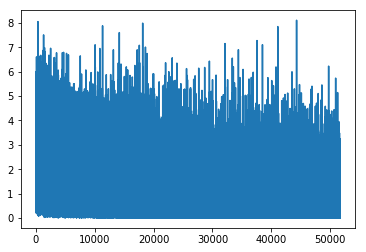

CPU times: user 30min 56s, sys: 5min 37s, total: 36min 34s
Wall time: 33min 22s


In [13]:
%time arya_train()
torch.save(resnet18.state_dict(), 'resnet18.pkl')

In [ ]:
# resnet18.load_state_dict(torch.load('resnet18.pkl'))

# Testing and Accuracy Calculation
Jorah then asks a question, how is this a detection task?<br/>
As everybody wonders, Theon Greyjoy suggests a slding window method to test the above trained trained network on the detection task:<br/>
"We take some windows of varying size and aspect ratios", he mumbled, "and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value!". "He is right", says Samwell, "I read a similar approach in the paper -Faster RCNN by Ross Girshick in the library, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide". You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [ ]:
def theon_sliding_window(image,aspect_ratio,size,slide_amount):
    # Begin
    windows = []
    labels = []
    for x in xrange(0,image.size(0),slide_amount):
        for y in xrange(0,image.size(1),slide_amount):
            box = [x,y,int(x+size*aspect_ratio),y+size]
            crop_img = image.crop(box).convert('RGB')
            images = Variable(crop_img)
            crop_img = composed_transform(crop_img)
            if(use_gpu):
                images = images.cuda()
            output = resnet18(images)
            prob,label = torch.topk(output.data,1)
            if prob > threshold:
                windows.append(box)
                labels.append(label)
    return windows,labels

"Wait", says <b>Jon Snow</b>, "The predicted boxes may be too many and we can't deal with all of them. So, I myself will go and apply non_maximum_supression to reduce the number of boxes". You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [ ]:
def aegon_targaryen_non_maximum_supression(boxes,lables,threshold = 0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > threshold)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int") , labels[pick]

Daenerys, the queen, then orders her army to test out the trained model on the test dataset.

In [ ]:
def daenerys_test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
    correct = 0
    total = 0
    aspect_ratio = [1,0.75,1.33]
    size = [224,112,56]
    slide_amount = 10
    boxes = []
    for images, labels in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        for i in range(3):
            for j in range(3):
                windows, labels = theon_sliding_window(images,aspect_ratio(i),size(j),slide_amount)
                boxes.extend()
        boxes, labels = aegon_targaryen_non_maximum_supression(boxes,labels,0.3)
        

In [ ]:
%time daenerys_test(resnet18)

# Final Showdown
After covering all the steps and passing the accuracy value to the talking crystal, they all pass through to the land of the living, with a wounded Jon Snow armed with the Dragon-axe. After a fierce battle, Jon Snow manages to go face to face with the Night king. Surrounded by battling men and falling bodies, they engage in a ferocious battle, a battle of spear and axe. After a raging fight, Jon manages to sink the axe into the Night king's heart, but not before he gets wounded by the spear. As dead men fall to bones, Daenerys and others rush to his aid, but it is too late. Everyone is in tears as they look towards the man of honour, Jon Snow, lying in Daenerys's arms when he says his last words: "The night has ended. Winter is finally over!"

In [ ]:
print("The night has ended. Winter is finally over!")